In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import pearsonr
import math
import pydicom
from show_keypoints import show_keypoints
import matplotlib.cm as cm
import scipy.stats as stats
from PIL import Image, ImageDraw
import os
import random
from bs4 import BeautifulSoup
import requests
from sklearn.model_selection import train_test_split

### Get software versions and device serial number

In [ ]:
path = "../UKB_xray_image_info/dcm/"

df = pd.DataFrame(columns=['file_name', 'software_version', 'device_serial_number', 'SERIAL_SOFTWARE'])

for f in os.listdir(path):
    if f.endswith(".dcm"):
        dcm = pydicom.dcmread(os.path.join(path, f))
        file_name = f.split(".dcm")[0]
        software_version = dcm.get((0x0018, 0x1020), 'Unknown').value
        device_serial_number = dcm.get((0x0018, 0x1000), 'Unknown').value
        SERIAL_SOFTWARE = "SS_" + str(device_serial_number) + "_" + str(software_version)

        # Append the data to the DataFrame
        df = df.append({
            'file_name': file_name,
            'software_version': software_version,
            'device_serial_number': device_serial_number,
            'SERIAL_SOFTWARE': SERIAL_SOFTWARE
        }, ignore_index=True)

# merge the serial_software with the EID
hip_pheno = pd.read_csv('key_results/hip_select_pheno_cm.csv')[['file_name', 'eid']]
dcm_info = hip_pheno.merge(df, on='file_name', how='inner')
dcm_info.to_csv("../UKB_xray_image_info/dicom_info.csv", index=False)

In [70]:
dcm_info

,file_name,eid,software_version,device_serial_number,SERIAL_SOFTWARE
0,1.2.840.113619.2.110.212038.20190713145954.1.1...,1000308,16.20.059,212038,SS_212038_16.20.059
1,1.2.840.113619.2.110.210419.20180924120844.1.1...,1000320,16.20.059,210419,SS_210419_16.20.059
2,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,16.20.059,212038,SS_212038_16.20.059
3,1.2.840.113619.2.110.212038.20171116132027.1.1...,1001329,16.20.059,212038,SS_212038_16.20.059
4,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,16.20.059,210419,SS_210419_16.20.059
...,...,...,...,...,...
39342,1.2.840.113619.2.110.210419.20170408102812.1.1...,6021811,16.00.158,210419,SS_210419_16.00.158
39343,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,16.00.158,210419,SS_210419_16.00.158
39344,1.2.840.113619.2.110.210419.20150918144642.2.1...,6022737,15.20.002,210419,SS_210419_15.20.002
39345,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,16.00.158,210419,SS_210419_16.00.158


### Make covar file for imaging individuals white british

In [19]:
# get all fid and iid for white british
column_names = ['FID', 'IID', 'PID', 'MID', 'SEX', 'PHENOTYPE']
fam_df = pd.read_csv('./UKB_Imaging_Genetics/merged_sub_maf0.001_biallel_bbf_400k_white_british.fam', sep='\s+', header=None, names=column_names)

# rename PC columns and remove PC21-40
PC_df = pd.read_csv('./UKB_Imaging_Genetics/fid22009.csv', sep = ',')
PC_df.columns = ["eid"] + [f"PC{i}" for i in range(1, 41)]

columns_to_remove = [f"PC{i}" for i in range(21, 41)]  
PC_df = PC_df.drop(columns=columns_to_remove, errors='ignore')

covar_df = fam_df.merge(PC_df, left_on='IID', right_on='eid', how='inner')

# get age, sex, height information
fid_info = pd.read_csv("../UKB_xray_image_info/fids/fid_disease/fid_info_400k_20240104.csv", sep = ',')[['eid', 'age_imaging_visit', 'sex', 'standing_height_imaging_visit']]; fid_info
covar_df = covar_df.merge(fid_info, left_on='eid', right_on='eid', how='inner')

# remove redundant columns
covar_df.drop(['PID', 'MID', 'SEX', 'PHENOTYPE', 'eid'], axis=1, inplace=True)

# rename columns
covar_df.rename({'age_imaging_visit': 'AGE', 'sex': "SEX", 'standing_height_imaging_visit': 'HEIGHT'}, axis=1, inplace=True)
covar_df['HEIGHT2'] = covar_df['HEIGHT']**2

# add some covariates
covar_df['AGE2'] = covar_df['AGE']**2
covar_df['SEXAGE'] = covar_df['SEX'] * covar_df['AGE']
covar_df['SEXAGE2'] = covar_df['SEX'] * covar_df['AGE']**2

# add serial_software
dcm_info = pd.read_csv("../UKB_xray_image_info/dicom_info.csv")[['file_name', 'eid', 'SERIAL_SOFTWARE']]
dcm_info.sort_values(by = ['eid', 'file_name'], ascending=[True, True], inplace=True)
dcm_info.drop_duplicates(subset=['eid'], keep='first', inplace=True)
covar_df = covar_df.merge(dcm_info, left_on='IID', right_on='eid', how='inner')

# remove redundant columns
covar_df.drop(['eid'], axis=1, inplace=True)

# remove NA
covar_df.dropna(inplace=True)

# save
covar_df.to_csv('./UKB_Imaging_Genetics/GWAS_INPUT_DATA/covar_40k_imaging_20240104.txt', sep = " ", index=False)

In [20]:
covar_df.columns

Index(['FID', 'IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17',
       'PC18', 'PC19', 'PC20', 'AGE', 'SEX', 'HEIGHT', 'HEIGHT2', 'AGE2',
       'SEXAGE', 'SEXAGE2', 'file_name', 'SERIAL_SOFTWARE'],
      dtype='object')

In [21]:
covar_df.drop(columns=['HEIGHT2', 'AGE2', 'SEXAGE', 'SEXAGE2', 'file_name'], inplace=True)
covar_df.to_csv('./UKB_Imaging_Genetics/GWAS_INPUT_DATA/plink_covar_40k_imaging_20240104.txt', sep = " ", index=False)

In [22]:
covar_df.columns

Index(['FID', 'IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17',
       'PC18', 'PC19', 'PC20', 'AGE', 'SEX', 'HEIGHT', 'SERIAL_SOFTWARE'],
      dtype='object')

### Make covar file for 400k individuals white british

In [6]:
# get all fid and iid for white british
column_names = ['FID', 'IID', 'PID', 'MID', 'SEX', 'PHENOTYPE']
fam_df = pd.read_csv('./UKB_Imaging_Genetics/merged_sub_maf0.001_biallel_bbf_400k_white_british.fam', sep='\s+', header=None, names=column_names)

# rename PC columns and remove PC21-40
PC_df = pd.read_csv('./UKB_Imaging_Genetics/fid22009.csv', sep = ',')
PC_df.columns = ["eid"] + [f"PC{i}" for i in range(1, 41)]

columns_to_remove = [f"PC{i}" for i in range(21, 41)]  
PC_df = PC_df.drop(columns=columns_to_remove, errors='ignore')

covar_df = fam_df.merge(PC_df, left_on='IID', right_on='eid', how='inner')

# get age, sex, height information
fid_info = pd.read_csv("../UKB_xray_image_info/fids/fid_disease/fid_info_400k_20240104.csv", sep = ',')[['eid', 'age', 'sex']]; fid_info
covar_df = covar_df.merge(fid_info, left_on='eid', right_on='eid', how='inner')

# remove redundant columns
covar_df.drop(['PID', 'MID', 'SEX', 'PHENOTYPE', 'eid'], axis=1, inplace=True)

# rename columns
covar_df.rename({'age': 'AGE', 'sex': "SEX"}, axis=1, inplace=True)

# add some covariates
covar_df['AGE2'] = covar_df['AGE']**2
covar_df['SEXAGE'] = covar_df['SEX'] * covar_df['AGE']
covar_df['SEXAGE2'] = covar_df['SEX'] * covar_df['AGE']**2

# remove NA
covar_df.dropna(inplace=True)

# save
covar_df.to_csv('./UKB_Imaging_Genetics/GWAS_INPUT_DATA/covar_400k_20240320.txt', sep = " ", index=False)

In [7]:
covar_df

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC16,PC17,PC18,PC19,PC20,AGE,SEX,AGE2,SEXAGE,SEXAGE2
0,1000011,1000011,-13.84930,4.66820,0.629980,7.883860,14.791100,-0.527804,2.797600,-0.876043,...,0.442455,-1.466750,-8.013810,4.055920,-5.199500,50.0,0.0,2500.0,0.0,0.0
1,1000026,1000026,-11.33050,6.43170,-0.301415,-2.537360,-9.305720,4.765020,-1.391040,0.194816,...,-0.731087,0.659766,0.386768,1.957890,1.015310,59.0,1.0,3481.0,59.0,3481.0
2,1000032,1000032,-13.52700,4.60185,-2.528160,-1.424620,0.960400,-2.086600,-0.866667,0.392374,...,-0.225871,-3.112810,-2.109150,-4.088490,1.411410,50.0,0.0,2500.0,0.0,0.0
3,1000060,1000060,-10.07460,5.66969,-1.121770,3.096290,-5.462910,-1.409950,0.417993,-2.350320,...,-0.198975,0.612011,-1.860850,0.580956,-0.143335,54.0,0.0,2916.0,0.0,0.0
4,1000083,1000083,-13.64920,6.30138,-1.464490,0.597857,3.287830,1.383300,1.249120,-0.224952,...,7.953920,1.053860,1.705720,-3.111490,-0.222030,56.0,0.0,3136.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402227,6024877,6024877,-11.53160,4.61181,-2.277910,5.479920,12.915600,-0.358599,-1.015170,-1.687950,...,-4.178370,4.812280,-2.353500,-0.966063,-2.422980,62.0,1.0,3844.0,62.0,3844.0
402228,6024884,6024884,-9.67937,2.28478,-1.682700,3.770500,2.406000,-0.040925,-2.444220,-1.601790,...,1.165680,0.002156,-2.970630,-2.303800,-1.155280,48.0,1.0,2304.0,48.0,2304.0
402229,6024895,6024895,-11.65080,3.19475,-2.315910,3.687250,-0.551556,-1.632460,-0.020148,-2.682440,...,0.279108,-0.040651,3.622240,2.741980,-4.252590,55.0,1.0,3025.0,55.0,3025.0
402230,6024913,6024913,-14.66110,2.91677,-1.624580,5.574640,7.682750,-0.079685,1.285760,1.790390,...,-13.309300,-0.918372,4.496170,-0.237348,-2.360360,64.0,1.0,4096.0,64.0,4096.0


In [9]:
covar_df = pd.read_csv("./UKB_Imaging_Genetics/GWAS_INPUT_DATA/covar_400k_20240320.txt", sep = " ")
plink_covar_df = covar_df.drop(columns=['AGE2', 'SEXAGE', 'SEXAGE2'])
plink_covar_df.to_csv('./UKB_Imaging_Genetics/GWAS_INPUT_DATA/plink_covar_400k_20240320.txt', sep = " ", index=False)

### Data cleaning

In [2]:
hip_pheno = pd.read_csv('key_results/hip_select_pheno_cm.csv'); hip_pheno

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,...,acetabular_diameter,acetabular_inclination,humerus,femur,forearm,tibia,arm_length,leg_length,leg_divide_torso,pelvic_inlet_area
0,15998_82,1.2.840.113619.2.110.212038.20190713145954.1.1...,1000308,1.0,182.0,91.5,27.6235,67.0,25.278134,31.968543,...,6.811823,56.275191,30.641372,49.354825,29.255057,44.262392,59.896430,93.617217,1.446595,130.830780
1,02879_82,1.2.840.113619.2.110.210419.20180924120844.1.1...,1000320,0.0,167.0,80.0,28.6851,64.0,23.340543,29.261568,...,5.206508,67.136555,28.182432,45.652312,25.412075,39.512738,53.594507,85.165049,1.486175,127.566679
2,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,22.297293,30.113663,...,6.141783,60.747735,30.816804,48.489427,26.856522,40.743734,57.673326,89.233162,1.651141,108.190429
3,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,23.742297,30.901775,...,6.035855,59.189839,28.115456,44.984030,26.628187,40.081134,54.743642,85.065164,1.449931,102.660623
4,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,153.0,56.1,23.9651,75.0,22.226944,30.934457,...,5.531657,59.017487,26.778209,42.934407,23.988531,35.818183,50.766740,78.752591,1.537721,139.989191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38196,12857_93,1.2.840.113619.2.110.210419.20170408102812.1.1...,6021811,0.0,170.0,57.4,19.8616,69.0,22.195469,30.523987,...,5.132306,58.792442,29.838081,47.704132,27.818466,41.904510,57.656547,89.608642,1.530112,112.668303
38197,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,87.7,36.0371,69.0,20.946633,26.922261,...,4.959191,67.937764,28.030085,42.718048,24.880466,37.908781,52.910551,80.626829,1.461921,126.477899
38198,00922_93,1.2.840.113619.2.110.210419.20150918144642.2.1...,6022737,1.0,186.0,72.8,21.0429,63.0,25.396006,32.074461,...,6.812095,61.621522,34.381037,52.893919,31.659763,45.982489,66.040801,98.876408,1.635700,102.976979
38199,16309_93,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,0.0,170.0,61.5,21.2803,51.0,22.787944,29.871832,...,5.201943,60.779334,29.276081,45.262378,25.847555,38.992764,55.123637,84.255142,1.384857,150.788401


In [14]:
covar_df = pd.read_csv('./UKB_Imaging_Genetics/GWAS_INPUT_DATA/covar_40k_imaging_20240104.txt', sep = " "); covar_df

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC20,AGE,SEX,HEIGHT,HEIGHT2,AGE2,SEXAGE,SEXAGE2,file_name,SERIAL_SOFTWARE
0,1000276,1000276,-12.4105,4.64514,-3.622420,5.980920,-7.061210,-2.844940,1.447260,-4.110470,...,11.190400,67.0,0.0,160.0,25600.00,4489.0,0.0,0.0,1.2.840.113619.2.110.210419.20160630134650.1.1...,SS_210419_16.00.158
1,1000742,1000742,-13.4871,3.94973,-2.277800,5.638660,21.510600,-1.485880,-0.150935,3.719550,...,-2.106240,67.0,0.0,160.0,25600.00,4489.0,0.0,0.0,1.2.840.113619.2.110.210419.20170305174208.1.1...,SS_210419_16.00.158
2,1000951,1000951,-16.5284,3.53244,-0.421914,5.432070,7.310350,-1.167890,-0.547475,2.062850,...,-0.357651,78.0,1.0,166.0,27556.00,6084.0,78.0,6084.0,1.2.840.113619.2.110.212038.20190307144208.1.1...,SS_212038_16.20.059
3,1001025,1001025,-13.8205,3.38118,0.495384,-1.111690,-5.541310,-1.830790,0.781520,-2.161940,...,-2.059780,56.0,0.0,167.0,27889.00,3136.0,0.0,0.0,1.2.840.113619.2.110.210419.20151211144320.1.1...,SS_210419_16.00.158
4,1001091,1001091,-13.0812,3.87649,-3.759090,0.539327,-11.600100,-0.399333,-1.265270,-1.461750,...,-0.683705,60.0,0.0,161.5,26082.25,3600.0,0.0,0.0,1.2.840.113619.2.110.210419.20170902122319.1.1...,SS_210419_16.00.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31207,6023985,6023985,-13.1687,3.20078,-1.536440,1.981020,-4.450010,-2.889470,0.840123,0.333759,...,-0.024228,66.0,0.0,164.6,27093.16,4356.0,0.0,0.0,1.2.840.113619.2.110.210419.20190117162724.1.1...,SS_210419_16.20.059
31208,6024029,6024029,-11.3007,1.94620,-2.961530,3.255970,-0.093339,-0.585923,0.048063,-1.632140,...,-0.785720,50.0,1.0,179.0,32041.00,2500.0,50.0,2500.0,1.2.840.113619.2.110.210419.20170418184226.1.1...,SS_210419_16.00.158
31209,6024037,6024037,-12.5736,1.53991,-2.019910,2.278480,-9.960630,1.128140,-0.393647,-3.298780,...,-0.063200,61.0,1.0,181.0,32761.00,3721.0,61.0,3721.0,1.2.840.113619.2.110.210419.20180811105258.1.1...,SS_210419_16.20.059
31210,6024257,6024257,-14.4691,1.81586,0.069078,2.070290,2.293480,0.174149,-0.233781,-0.208208,...,-1.087590,71.0,1.0,167.0,27889.00,5041.0,71.0,5041.0,1.2.840.113619.2.110.210419.20190219154149.1.1...,SS_210419_16.20.059


In [15]:
# keep white british
hip_pheno = hip_pheno[hip_pheno['file_name'].isin(covar_df['file_name'])]

In [16]:
# filter ids that patients who don't want to share any more
remove_ids = pd.read_csv("../UKB_xray_image_info/remove_eids_20230504.csv", header=None)[0].tolist()
hip_pheno = hip_pheno[~hip_pheno['eid'].isin(remove_ids)]

In [17]:
hip_pheno

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,...,acetabular_diameter,acetabular_inclination,humerus,femur,forearm,tibia,arm_length,leg_length,leg_divide_torso,pelvic_inlet_area
2,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,22.297293,30.113663,...,6.141783,60.747735,30.816804,48.489427,26.856522,40.743734,57.673326,89.233162,1.651141,108.190429
3,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,23.742297,30.901775,...,6.035855,59.189839,28.115456,44.984030,26.628187,40.081134,54.743642,85.065164,1.449931,102.660623
4,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,153.0,56.1,23.9651,75.0,22.226944,30.934457,...,5.531657,59.017487,26.778209,42.934407,23.988531,35.818183,50.766740,78.752591,1.537721,139.989191
5,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,166.0,64.2,23.2980,62.0,22.861258,28.863430,...,5.834113,58.027399,29.972729,46.587679,28.561098,39.566371,58.533827,86.154050,1.493503,110.520822
6,01561_82,1.2.840.113619.2.110.210419.20180630141714.1.1...,1001950,1.0,165.0,89.6,32.9109,62.0,23.080688,29.385649,...,5.731393,57.335593,29.012823,45.245573,27.292476,39.041382,56.305299,84.286956,1.465162,109.946859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38194,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,177.0,89.0,28.4082,71.0,25.247090,32.848104,...,6.149698,60.427962,31.540230,50.329159,30.128478,44.856165,61.668708,95.185324,1.583562,134.603261
38195,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,71.0,22.1591,69.0,25.232678,30.970184,...,6.504511,59.444884,30.777846,48.408803,28.966865,42.070750,59.744710,90.479553,1.479675,132.776803
38197,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,87.7,36.0371,69.0,20.946633,26.922261,...,4.959191,67.937764,28.030085,42.718048,24.880466,37.908781,52.910551,80.626829,1.461921,126.477899
38199,16309_93,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,0.0,170.0,61.5,21.2803,51.0,22.787944,29.871832,...,5.201943,60.779334,29.276081,45.262378,25.847555,38.992764,55.123637,84.255142,1.384857,150.788401


In [18]:
hip_pheno.to_csv('key_results/hip_select_pheno_cm_eid_flt.csv', index=False)

#### Z-score filter

In [2]:
hip_pheno = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt.csv')

In [3]:
hip_pheno

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,...,arm_devide_torso,bi_acetabular_width,torso_length,iliac_isthmus_breadth,acetabular_diameter,acetabular_inclination,arm_length,leg_length,leg_divide_torso,pelvic_inlet_area
0,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,22.297293,30.113663,...,1.067168,20.324819,54.043332,4.164529,6.141783,60.747735,57.673326,89.233162,1.651141,108.190429
1,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,23.742297,30.901775,...,0.933102,20.756184,58.668433,4.657824,6.035855,59.189839,54.743642,85.065164,1.449931,102.660623
2,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,153.0,56.1,23.9651,75.0,22.226944,30.934457,...,0.991270,21.701987,51.213839,3.718747,5.531657,59.017487,50.766740,78.752591,1.537721,139.989191
3,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,166.0,64.2,23.2980,62.0,22.861258,28.863430,...,1.014700,19.784228,57.685872,4.238295,5.834113,58.027399,58.533827,86.154050,1.493503,110.520822
4,01561_82,1.2.840.113619.2.110.210419.20180630141714.1.1...,1001950,1.0,165.0,89.6,32.9109,62.0,23.080688,29.385649,...,0.978756,19.821637,57.527410,4.438966,5.731393,57.335593,56.305299,84.286956,1.465162,109.946859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31129,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,177.0,89.0,28.4082,71.0,25.247090,32.848104,...,1.025959,20.686542,60.108352,4.014342,6.149698,60.427962,61.668708,95.185324,1.583562,134.603261
31130,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,71.0,22.1591,69.0,25.232678,30.970184,...,0.977047,20.729378,61.148256,4.381059,6.504511,59.444884,59.744710,90.479553,1.479675,132.776803
31131,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,87.7,36.0371,69.0,20.946633,26.922261,...,0.959371,19.152575,55.151275,3.211435,4.959191,67.937764,52.910551,80.626829,1.461921,126.477899
31132,16309_93,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,0.0,170.0,61.5,21.2803,51.0,22.787944,29.871832,...,0.906038,19.990121,60.840325,3.935749,5.201943,60.779334,55.123637,84.255142,1.384857,150.788401


In [119]:
# filter phenotypes

pheno = ['image_id', 'file_name', 'eid', 'sex', 'standing_height_imaging_visit', 'weight_imaging_visit', 'bmi_imaging_visit', 'age_imaging_visit',
         'pelvic_height', 'pelvic_width', 'pelvic_inlet_width', 'oblique_pelvic_inlet_length', 
         'subpubic_angle', 'bi_acetabular_width', 'iliac_isthmus_breadth', 'acetabular_diameter']
hip_pheno_flt = hip_pheno[pheno]; hip_pheno_flt

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,pelvic_inlet_width,oblique_pelvic_inlet_length,subpubic_angle,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter
0,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,22.297293,30.113663,13.937174,9.883806,116.365190,20.324819,4.164529,6.141783
1,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,23.742297,30.901775,13.669524,9.562262,117.491690,20.756184,4.657824,6.035855
2,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,153.0,56.1,23.9651,75.0,22.226944,30.934457,15.755275,11.313022,139.787157,21.701987,3.718747,5.531657
3,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,166.0,64.2,23.2980,62.0,22.861258,28.863430,14.217750,9.897451,116.159185,19.784228,4.238295,5.834113
4,01561_82,1.2.840.113619.2.110.210419.20180630141714.1.1...,1001950,1.0,165.0,89.6,32.9109,62.0,23.080688,29.385649,13.583558,10.305746,130.647738,19.821637,4.438966,5.731393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31129,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,177.0,89.0,28.4082,71.0,25.247090,32.848104,14.645469,11.702063,126.858511,20.686542,4.014342,6.149698
31130,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,71.0,22.1591,69.0,25.232678,30.970184,14.210350,11.896728,120.568969,20.729378,4.381059,6.504511
31131,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,87.7,36.0371,69.0,20.946633,26.922261,13.540263,11.893171,143.403514,19.152575,3.211435,4.959191
31132,16309_93,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,0.0,170.0,61.5,21.2803,51.0,22.787944,29.871832,13.586974,14.130428,157.984881,19.990121,3.935749,5.201943


In [120]:
hip_pheno_flt_eid_list = hip_pheno_flt[(np.abs(stats.zscore(hip_pheno_flt.iloc[:, 8:])) < 4).all(axis=1)]['eid']
len(hip_pheno_flt_eid_list)

31115

In [121]:
hip_pheno_flt = hip_pheno[hip_pheno['eid'].isin(hip_pheno_flt_eid_list)]; hip_pheno_flt

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,...,arm_devide_torso,bi_acetabular_width,torso_length,iliac_isthmus_breadth,acetabular_diameter,acetabular_inclination,arm_length,leg_length,leg_divide_torso,pelvic_inlet_area
0,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,22.297293,30.113663,...,1.067168,20.324819,54.043332,4.164529,6.141783,60.747735,57.673326,89.233162,1.651141,108.190429
1,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,23.742297,30.901775,...,0.933102,20.756184,58.668433,4.657824,6.035855,59.189839,54.743642,85.065164,1.449931,102.660623
2,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,153.0,56.1,23.9651,75.0,22.226944,30.934457,...,0.991270,21.701987,51.213839,3.718747,5.531657,59.017487,50.766740,78.752591,1.537721,139.989191
3,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,166.0,64.2,23.2980,62.0,22.861258,28.863430,...,1.014700,19.784228,57.685872,4.238295,5.834113,58.027399,58.533827,86.154050,1.493503,110.520822
4,01561_82,1.2.840.113619.2.110.210419.20180630141714.1.1...,1001950,1.0,165.0,89.6,32.9109,62.0,23.080688,29.385649,...,0.978756,19.821637,57.527410,4.438966,5.731393,57.335593,56.305299,84.286956,1.465162,109.946859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31129,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,177.0,89.0,28.4082,71.0,25.247090,32.848104,...,1.025959,20.686542,60.108352,4.014342,6.149698,60.427962,61.668708,95.185324,1.583562,134.603261
31130,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,71.0,22.1591,69.0,25.232678,30.970184,...,0.977047,20.729378,61.148256,4.381059,6.504511,59.444884,59.744710,90.479553,1.479675,132.776803
31131,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,87.7,36.0371,69.0,20.946633,26.922261,...,0.959371,19.152575,55.151275,3.211435,4.959191,67.937764,52.910551,80.626829,1.461921,126.477899
31132,16309_93,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,0.0,170.0,61.5,21.2803,51.0,22.787944,29.871832,...,0.906038,19.990121,60.840325,3.935749,5.201943,60.779334,55.123637,84.255142,1.384857,150.788401


In [122]:
hip_pheno_flt.to_csv('key_results/hip_select_pheno_cm_eid_flt_z_flt.csv', index=False)

### Other skeletal traits

In [19]:
hip_pheno = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt.csv')

In [20]:
hip_pheno.columns

Index(['image_id', 'file_name', 'eid', 'sex', 'standing_height_imaging_visit',
       'weight_imaging_visit', 'bmi_imaging_visit', 'age_imaging_visit',
       'pelvic_height', 'pelvic_width', 'pelvic_inlet_width',
       'iliac_flare_ratio', 'oblique_pelvic_inlet_length', 'iliac_flare_angle',
       'subpubic_angle', 'head_diameter', 'trochanter_distance',
       'shoulder_width', 'arm_devide_torso', 'bi_acetabular_width',
       'torso_length', 'iliac_isthmus_breadth', 'acetabular_diameter',
       'acetabular_inclination', 'humerus', 'femur', 'forearm', 'tibia',
       'arm_length', 'leg_length', 'leg_divide_torso', 'pelvic_inlet_area'],
      dtype='object')

In [21]:
# filter phenotypes

pheno = ['image_id', 'file_name', 'eid', 'sex', 'standing_height_imaging_visit', 'weight_imaging_visit', 'bmi_imaging_visit', 'age_imaging_visit',
         'head_diameter', 'trochanter_distance', 'shoulder_width', 'torso_length', 'humerus', 'femur', 'forearm', 'tibia']
hip_pheno_flt = hip_pheno[pheno]; hip_pheno_flt

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,head_diameter,trochanter_distance,shoulder_width,torso_length,humerus,femur,forearm,tibia
0,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,14.112233,30.091232,36.696399,54.043332,30.816804,48.489427,26.856522,40.743734
1,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,13.903518,30.813208,39.203992,58.668433,28.115456,44.984030,26.628187,40.081134
2,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,153.0,56.1,23.9651,75.0,13.029582,31.173284,35.909407,51.213839,26.778209,42.934407,23.988531,35.818183
3,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,166.0,64.2,23.2980,62.0,14.480994,29.777444,33.219853,57.685872,29.972729,46.587679,28.561098,39.566371
4,01561_82,1.2.840.113619.2.110.210419.20180630141714.1.1...,1001950,1.0,165.0,89.6,32.9109,62.0,14.042468,28.838122,39.066233,57.527410,29.012823,45.245573,27.292476,39.041382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31129,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,177.0,89.0,28.4082,71.0,13.402493,30.995640,41.118337,60.108352,31.540230,50.329159,30.128478,44.856165
31130,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,71.0,22.1591,69.0,13.781823,31.116022,38.579135,61.148256,30.777846,48.408803,28.966865,42.070750
31131,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,87.7,36.0371,69.0,12.551823,27.342555,35.846661,55.151275,28.030085,42.718048,24.880466,37.908781
31132,16309_93,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,0.0,170.0,61.5,21.2803,51.0,12.309345,27.698720,36.369916,60.840325,29.276081,45.262378,25.847555,38.992764


In [24]:
z_keep_eids = pd.read_csv("key_results/hip_select_pheno_cm_eid_flt_z_flt.csv")['eid'].tolist()

hip_pheno_flt = hip_pheno_flt[hip_pheno_flt['eid'].isin(z_keep_eids)]

hip_pheno_flt.to_csv("key_results/skeletal_cm_eid_flt_z_flt", index = False)

## Heritability

### Prepare data for h2g

#### use raw phenotype data (cm)

In [37]:
hip_pheno_flt_eid_flt_cm = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt_z_flt.csv'); hip_pheno_flt_eid_flt_cm

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,...,trochanter_left2trochanter_right,shoulder_width,arm_devide_torso,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter,acetabular_inclination,arm_length,leg_length,pelvic_inlet_area
0,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,22.297293,30.113663,...,30.091232,36.696399,1.067168,20.324819,4.164529,6.141783,60.747735,57.673326,89.233162,108.190429
1,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,23.742297,30.901775,...,30.813208,39.203992,0.933102,20.756184,4.657824,6.035855,59.189839,54.743642,85.065164,102.660623
2,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,153.0,56.1,23.9651,75.0,22.226944,30.934457,...,31.173284,35.909407,0.991270,21.701987,3.718747,5.531657,59.017487,50.766740,78.752591,139.989191
3,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,166.0,64.2,23.2980,62.0,22.861258,28.863430,...,29.777444,33.219853,1.014700,19.784228,4.238295,5.834113,58.027399,58.533827,86.154050,110.520822
4,01561_82,1.2.840.113619.2.110.210419.20180630141714.1.1...,1001950,1.0,165.0,89.6,32.9109,62.0,23.080688,29.385649,...,28.838122,39.066233,0.978756,19.821637,4.438966,5.731393,57.335593,56.305299,84.286956,109.946859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31110,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,177.0,89.0,28.4082,71.0,25.247090,32.848104,...,30.995640,41.118337,1.025959,20.686542,4.014342,6.149698,60.427962,61.668708,95.185324,134.603261
31111,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,71.0,22.1591,69.0,25.232678,30.970184,...,31.116022,38.579135,0.977047,20.729378,4.381059,6.504511,59.444884,59.744710,90.479553,132.776803
31112,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,87.7,36.0371,69.0,20.946633,26.922261,...,27.342555,35.846661,0.959371,19.152575,3.211435,4.959191,67.937764,52.910551,80.626829,126.477899
31113,16309_93,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,0.0,170.0,61.5,21.2803,51.0,22.787944,29.871832,...,27.698720,36.369916,0.906038,19.990121,3.935749,5.201943,60.779334,55.123637,84.255142,150.788401


In [38]:
# select the phenotypes for h2g
hip_pheno_gwas_cm = hip_pheno_flt_eid_flt_cm.iloc[:, 8:]

ids = hip_pheno_flt_eid_flt_cm['eid'].tolist()

hip_pheno_gwas_cm['FID'] = ids
hip_pheno_gwas_cm['IID'] = ids

# put FID and IID to the first two columns
cols = hip_pheno_gwas_cm.columns
cols = cols[-2:].tolist() + cols[:-2].tolist()
hip_pheno_gwas_cm = hip_pheno_gwas_cm[cols]

hip_pheno_gwas_cm

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,iliac_flare_ratio,oblique_pelvic_inlet_length,iliac_flare_angle,subpubic_angle,ear_left2ear_right,trochanter_left2trochanter_right,shoulder_width,arm_devide_torso,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter,acetabular_inclination,arm_length,leg_length,pelvic_inlet_area
0,1000951,1000951,22.297293,30.113663,13.937174,0.462819,9.883806,97.533181,116.365190,14.112233,30.091232,36.696399,1.067168,20.324819,4.164529,6.141783,60.747735,57.673326,89.233162,108.190429
1,1001512,1001512,23.742297,30.901775,13.669524,0.442354,9.562262,95.714405,117.491690,13.903518,30.813208,39.203992,0.933102,20.756184,4.657824,6.035855,59.189839,54.743642,85.065164,102.660623
2,1001867,1001867,22.226944,30.934457,15.755275,0.509312,11.313022,101.418560,139.787157,13.029582,31.173284,35.909407,0.991270,21.701987,3.718747,5.531657,59.017487,50.766740,78.752591,139.989191
3,1001921,1001921,22.861258,28.863430,14.217750,0.492587,9.897451,95.473293,116.159185,14.480994,29.777444,33.219853,1.014700,19.784228,4.238295,5.834113,58.027399,58.533827,86.154050,110.520822
4,1001950,1001950,23.080688,29.385649,13.583558,0.462251,10.305746,95.952879,130.647738,14.042468,28.838122,39.066233,0.978756,19.821637,4.438966,5.731393,57.335593,56.305299,84.286956,109.946859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31110,6021112,6021112,25.247090,32.848104,14.645469,0.445854,11.702063,95.353305,126.858511,13.402493,30.995640,41.118337,1.025959,20.686542,4.014342,6.149698,60.427962,61.668708,95.185324,134.603261
31111,6021539,6021539,25.232678,30.970184,14.210350,0.458840,11.896728,87.564668,120.568969,13.781823,31.116022,38.579135,0.977047,20.729378,4.381059,6.504511,59.444884,59.744710,90.479553,132.776803
31112,6022591,6022591,20.946633,26.922261,13.540263,0.502939,11.893171,88.868037,143.403514,12.551823,27.342555,35.846661,0.959371,19.152575,3.211435,4.959191,67.937764,52.910551,80.626829,126.477899
31113,6023431,6023431,22.787944,29.871832,13.586974,0.454842,14.130428,90.205445,157.984881,12.309345,27.698720,36.369916,0.906038,19.990121,3.935749,5.201943,60.779334,55.123637,84.255142,150.788401


In [83]:
hip_pheno_gwas_cm

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,oblique_pelvic_inlet_length,subpubic_angle,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter,pelvic_inlet_area,leg_length
0,1000951,1000951,22.297293,30.113663,13.937174,9.883806,116.365190,20.324819,4.164529,6.141783,108.190429,89.233162
1,1001512,1001512,23.742297,30.901775,13.669524,9.562262,117.491690,20.756184,4.657824,6.035855,102.660623,85.065164
2,1001867,1001867,22.226944,30.934457,15.755275,11.313022,139.787157,21.701987,3.718747,5.531657,139.989191,78.752591
3,1001921,1001921,22.861258,28.863430,14.217750,9.897451,116.159185,19.784228,4.238295,5.834113,110.520822,86.154050
4,1001950,1001950,23.080688,29.385649,13.583558,10.305746,130.647738,19.821637,4.438966,5.731393,109.946859,84.286956
...,...,...,...,...,...,...,...,...,...,...,...,...
31110,6021112,6021112,25.247090,32.848104,14.645469,11.702063,126.858511,20.686542,4.014342,6.149698,134.603261,95.185324
31111,6021539,6021539,25.232678,30.970184,14.210350,11.896728,120.568969,20.729378,4.381059,6.504511,132.776803,90.479553
31112,6022591,6022591,20.946633,26.922261,13.540263,11.893171,143.403514,19.152575,3.211435,4.959191,126.477899,80.626829
31113,6023431,6023431,22.787944,29.871832,13.586974,14.130428,157.984881,19.990121,3.935749,5.201943,150.788401,84.255142


In [39]:
hip_pheno_flt_eid_flt_cm[['eid', 'eid']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_eids_20240104.txt', index=False, header=False, sep=' ')

In [40]:
hip_pheno_gwas_cm.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_cm_20240104.txt', index=False, sep = " ")
hip_pheno_gwas_cm.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_cm_no_header_20240104.txt', index=False, header=False, sep = " ")

#### Run gwas for height

In [5]:
fid_info = pd.read_csv('../UKB_xray_image_info/fids/fid_disease/fid_info_400k_20231028.csv'); fid_info

,eid,sex,age,standing_height,bmi,weight,household_income,pelvis_bmd,patient_birth_weight,hip_circumference,...,female_baby,n_pregnancy,n_weeks_gestation,baby_birth_weight,postnatal_stay_duration,ethnic_group,keep_allna_incontinence,remove_allna_incontinence,sitting_height,leg_length
0,1000011,0.0,50.0,167.0,25.1712,70.2,3.0,NaN,3.74,103.0,...,NaN,NaN,NaN,NaN,NaN,white,0,NaN,89.0,78.0
1,1000026,1.0,59.0,174.0,24.6400,74.6,3.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,white,1,1.0,91.0,83.0
2,1000032,0.0,50.0,170.0,32.2837,93.3,4.0,NaN,4.65,110.0,...,NaN,NaN,NaN,NaN,NaN,white,0,0.0,86.0,84.0
3,1000044,0.0,53.0,154.0,32.3832,76.8,3.0,NaN,NaN,116.0,...,NaN,NaN,NaN,NaN,NaN,white,1,1.0,78.0,76.0
4,1000058,0.0,50.0,155.0,32.3829,77.8,NaN,NaN,NaN,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,81.0,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502485,6024895,1.0,55.0,164.4,16.9828,45.9,4.0,NaN,3.09,84.0,...,NaN,NaN,NaN,NaN,NaN,white,0,0.0,83.4,81.0
502486,6024901,1.0,59.0,177.0,29.0147,90.9,3.0,NaN,4.54,104.0,...,NaN,NaN,NaN,NaN,NaN,white,0,NaN,94.0,83.0
502487,6024913,1.0,64.0,167.0,26.0676,72.7,1.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,white,0,0.0,102.0,65.0
502488,6024922,1.0,48.0,180.0,30.3395,98.3,4.0,NaN,3.77,109.0,...,NaN,NaN,NaN,NaN,NaN,white,0,NaN,95.0,85.0


In [6]:
both_height = fid_info[['eid', 'standing_height']].dropna()
male_height = fid_info[fid_info['sex'] == 1.0][['eid', 'standing_height']].dropna()
female_height = fid_info[fid_info['sex'] == 0.0][['eid', 'standing_height']].dropna()

both_height_eid = both_height['eid'].tolist()
male_height_eid = male_height['eid'].tolist()
female_height_eid = female_height['eid'].tolist()

gwas_standing_height_both = pd.DataFrame({"FID": both_height_eid, "IID": both_height_eid, "standing_height": both_height['standing_height'].tolist()})
gwas_standing_height_male = pd.DataFrame({"FID": male_height_eid, "IID": male_height_eid, "standing_height": male_height['standing_height'].tolist()})
gwas_standing_height_female = pd.DataFrame({"FID": female_height_eid, "IID": female_height_eid, "standing_height": female_height['standing_height'].tolist()})

In [7]:
gwas_standing_height_both

,FID,IID,standing_height
0,1000011,1000011,167.0
1,1000026,1000026,174.0
2,1000032,1000032,170.0
3,1000044,1000044,154.0
4,1000058,1000058,155.0
...,...,...,...
499923,6024884,6024884,179.0
499924,6024895,6024895,164.4
499925,6024901,6024901,177.0
499926,6024913,6024913,167.0


In [156]:
print(f'both_height_shape: {gwas_standing_height_both.shape}')
print(f'male_height_shape: {gwas_standing_height_male.shape}')
print(f'female_height_shape: {gwas_standing_height_female.shape}')

both_height_shape: (499928, 3)
male_height_shape: (227722, 3)
female_height_shape: (272206, 3)


In [157]:
gwas_standing_height_both.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_both_231107.txt', index=False, sep = " ")
gwas_standing_height_both.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_both_no_header_231107.txt', index=False, header=False, sep = " ")

gwas_standing_height_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_male_231107.txt', index=False, sep = " ")
gwas_standing_height_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_male_no_header_231107.txt', index=False, header=False, sep = " ")

gwas_standing_height_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_female_231107.txt', index=False, sep = " ")
gwas_standing_height_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_female_no_header_231107.txt', index=False, header=False, sep = " ")

In [9]:
# removed imaged individuals

# get all fid and iid for imaged individuals
iid_img = pd.read_csv('key_results/hip_pheno_23_cm.csv')['eid'].tolist()
iid_400k = pd.read_csv("UKB_Imaging_Genetics/merged_sub_maf0.01_biallel_bbf_400k_white_british.fam", sep = " ", header=None)[0].tolist()

# both
gwas_standing_height_both = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_both_231107.txt', sep = " ")
gwas_standing_height_both = gwas_standing_height_both[gwas_standing_height_both['IID'].isin(iid_400k)]
gwas_standing_height_both_train = gwas_standing_height_both[~gwas_standing_height_both['IID'].isin(iid_img)]
gwas_standing_height_both_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_both_train_231128.txt', index=False, sep = " ")
gwas_standing_height_both_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_both_train_no_header_231128.txt', index=False, header=False, sep = " ")

# female
gwas_standing_height_female = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_female_231107.txt', sep = " ")
gwas_standing_height_female = gwas_standing_height_female[gwas_standing_height_female['IID'].isin(iid_400k)]
gwas_standing_height_female_train = gwas_standing_height_female[~gwas_standing_height_female['IID'].isin(iid_img)]
gwas_standing_height_female_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_female_train_231128.txt', index=False, sep = " ")
gwas_standing_height_female_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_female_train_no_header_231128.txt', index=False, header=False, sep = " ")

# male
gwas_standing_height_male = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_male_231107.txt', sep = " ")
gwas_standing_height_male = gwas_standing_height_male[gwas_standing_height_male['IID'].isin(iid_400k)]
gwas_standing_height_male_train = gwas_standing_height_male[~gwas_standing_height_male['IID'].isin(iid_img)]
gwas_standing_height_male_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_male_train_231128.txt', index=False, sep = " ")
gwas_standing_height_male_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/gwas_standing_height_male_train_no_header_231128.txt', index=False, header=False, sep = " ")

In [11]:
print(f'both_train_shape: {gwas_standing_height_both_train.shape}')

print(f'female_train_shape: {gwas_standing_height_female_train.shape}')

print(f'male_train_shape: {gwas_standing_height_male_train.shape}')

both_train_shape: (369296, 3)
female_train_shape: (200661, 3)
male_train_shape: (168635, 3)


#### add sex new phenotypes (head or shoulder / pelvic inlet size)

In [119]:
hip_pheno_gwas_cm = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_cm_231109.txt', sep = " "); hip_pheno_gwas_cm

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,iliac_flare_ratio,oblique_pelvic_inlet_length,iliac_flare_angle,subpubic_angle,ear_left2ear_right,trochanter_left2trochanter_right,shoulder_width,arm_devide_torso,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter,acetabular_inclination,arm_length,leg_length,pelvic_inlet_area
0,1000951,1000951,22.297293,30.113663,13.937174,0.462819,9.883806,97.533181,116.365190,14.112233,30.091232,36.696399,1.067168,20.324819,4.164529,6.141783,60.747735,57.673326,89.233162,108.190429
1,1001329,1001329,25.363221,33.085310,13.943964,0.421455,9.796084,99.812799,108.368022,14.487676,31.474656,43.357959,1.023811,21.085789,5.090414,6.729616,56.943430,64.205477,95.795086,107.282431
2,1001512,1001512,23.742297,30.901775,13.669524,0.442354,9.562262,95.714405,117.491690,13.903518,30.813208,39.203992,0.933102,20.756184,4.657824,6.035855,59.189839,54.743642,85.065164,102.660623
3,1001867,1001867,22.226944,30.934457,15.755275,0.509312,11.313022,101.418560,139.787157,13.029582,31.173284,35.909407,0.991270,21.701987,3.718747,5.531657,59.017487,50.766740,78.752591,139.989191
4,1001921,1001921,22.861258,28.863430,14.217750,0.492587,9.897451,95.473293,116.159185,14.480994,29.777444,33.219853,1.014700,19.784228,4.238295,5.834113,58.027399,58.533827,86.154050,110.520822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32040,6021112,6021112,25.247090,32.848104,14.645469,0.445854,11.702063,95.353305,126.858511,13.402493,30.995640,41.118337,1.025959,20.686542,4.014342,6.149698,60.427962,61.668708,95.185324,134.603261
32041,6021539,6021539,25.232678,30.970184,14.210350,0.458840,11.896728,87.564668,120.568969,13.781823,31.116022,38.579135,0.977047,20.729378,4.381059,6.504511,59.444884,59.744710,90.479553,132.776803
32042,6022591,6022591,20.946633,26.922261,13.540263,0.502939,11.893171,88.868037,143.403514,12.551823,27.342555,35.846661,0.959371,19.152575,3.211435,4.959191,67.937764,52.910551,80.626829,126.477899
32043,6023431,6023431,22.787944,29.871832,13.586974,0.454842,14.130428,90.205445,157.984881,12.309345,27.698720,36.369916,0.906038,19.990121,3.935749,5.201943,60.779334,55.123637,84.255142,150.788401


In [120]:
# 2 for head or shoulder / oblique pelvic inlet width
hip_pheno_gwas_cm['head_divide_inlet_width'] = hip_pheno_gwas_cm['ear_left2ear_right'] / hip_pheno_gwas_cm['pelvic_inlet_width']
hip_pheno_gwas_cm['shoulder_divide_inlet_width'] = hip_pheno_gwas_cm['shoulder_width'] / hip_pheno_gwas_cm['pelvic_inlet_width']

# 2 for head or shoulder / oblique pelvic inlet length
hip_pheno_gwas_cm['head_divide_oblique_inlet_length'] = hip_pheno_gwas_cm['ear_left2ear_right'] / hip_pheno_gwas_cm['oblique_pelvic_inlet_length']
hip_pheno_gwas_cm['shoulder_divide_oblique_inlet_length'] = hip_pheno_gwas_cm['shoulder_width'] / hip_pheno_gwas_cm['oblique_pelvic_inlet_length']


# 2 for head or shoulder / pelvic inlet area
hip_pheno_gwas_cm['head_area_divide_pelvic_inlet_area'] = ((hip_pheno_gwas_cm['ear_left2ear_right'] / 2)**2 * math.pi) / hip_pheno_gwas_cm['pelvic_inlet_area']
hip_pheno_gwas_cm['shoulder_area_divide_pelvic_inlet_area'] = ((hip_pheno_gwas_cm['shoulder_width'] / 2)**2 * math.pi) / hip_pheno_gwas_cm['pelvic_inlet_area']

In [121]:
hip_pheno

,image_id,file_name,eid,sex,standing_height,weight,bmi,age,pelvic_height,pelvic_width,...,trochanter_left2trochanter_right,shoulder_width,arm_devide_torso,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter,acetabular_inclination,arm_length,leg_length,pelvic_inlet_area
0,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,167.0,62.9,22.5537,66.0,22.297293,30.113663,...,30.091232,36.696399,1.067168,20.324819,4.164529,6.141783,60.747735,57.673326,89.233162,108.190429
1,09648_82,1.2.840.113619.2.110.212038.20171116132027.1.1...,1001329,1.0,185.0,84.9,24.8064,58.0,25.363221,33.085310,...,31.474656,43.357959,1.023811,21.085789,5.090414,6.729616,56.943430,64.205477,95.795086,107.282431
2,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,171.0,81.4,27.8376,57.0,23.742297,30.901775,...,30.813208,39.203992,0.933102,20.756184,4.657824,6.035855,59.189839,54.743642,85.065164,102.660623
3,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,155.0,66.1,27.5130,64.0,22.226944,30.934457,...,31.173284,35.909407,0.991270,21.701987,3.718747,5.531657,59.017487,50.766740,78.752591,139.989191
4,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,167.0,62.6,22.4461,52.0,22.861258,28.863430,...,29.777444,33.219853,1.014700,19.784228,4.238295,5.834113,58.027399,58.533827,86.154050,110.520822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32060,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,178.0,87.0,27.4587,64.0,25.247090,32.848104,...,30.995640,41.118337,1.025959,20.686542,4.014342,6.149698,60.427962,61.668708,95.185324,134.603261
32061,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,74.7,23.3139,59.0,25.232678,30.970184,...,31.116022,38.579135,0.977047,20.729378,4.381059,6.504511,59.444884,59.744710,90.479553,132.776803
32062,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,96.2,39.5299,62.0,20.946633,26.922261,...,27.342555,35.846661,0.959371,19.152575,3.211435,4.959191,67.937764,52.910551,80.626829,126.477899
32063,16309_93,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,0.0,168.0,58.0,20.5499,43.0,22.787944,29.871832,...,27.698720,36.369916,0.906038,19.990121,3.935749,5.201943,60.779334,55.123637,84.255142,150.788401


#### add 2 new phenotype as postive control: 1. arm:leg, 2. leg:torso

In [122]:
hip_pheno_all = pd.read_csv('key_results/hip_pheno_23_cm.csv')

image_ids = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt_z_flt.csv')['image_id'].tolist()

# filter individuals
hip_pheno_all = hip_pheno_all[hip_pheno_all['image_id'].isin(image_ids)]

# arm to torso ratio
hip_pheno_all['arm_divide_leg'] = ((hip_pheno_all['arm_123_left'] + hip_pheno_all['arm_123_right']) / 2) / ((hip_pheno_all['leg_123_left'] + hip_pheno_all['leg_123_right']) / 2)
hip_pheno_all['leg_divide_torso'] = ((hip_pheno_all['leg_123_left'] + hip_pheno_all['leg_123_right']) / 2) / hip_pheno_all['torso_length']
add_pheno = hip_pheno_all[['eid', 'arm_divide_leg', 'leg_divide_torso']]

# merge previous phenotypes
hip_pheno_gwas_cm = hip_pheno_gwas_cm.merge(add_pheno, left_on='FID', right_on='eid', how='left')
hip_pheno_gwas_cm.drop(columns=['eid'], inplace=True)

In [123]:
hip_pheno_gwas_cm

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,iliac_flare_ratio,oblique_pelvic_inlet_length,iliac_flare_angle,subpubic_angle,ear_left2ear_right,...,leg_length,pelvic_inlet_area,head_divide_inlet_width,shoulder_divide_inlet_width,head_divide_oblique_inlet_length,shoulder_divide_oblique_inlet_length,head_area_divide_pelvic_inlet_area,shoulder_area_divide_pelvic_inlet_area,arm_divide_leg,leg_divide_torso
0,1000951,1000951,22.297293,30.113663,13.937174,0.462819,9.883806,97.533181,116.365190,14.112233,...,89.233162,108.190429,1.012561,2.632987,1.427814,3.712780,1.445748,9.775701,0.646322,1.651141
1,1001329,1001329,25.363221,33.085310,13.943964,0.421455,9.796084,99.812799,108.368022,14.487676,...,95.795086,107.282431,1.038993,3.109443,1.478925,4.426050,1.536593,13.762551,0.670238,1.527534
2,1001512,1001512,23.742297,30.901775,13.669524,0.442354,9.562262,95.714405,117.491690,13.903518,...,85.065164,102.660623,1.017118,2.867985,1.453999,4.099866,1.478888,11.758355,0.643549,1.449931
3,1001867,1001867,22.226944,30.934457,15.755275,0.509312,11.313022,101.418560,139.787157,13.029582,...,78.752591,139.989191,0.826998,2.279199,1.151733,3.174166,0.952481,7.234555,0.644636,1.537721
4,1001921,1001921,22.861258,28.863430,14.217750,0.492587,9.897451,95.473293,116.159185,14.480994,...,86.154050,110.520822,1.018515,2.336506,1.463103,3.356405,1.490193,7.842259,0.679409,1.493503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32040,6021112,6021112,25.247090,32.848104,14.645469,0.445854,11.702063,95.353305,126.858511,13.402493,...,95.185324,134.603261,0.915129,2.807581,1.145310,3.513768,1.048107,9.865188,0.647880,1.583562
32041,6021539,6021539,25.232678,30.970184,14.210350,0.458840,11.896728,87.564668,120.568969,13.781823,...,90.479553,132.776803,0.969844,2.714862,1.158455,3.242836,1.123520,8.803850,0.660312,1.479675
32042,6022591,6022591,20.946633,26.922261,13.540263,0.502939,11.893171,88.868037,143.403514,12.551823,...,80.626829,126.477899,0.927000,2.647412,1.055381,3.014054,0.978338,7.979445,0.656240,1.461921
32043,6023431,6023431,22.787944,29.871832,13.586974,0.454842,14.130428,90.205445,157.984881,12.309345,...,84.255142,150.788401,0.905967,2.676822,0.871123,2.573872,0.789209,6.889799,0.654247,1.384857


In [124]:
hip_pheno_gwas_cm.columns

Index(['FID', 'IID', 'pelvic_height', 'pelvic_width', 'pelvic_inlet_width',
       'iliac_flare_ratio', 'oblique_pelvic_inlet_length', 'iliac_flare_angle',
       'subpubic_angle', 'ear_left2ear_right',
       'trochanter_left2trochanter_right', 'shoulder_width',
       'arm_devide_torso', 'bi_acetabular_width', 'iliac_isthmus_breadth',
       'acetabular_diameter', 'acetabular_inclination', 'arm_length',
       'leg_length', 'pelvic_inlet_area', 'head_divide_inlet_width',
       'shoulder_divide_inlet_width', 'head_divide_oblique_inlet_length',
       'shoulder_divide_oblique_inlet_length',
       'head_area_divide_pelvic_inlet_area',
       'shoulder_area_divide_pelvic_inlet_area', 'arm_divide_leg',
       'leg_divide_torso'],
      dtype='object')

#### filter phenotypes for gwas

In [41]:
pheno = ['FID', 'IID', 'pelvic_height', 'pelvic_width', 'pelvic_inlet_width',
         'oblique_pelvic_inlet_length', 'subpubic_angle', 'bi_acetabular_width', 
         'iliac_isthmus_breadth', 'acetabular_diameter', 'pelvic_inlet_area',
         'leg_length']

hip_pheno_gwas_cm = hip_pheno_gwas_cm[pheno]

In [66]:
hip_pheno_gwas_cm

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,oblique_pelvic_inlet_length,subpubic_angle,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter,pelvic_inlet_area,leg_length
0,1000951,1000951,22.297293,30.113663,13.937174,9.883806,116.365190,20.324819,4.164529,6.141783,108.190429,89.233162
1,1001512,1001512,23.742297,30.901775,13.669524,9.562262,117.491690,20.756184,4.657824,6.035855,102.660623,85.065164
2,1001867,1001867,22.226944,30.934457,15.755275,11.313022,139.787157,21.701987,3.718747,5.531657,139.989191,78.752591
3,1001921,1001921,22.861258,28.863430,14.217750,9.897451,116.159185,19.784228,4.238295,5.834113,110.520822,86.154050
4,1001950,1001950,23.080688,29.385649,13.583558,10.305746,130.647738,19.821637,4.438966,5.731393,109.946859,84.286956
...,...,...,...,...,...,...,...,...,...,...,...,...
31110,6021112,6021112,25.247090,32.848104,14.645469,11.702063,126.858511,20.686542,4.014342,6.149698,134.603261,95.185324
31111,6021539,6021539,25.232678,30.970184,14.210350,11.896728,120.568969,20.729378,4.381059,6.504511,132.776803,90.479553
31112,6022591,6022591,20.946633,26.922261,13.540263,11.893171,143.403514,19.152575,3.211435,4.959191,126.477899,80.626829
31113,6023431,6023431,22.787944,29.871832,13.586974,14.130428,157.984881,19.990121,3.935749,5.201943,150.788401,84.255142


In [43]:
hip_pheno_gwas_cm.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_both_cm_20240104.txt', index=False, sep = " ")
hip_pheno_gwas_cm.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_both_cm_no_header_20240104.txt', index=False, header=False, sep = " ")

In [79]:
hip_pheno_gwas_cm[['FID', 'IID']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_both_eids_20240104.txt', index=False, header=False, sep=' ')

### Divide to male and female 231106

In [128]:
hip_pheno_gwas_cm = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_both_cm_231109.txt', sep = " "); hip_pheno_gwas_cm

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,oblique_pelvic_inlet_length,subpubic_angle,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter,pelvic_inlet_area,leg_length
0,1000951,1000951,22.297293,30.113663,13.937174,9.883806,116.365190,20.324819,4.164529,6.141783,108.190429,89.233162
1,1001329,1001329,25.363221,33.085310,13.943964,9.796084,108.368022,21.085789,5.090414,6.729616,107.282431,95.795086
2,1001512,1001512,23.742297,30.901775,13.669524,9.562262,117.491690,20.756184,4.657824,6.035855,102.660623,85.065164
3,1001867,1001867,22.226944,30.934457,15.755275,11.313022,139.787157,21.701987,3.718747,5.531657,139.989191,78.752591
4,1001921,1001921,22.861258,28.863430,14.217750,9.897451,116.159185,19.784228,4.238295,5.834113,110.520822,86.154050
...,...,...,...,...,...,...,...,...,...,...,...,...
32040,6021112,6021112,25.247090,32.848104,14.645469,11.702063,126.858511,20.686542,4.014342,6.149698,134.603261,95.185324
32041,6021539,6021539,25.232678,30.970184,14.210350,11.896728,120.568969,20.729378,4.381059,6.504511,132.776803,90.479553
32042,6022591,6022591,20.946633,26.922261,13.540263,11.893171,143.403514,19.152575,3.211435,4.959191,126.477899,80.626829
32043,6023431,6023431,22.787944,29.871832,13.586974,14.130428,157.984881,19.990121,3.935749,5.201943,150.788401,84.255142


In [129]:
sex_df = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt_z_flt.csv')[['eid', 'sex']]

In [130]:
male_eids = sex_df[sex_df['sex'] == 1.0]['eid'].tolist()
female_eids = sex_df[sex_df['sex'] == 0.0]['eid'].tolist()
print(f"male_eids_length = {len(male_eids)}")
print(f"female_eids_length = {len(female_eids)}")

male_eids_length = 15716
female_eids_length = 16329


In [131]:
hip_pheno_gwas_male = hip_pheno_gwas_cm[hip_pheno_gwas_cm['IID'].isin(male_eids)]
hip_pheno_gwas_female = hip_pheno_gwas_cm[hip_pheno_gwas_cm['IID'].isin(female_eids)]

print(f"male shape = {hip_pheno_gwas_male.shape}")
print(f"female shape = {hip_pheno_gwas_female.shape}")

hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_231109.txt', index=False, sep = " ")
hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_no_header_231109.txt', index=False, header=False, sep = " ")


hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_231109.txt', index=False, sep = " ")
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_no_header_231109.txt', index=False, header=False, sep = " ")

male shape = (15716, 12)
female shape = (16329, 12)


### add birth weight/birth canal phenotypes

In [3]:
hip_pheno_gwas_female = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_231109.txt', sep = " ")
outcome_pheno = pd.read_csv("../UKB_xray_image_info/fids/fid_disease/fid_info_400k_20230916.csv")[['eid', 'birth_weight_first_child']]

hip_pheno_gwas_female = hip_pheno_gwas_female.merge(outcome_pheno, left_on="IID", right_on="eid")
hip_pheno_gwas_female.dropna(inplace=True)

hip_pheno_gwas_female['BW_devide_oblique_pelvic_inlet_length'] = \
    hip_pheno_gwas_female['birth_weight_first_child'] / hip_pheno_gwas_female['oblique_pelvic_inlet_length']
hip_pheno_gwas_female['BW_devide_pelvic_inlet_width'] = \
    hip_pheno_gwas_female['birth_weight_first_child'] / hip_pheno_gwas_female['pelvic_inlet_width']
hip_pheno_gwas_female['BW_devide_pelvic_inlet_area'] = \
    hip_pheno_gwas_female['birth_weight_first_child'] / hip_pheno_gwas_female['pelvic_inlet_area']

hip_pheno_gwas_female = hip_pheno_gwas_female[['FID', 'IID', 'BW_devide_oblique_pelvic_inlet_length', 'BW_devide_pelvic_inlet_width', 'BW_devide_pelvic_inlet_area']]

hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_BW_devide_birth_canal_231228.txt', index=False, sep = " ")
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_BW_devide_birth_canal_no_header_231228.txt', index=False, header=False, sep = " ")

hip_pheno_gwas_female

,FID,IID,BW_devide_oblique_pelvic_inlet_length,BW_devide_pelvic_inlet_width,BW_devide_pelvic_inlet_area
0,1001867,1001867,0.441969,0.317354,0.035717
1,1002480,1002480,0.707786,0.523539,0.058975
2,1002534,1002534,0.567041,0.497296,0.051291
4,1003290,1003290,0.525050,0.444291,0.049502
5,1004043,1004043,0.555485,0.458327,0.046308
...,...,...,...,...,...
16320,6018479,6018479,0.357021,0.286317,0.032538
16322,6019199,6019199,0.515592,0.456401,0.042802
16323,6020165,6020165,0.558464,0.478672,0.048623
16324,6020398,6020398,0.450347,0.406607,0.038858


### Divide to male and female 20240104

In [26]:
hip_pheno = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt.csv'); hip_pheno

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,...,acetabular_diameter,acetabular_inclination,humerus,femur,forearm,tibia,arm_length,leg_length,leg_divide_torso,pelvic_inlet_area
0,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,22.297293,30.113663,...,6.141783,60.747735,30.816804,48.489427,26.856522,40.743734,57.673326,89.233162,1.651141,108.190429
1,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,23.742297,30.901775,...,6.035855,59.189839,28.115456,44.984030,26.628187,40.081134,54.743642,85.065164,1.449931,102.660623
2,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,153.0,56.1,23.9651,75.0,22.226944,30.934457,...,5.531657,59.017487,26.778209,42.934407,23.988531,35.818183,50.766740,78.752591,1.537721,139.989191
3,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,166.0,64.2,23.2980,62.0,22.861258,28.863430,...,5.834113,58.027399,29.972729,46.587679,28.561098,39.566371,58.533827,86.154050,1.493503,110.520822
4,01561_82,1.2.840.113619.2.110.210419.20180630141714.1.1...,1001950,1.0,165.0,89.6,32.9109,62.0,23.080688,29.385649,...,5.731393,57.335593,29.012823,45.245573,27.292476,39.041382,56.305299,84.286956,1.465162,109.946859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31129,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,177.0,89.0,28.4082,71.0,25.247090,32.848104,...,6.149698,60.427962,31.540230,50.329159,30.128478,44.856165,61.668708,95.185324,1.583562,134.603261
31130,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,71.0,22.1591,69.0,25.232678,30.970184,...,6.504511,59.444884,30.777846,48.408803,28.966865,42.070750,59.744710,90.479553,1.479675,132.776803
31131,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,87.7,36.0371,69.0,20.946633,26.922261,...,4.959191,67.937764,28.030085,42.718048,24.880466,37.908781,52.910551,80.626829,1.461921,126.477899
31132,16309_93,1.2.840.113619.2.110.210419.20171202183632.1.1...,6023431,0.0,170.0,61.5,21.2803,51.0,22.787944,29.871832,...,5.201943,60.779334,29.276081,45.262378,25.847555,38.992764,55.123637,84.255142,1.384857,150.788401


In [27]:
# filter phenotypes

pheno = ['image_id', 'file_name', 'eid', 'sex', 'standing_height_imaging_visit', 'weight_imaging_visit', 'bmi_imaging_visit', 'age_imaging_visit',
         'pelvic_height', 'pelvic_width', 'pelvic_inlet_width', 'oblique_pelvic_inlet_length', 
         'subpubic_angle', 'bi_acetabular_width', 'iliac_isthmus_breadth', 'acetabular_diameter']
hip_pheno_flt = hip_pheno[pheno]

# male
hip_pheno_male_flt = hip_pheno_flt[hip_pheno_flt['sex'] == 1]
hip_pheno_male_flt_eid_list = hip_pheno_male_flt[(np.abs(stats.zscore(hip_pheno_male_flt.iloc[:, 8:])) < 4).all(axis=1)]['eid']

# z score filter
hip_pheno_male = hip_pheno[hip_pheno['eid'].isin(hip_pheno_male_flt_eid_list)]

# female
hip_pheno_female_flt = hip_pheno_flt[hip_pheno_flt['sex'] == 0]
hip_pheno_female_flt_eid_list = hip_pheno_female_flt[(np.abs(stats.zscore(hip_pheno_female_flt.iloc[:, 8:])) < 4).all(axis=1)]['eid']

# z score filter
hip_pheno_female = hip_pheno[hip_pheno['eid'].isin(hip_pheno_female_flt_eid_list)]

print(f"Male dataframe shape: {hip_pheno_male.shape}")
print(f"Female dataframe shape: {hip_pheno_female.shape}")

Male dataframe shape: (15277, 32)
Female dataframe shape: (15810, 32)


In [28]:
hip_pheno_male.to_csv('key_results/hip_select_pheno_cm_eid_flt_z_flt_male.csv', index=False)
hip_pheno_female.to_csv('key_results/hip_select_pheno_cm_eid_flt_z_flt_female.csv', index=False)

In [52]:
hip_pheno_male

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,...,trochanter_left2trochanter_right,shoulder_width,arm_devide_torso,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter,acetabular_inclination,arm_length,leg_length,pelvic_inlet_area
0,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,22.297293,30.113663,...,30.091232,36.696399,1.067168,20.324819,4.164529,6.141783,60.747735,57.673326,89.233162,108.190429
1,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,23.742297,30.901775,...,30.813208,39.203992,0.933102,20.756184,4.657824,6.035855,59.189839,54.743642,85.065164,102.660623
3,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,166.0,64.2,23.2980,62.0,22.861258,28.863430,...,29.777444,33.219853,1.014700,19.784228,4.238295,5.834113,58.027399,58.533827,86.154050,110.520822
4,01561_82,1.2.840.113619.2.110.210419.20180630141714.1.1...,1001950,1.0,165.0,89.6,32.9109,62.0,23.080688,29.385649,...,28.838122,39.066233,0.978756,19.821637,4.438966,5.731393,57.335593,56.305299,84.286956,109.946859
6,07611_82,1.2.840.113619.2.110.210419.20190912120016.1.1...,1002851,1.0,173.0,75.0,25.0593,62.0,25.497024,33.172829,...,30.273697,43.356069,0.972052,20.498618,3.873146,6.167024,62.530271,59.633639,91.311639,149.416046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31127,03183_93,1.2.840.113619.2.110.210419.20151006143059.2.1...,6020675,1.0,184.0,73.9,21.8277,57.0,25.369030,32.767891,...,32.669869,40.853551,0.937631,21.810641,4.236680,6.538142,56.217517,61.927156,94.220501,143.697841
31128,11379_93,1.2.840.113619.2.110.210419.20161221100256.1.1...,6020722,1.0,173.0,75.8,25.3266,67.0,24.944018,30.547164,...,30.356562,39.199608,0.960849,20.506793,4.054677,5.990853,57.652643,58.651204,88.133506,132.004910
31129,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,177.0,89.0,28.4082,71.0,25.247090,32.848104,...,30.995640,41.118337,1.025959,20.686542,4.014342,6.149698,60.427962,61.668708,95.185324,134.603261
31130,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,71.0,22.1591,69.0,25.232678,30.970184,...,31.116022,38.579135,0.977047,20.729378,4.381059,6.504511,59.444884,59.744710,90.479553,132.776803


In [57]:
pheno = ['image_id', 'file_name', 'eid', 'sex', 'standing_height_imaging_visit', 'weight_imaging_visit', 'bmi_imaging_visit', 'age_imaging_visit',
         'pelvic_height', 'pelvic_width', 'pelvic_inlet_width', 'oblique_pelvic_inlet_length', 
         'subpubic_angle', 'bi_acetabular_width', 'iliac_isthmus_breadth', 'acetabular_diameter',
         'pelvic_inlet_area']

# male dataframe for gwas preparation
hip_pheno_gwas_male = hip_pheno_male[pheno]

hip_pheno_gwas_male = hip_pheno_male.iloc[:, 8:]

ids = hip_pheno_male['eid'].tolist()

hip_pheno_gwas_male['FID'] = ids
hip_pheno_gwas_male['IID'] = ids

# put FID and IID to the first two columns
cols = hip_pheno_gwas_male.columns
cols = cols[-2:].tolist() + cols[:-2].tolist()
hip_pheno_gwas_male = hip_pheno_gwas_male[cols]

# female dataframe for gwas preparation
hip_pheno_gwas_female = hip_pheno_female[pheno]

hip_pheno_gwas_female = hip_pheno_female.iloc[:, 8:]

ids = hip_pheno_female['eid'].tolist()

hip_pheno_gwas_female['FID'] = ids
hip_pheno_gwas_female['IID'] = ids

# put FID and IID to the first two columns
cols = hip_pheno_gwas_female.columns
cols = cols[-2:].tolist() + cols[:-2].tolist()
hip_pheno_gwas_female = hip_pheno_gwas_female[cols]

print(f"Male dataframe shape: {hip_pheno_gwas_male.shape}")
print(f"Female dataframe shape: {hip_pheno_gwas_female.shape}")

Male dataframe shape: (15277, 11)
Female dataframe shape: (15810, 11)


In [58]:
hip_pheno_gwas_female

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,oblique_pelvic_inlet_length,subpubic_angle,bi_acetabular_width,iliac_isthmus_breadth,acetabular_diameter,pelvic_inlet_area
2,1001867,1001867,22.226944,30.934457,15.755275,11.313022,139.787157,21.701987,3.718747,5.531657,139.989191
5,1002480,1002480,21.362371,31.549402,15.280627,11.302851,140.236585,21.687472,4.314733,5.847069,135.649767
8,1003186,1003186,21.017710,28.052667,13.993619,12.712840,143.098207,20.418713,3.433443,5.261873,139.721260
10,1003290,1003290,22.347859,27.953417,13.504669,11.427479,139.543307,20.447377,3.826107,5.330001,121.206033
11,1004043,1004043,24.095581,29.541051,15.272943,12.601611,139.605451,21.657533,3.656215,5.571609,151.160622
...,...,...,...,...,...,...,...,...,...,...,...
31124,6020398,6020398,22.443374,28.848989,14.756264,13.323053,158.945855,21.532009,3.299413,5.076335,154.408090
31125,6020527,6020527,22.381443,30.477040,14.106894,11.087194,122.996570,19.636336,4.190870,5.575862,122.840882
31126,6020585,6020585,22.561943,31.630376,15.780600,12.424455,150.116885,21.300465,3.549324,5.044865,153.989374
31131,6022591,6022591,20.946633,26.922261,13.540263,11.893171,143.403514,19.152575,3.211435,4.959191,126.477899


In [59]:
hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_20240104.txt', index=False, sep = " ")
hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_no_header_20240104.txt', index=False, header=False, sep = " ")

hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_20240104.txt', index=False, sep = " ")
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_no_header_20240104.txt', index=False, header=False, sep = " ")

In [82]:
hip_pheno_gwas_male[['FID', 'IID']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_male_eids_20240104.txt', index=False, header=False, sep=' ')
hip_pheno_gwas_female[['FID', 'IID']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_female_eids_20240104.txt', index=False, header=False, sep=' ')

#### add birth weight/birth canal phenotypes

In [60]:
outcome_pheno = pd.read_csv("../UKB_xray_image_info/fids/fid_disease/fid_info_400k_20240104.csv")[['eid', 'birth_weight_first_child']]

hip_pheno_gwas_female = hip_pheno_gwas_female.merge(outcome_pheno, left_on="IID", right_on="eid")
hip_pheno_gwas_female.dropna(inplace=True)

hip_pheno_gwas_female['BW_devide_oblique_pelvic_inlet_length'] = \
    hip_pheno_gwas_female['birth_weight_first_child'] / hip_pheno_gwas_female['oblique_pelvic_inlet_length']
hip_pheno_gwas_female['BW_devide_pelvic_inlet_width'] = \
    hip_pheno_gwas_female['birth_weight_first_child'] / hip_pheno_gwas_female['pelvic_inlet_width']
hip_pheno_gwas_female['BW_devide_pelvic_inlet_area'] = \
    hip_pheno_gwas_female['birth_weight_first_child'] / hip_pheno_gwas_female['pelvic_inlet_area']

hip_pheno_gwas_female = hip_pheno_gwas_female[['FID', 'IID', 'BW_devide_oblique_pelvic_inlet_length', 'BW_devide_pelvic_inlet_width', 'BW_devide_pelvic_inlet_area']]

hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_BW_birth_canal_20240104.txt', index=False, sep = " ")
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_BW_birth_canal_no_header_20240104.txt', index=False, header=False, sep = " ")

In [65]:
pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_BW_birth_canal_20240104.txt', sep = " ")

,FID,IID,BW_devide_oblique_pelvic_inlet_length,BW_devide_pelvic_inlet_width,BW_devide_pelvic_inlet_area
0,1001867,1001867,0.441969,0.317354,0.035717
1,1002480,1002480,0.707786,0.523539,0.058975
2,1003290,1003290,0.525050,0.444291,0.049502
3,1004043,1004043,0.555485,0.458327,0.046308
4,1004300,1004300,0.667039,0.492191,0.059717
...,...,...,...,...,...
12357,6018479,6018479,0.357021,0.286317,0.032538
12358,6019199,6019199,0.515592,0.456401,0.042802
12359,6020165,6020165,0.558464,0.478672,0.048623
12360,6020398,6020398,0.450347,0.406607,0.038858


In [63]:
hip_pheno_male[['eid', 'eid']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_eids_male.txt', index=False, header=False, sep=' ')
hip_pheno_female[['eid', 'eid']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_eids_female.txt', index=False, header=False, sep=' ')

#### add two new phenotypes (head or shoulder / pelvic inlet width)

In [60]:
# male
hip_pheno_gwas_male = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_230713.txt', sep = " ")

hip_pheno_gwas_male['head_divide_inlet_width'] = hip_pheno_gwas_male['ear_left2ear_right'] / hip_pheno_gwas_male['pelvic_inlet_width']
hip_pheno_gwas_male['shoulder_divide_inlet_width'] = hip_pheno_gwas_male['shoulder_width'] / hip_pheno_gwas_male['pelvic_inlet_width']

hip_pheno_gwas_male_new = hip_pheno_gwas_male[['FID', 'IID', 'head_divide_inlet_width', 'shoulder_divide_inlet_width']]

hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_230829.txt', index=False, sep = " ")
hip_pheno_gwas_male_new.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_two_new_pheno_gwas_male_cm_230829.txt', index=False, sep = " ")

# female
hip_pheno_gwas_female = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_230713.txt', sep = " ")

hip_pheno_gwas_female['head_divide_inlet_width'] = hip_pheno_gwas_female['ear_left2ear_right'] / hip_pheno_gwas_female['pelvic_inlet_width']
hip_pheno_gwas_female['shoulder_divide_inlet_width'] = hip_pheno_gwas_female['shoulder_width'] / hip_pheno_gwas_female['pelvic_inlet_width']

hip_pheno_gwas_female_new = hip_pheno_gwas_female[['FID', 'IID', 'head_divide_inlet_width', 'shoulder_divide_inlet_width']]

hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_230829.txt', index=False, sep = " ")
hip_pheno_gwas_female_new.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_two_new_pheno_gwas_female_cm_230829.txt', index=False, sep = " ")

#### add five new phenotypes (2 for head or shoulder / oblique pelvic inlet length, 1 for pelvic inlet area, 2 for head area or shoulder area / pelvic inlet area)

In [4]:
# male
hip_pheno_gwas_male = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_230829.txt', sep = " ")
# 2 for head or shoulder / oblique pelvic inlet length
hip_pheno_gwas_male['head_divide_oblique_inlet_length'] = hip_pheno_gwas_male['ear_left2ear_right'] / hip_pheno_gwas_male['oblique_pelvic_inlet_length']
hip_pheno_gwas_male['shoulder_divide_oblique_inlet_length'] = hip_pheno_gwas_male['shoulder_width'] / hip_pheno_gwas_male['oblique_pelvic_inlet_length']

# 1 for pelvic inlet area
hip_pheno_gwas_male['pelvic_inlet_area'] = (hip_pheno_gwas_male['pelvic_inlet_width'] / 2) * (hip_pheno_gwas_male['oblique_pelvic_inlet_length'] / 2) * math.pi

# 2 for head or shoulder / pelvic inlet area
hip_pheno_gwas_male['head_area_divide_pelvic_inlet_area'] = ((hip_pheno_gwas_male['ear_left2ear_right'] / 2)**2 * math.pi) / hip_pheno_gwas_male['pelvic_inlet_area']
hip_pheno_gwas_male['shoulder_area_divide_pelvic_inlet_area'] = ((hip_pheno_gwas_male['shoulder_width'] / 2)**2 * math.pi) / hip_pheno_gwas_male['pelvic_inlet_area']

hip_pheno_gwas_male_new = hip_pheno_gwas_male[['FID', 'IID', 
                                                'head_divide_oblique_inlet_length', 'shoulder_divide_oblique_inlet_length', 
                                                'pelvic_inlet_area',
                                                'head_area_divide_pelvic_inlet_area', 'shoulder_area_divide_pelvic_inlet_area']]

hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_230908.txt', index=False, sep = " ")
hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_no_header_230908.txt', index=False, header=False, sep = " ")
hip_pheno_gwas_male_new.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_two_new_pheno_gwas_male_cm_230908.txt', index=False, sep = " ")

# female
hip_pheno_gwas_female = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_230829.txt', sep = " ")
# 2 for head or shoulder / oblique pelvic inlet length
hip_pheno_gwas_female['head_divide_oblique_inlet_length'] = hip_pheno_gwas_female['ear_left2ear_right'] / hip_pheno_gwas_female['oblique_pelvic_inlet_length']
hip_pheno_gwas_female['shoulder_divide_oblique_inlet_length'] = hip_pheno_gwas_female['shoulder_width'] / hip_pheno_gwas_female['oblique_pelvic_inlet_length']

# 1 for pelvic inlet area
hip_pheno_gwas_female['pelvic_inlet_area'] = (hip_pheno_gwas_female['pelvic_inlet_width'] / 2) * (hip_pheno_gwas_female['oblique_pelvic_inlet_length'] / 2) * math.pi

# 2 for head or shoulder / pelvic inlet area
hip_pheno_gwas_female['head_area_divide_pelvic_inlet_area'] = ((hip_pheno_gwas_female['ear_left2ear_right'] / 2)**2 * math.pi) / hip_pheno_gwas_female['pelvic_inlet_area']
hip_pheno_gwas_female['shoulder_area_divide_pelvic_inlet_area'] = ((hip_pheno_gwas_female['shoulder_width'] / 2)**2 * math.pi) / hip_pheno_gwas_female['pelvic_inlet_area']

hip_pheno_gwas_female_new = hip_pheno_gwas_female[['FID', 'IID', 
                                                'head_divide_oblique_inlet_length', 'shoulder_divide_oblique_inlet_length', 
                                                'pelvic_inlet_area',
                                                'head_area_divide_pelvic_inlet_area', 'shoulder_area_divide_pelvic_inlet_area']]

hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_230908.txt', index=False, sep = " ")
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_no_header_230908.txt', index=False, header=False, sep = " ")
hip_pheno_gwas_female_new.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_two_new_pheno_gwas_female_cm_230908.txt', index=False, sep = " ")

#### add 3 new phenotype for female: birth weight / birth canal phenos (3 phenotypes)

In [12]:
hip_pheno_gwas_female = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_230908.txt', sep = " ")

outcome_pheno = pd.read_csv("../UKB_xray_image_info/fids/fid_disease/fid_info_400k_20230916.csv")[['eid', 'birth_weight_first_child']]

In [13]:
hip_pheno_gwas_female = hip_pheno_gwas_female.merge(outcome_pheno, left_on="IID", right_on="eid")

In [15]:
hip_pheno_gwas_female.dropna(inplace=True)

In [17]:
hip_pheno_gwas_female['BW_devide_oblique_pelvic_inlet_length'] = \
    hip_pheno_gwas_female['birth_weight_first_child'] / hip_pheno_gwas_female['oblique_pelvic_inlet_length']
hip_pheno_gwas_female['BW_devide_pelvic_inlet_width'] = \
    hip_pheno_gwas_female['birth_weight_first_child'] / hip_pheno_gwas_female['pelvic_inlet_width']
hip_pheno_gwas_female['BW_devide_pelvic_inlet_area'] = \
    hip_pheno_gwas_female['birth_weight_first_child'] / hip_pheno_gwas_female['pelvic_inlet_area']

hip_pheno_gwas_female = hip_pheno_gwas_female[['FID', 'IID', 'BW_devide_oblique_pelvic_inlet_length', 'BW_devide_pelvic_inlet_width', 'BW_devide_pelvic_inlet_area']]

In [18]:
hip_pheno_gwas_female

,FID,IID,BW_devide_oblique_pelvic_inlet_length,BW_devide_pelvic_inlet_width,BW_devide_pelvic_inlet_area
0,1000276,1000276,0.526777,0.372393,0.041628
1,1000742,1000742,0.499781,0.399397,0.042359
2,1001025,1001025,0.298090,0.245285,0.023274
3,1001091,1001091,0.499900,0.345763,0.044015
4,1001867,1001867,0.441969,0.317354,0.035717
...,...,...,...,...,...
15424,6021897,6021897,0.628862,0.485557,0.055540
15425,6022510,6022510,0.777012,0.657959,0.072326
15426,6022591,6022591,0.504491,0.443123,0.047439
15427,6022917,6022917,0.487995,0.386972,0.040073


In [19]:
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_BW_devide_birth_canal_231005.txt', index=False, sep = " ")
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_BW_devide_birth_canal_no_header_231005.txt', index=False, header=False, sep = " ")

#### add 2 new phenotype as postive control: 1. arm:leg, 2. leg:torso

In [42]:
hip_pheno = pd.read_csv('key_results/hip_pheno_23_cm.csv')

image_ids = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt.csv')['image_id'].tolist()

# filter individuals
hip_pheno = hip_pheno[hip_pheno['image_id'].isin(image_ids)]

# new phenotypes
hip_pheno['arm_divide_leg'] = ((hip_pheno['arm_123_left'] + hip_pheno['arm_123_right']) / 2) / ((hip_pheno['leg_123_left'] + hip_pheno['leg_123_right']) / 2)
hip_pheno['leg_divide_torso'] = ((hip_pheno['leg_123_left'] + hip_pheno['leg_123_right']) / 2) / hip_pheno['torso_length']
add_pheno = hip_pheno[['eid', 'arm_divide_leg', 'leg_divide_torso']]

# process male

# merge previous phenotypes
hip_pheno_gwas_male = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_230908.txt', sep = " ")
hip_pheno_gwas_male = hip_pheno_gwas_male.merge(add_pheno, left_on='FID', right_on='eid', how='inner')
hip_pheno_gwas_male.drop(columns=['eid'], inplace=True)

hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_231011.txt', index=False, sep = " ")
hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_no_header_231011.txt', index=False, header=False, sep = " ")

hip_pheno_gwas_male[['FID', 'IID', 'arm_divide_leg', 'leg_divide_torso']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_two_new_pheno_gwas_male_231011.txt', index=False, sep = " ")
hip_pheno_gwas_male[['FID', 'IID', 'arm_divide_leg', 'leg_divide_torso']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_two_new_pheno_gwas_male_no_header_231011.txt', index=False, header=False, sep = " ")

# process female

# merge previous phenotypes
hip_pheno_gwas_female = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_230908.txt', sep = " ")
hip_pheno_gwas_female = hip_pheno_gwas_female.merge(add_pheno, left_on='FID', right_on='eid', how='inner')
hip_pheno_gwas_female.drop(columns=['eid'], inplace=True)

hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_231011.txt', index=False, sep = " ")
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_no_header_231011.txt', index=False, header=False, sep = " ")

hip_pheno_gwas_female[['FID', 'IID', 'arm_divide_leg', 'leg_divide_torso']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_two_new_pheno_gwas_female_231011.txt', index=False, sep = " ")
hip_pheno_gwas_female[['FID', 'IID', 'arm_divide_leg', 'leg_divide_torso']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_two_new_pheno_gwas_female_no_header_231011.txt', index=False, header=False, sep = " ")

In [43]:
hip_pheno_gwas_male

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,iliac_flare_ratio,oblique_pelvic_inlet_length,iliac_flare_angle,subpubic_angle,ear_left2ear_right,...,acetabular_inclination,head_divide_inlet_width,shoulder_divide_inlet_width,head_divide_oblique_inlet_length,shoulder_divide_oblique_inlet_length,pelvic_inlet_area,head_area_divide_pelvic_inlet_area,shoulder_area_divide_pelvic_inlet_area,arm_divide_leg,leg_divide_torso
0,1000951,1000951,22.297293,30.113663,13.937174,0.462819,9.883806,97.533181,116.365190,14.112233,...,60.747735,1.012561,2.632987,1.427814,3.712780,108.190429,1.445748,9.775701,0.646322,1.651141
1,1001512,1001512,23.742297,30.901775,13.669524,0.442354,9.562262,95.714405,117.491690,13.903518,...,59.189839,1.017118,2.867985,1.453999,4.099866,102.660623,1.478888,11.758355,0.643549,1.449931
2,1001719,1001719,27.576413,34.451075,15.479994,0.449333,12.957804,95.958279,116.185643,13.372049,...,55.647944,0.863828,2.791644,1.031969,3.335027,157.540451,0.891443,9.310209,0.630605,1.551221
3,1001921,1001921,22.861258,28.863430,14.217750,0.492587,9.897451,95.473293,116.159185,14.480994,...,58.027399,1.018515,2.336506,1.463103,3.356405,110.520822,1.490193,7.842259,0.679409,1.493503
4,1001950,1001950,23.080688,29.385649,13.583558,0.462251,10.305746,95.952879,130.647738,14.042468,...,57.335593,1.033784,2.875994,1.362586,3.790724,109.946859,1.408620,10.902099,0.668019,1.465162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14840,6023890,6023890,24.006938,30.013155,13.591668,0.452857,11.950734,94.685360,123.267297,14.496029,...,57.046345,1.066538,2.979412,1.212982,3.388509,127.572540,1.293692,10.095763,0.626011,1.470443
14841,6024029,6024029,24.323043,29.804727,13.883682,0.465821,12.728717,85.308035,124.424809,13.271879,...,59.544963,0.955934,2.844075,1.042672,3.102138,138.796708,0.996726,8.822711,0.661333,1.475647
14842,6024037,6024037,24.695284,31.178125,14.634467,0.469383,12.533393,95.014076,130.924304,14.358949,...,58.682502,0.981173,2.870301,1.145655,3.351472,144.057355,1.124087,9.619733,0.659582,1.570756
14843,6024257,6024257,22.849056,30.738358,14.076906,0.457959,9.722564,102.209266,101.631995,13.457582,...,54.167545,0.956004,2.741431,1.384160,3.969207,107.492432,1.323263,10.881308,0.661403,1.434394


In [44]:
hip_pheno_gwas_female

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,iliac_flare_ratio,oblique_pelvic_inlet_length,iliac_flare_angle,subpubic_angle,ear_left2ear_right,...,acetabular_inclination,head_divide_inlet_width,shoulder_divide_inlet_width,head_divide_oblique_inlet_length,shoulder_divide_oblique_inlet_length,pelvic_inlet_area,head_area_divide_pelvic_inlet_area,shoulder_area_divide_pelvic_inlet_area,arm_divide_leg,leg_divide_torso
0,1000276,1000276,22.979831,31.953718,16.111993,0.504229,11.390012,101.719769,142.678044,13.641873,...,63.070462,0.846691,2.190174,1.197705,3.098159,144.132961,1.014085,6.785507,0.644230,1.486725
1,1000742,1000742,22.388605,29.873284,15.022635,0.502879,12.005250,90.615136,141.231641,13.535399,...,58.032066,0.901000,2.449625,1.127457,3.065311,141.646949,1.015839,7.508865,0.618930,1.442429
2,1001025,1001025,22.512247,33.454000,16.307558,0.487462,13.418752,102.935020,159.703035,12.863914,...,61.323156,0.788831,2.154641,0.958652,2.618495,171.866378,0.756215,5.641917,0.662228,1.352832
3,1001091,1001091,22.574433,30.432563,14.460793,0.475175,10.001994,93.043305,131.343366,12.557424,...,61.729635,0.868377,2.535743,1.255492,3.666154,113.597447,1.090241,9.296422,0.644521,1.674855
4,1001867,1001867,22.226944,30.934457,15.755275,0.509312,11.313022,101.418560,139.787157,13.029582,...,59.017487,0.826998,2.279199,1.151733,3.174166,139.989191,0.952481,7.234555,0.644636,1.537721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15427,6022917,6022917,22.579634,30.210156,15.505008,0.513238,12.295198,91.622387,148.537788,12.820154,...,64.222794,0.826840,2.066416,1.042696,2.605879,149.726056,0.862142,5.384830,0.619555,1.551718
15428,6023431,6023431,22.787944,29.871832,13.586974,0.454842,14.130428,90.205445,157.984881,12.309345,...,60.779334,0.905967,2.676822,0.871123,2.573872,150.788401,0.789209,6.889799,0.654247,1.384857
15429,6023703,6023703,21.410998,24.992278,13.937128,0.557657,11.142661,87.546753,128.013696,13.242774,...,68.414739,0.950180,2.503646,1.188475,3.131536,121.969737,1.129265,7.840259,0.621974,1.436634
15430,6023791,6023791,24.149063,30.566491,16.398959,0.536501,13.166596,85.839271,141.797305,12.818428,...,65.242741,0.781661,2.315466,0.973557,2.883907,169.581969,0.760991,6.677589,0.631468,1.515224


#### add bi-acetabular width phentoype

In [17]:
bi_acetabular_width = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt.csv')[['eid', 'bi_acetabular_width']]; bi_acetabular_width

,eid,bi_acetabular_width
0,1000276,21.344512
1,1000742,20.452948
2,1000951,20.324819
3,1001025,22.256144
4,1001091,20.924496
...,...,...
30365,6023985,20.140485
30366,6024029,20.408280
30367,6024037,20.853574
30368,6024257,20.581813


In [22]:
# process male

# merge previous phenotypes
hip_pheno_gwas_male = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_231011.txt', sep = " ")
hip_pheno_gwas_male = hip_pheno_gwas_male.merge(bi_acetabular_width, left_on='FID', right_on='eid', how='inner')
hip_pheno_gwas_male.drop(columns=['eid'], inplace=True)

hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_231025.txt', index=False, sep = " ")
hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_no_header_231025.txt', index=False, header=False, sep = " ")

hip_pheno_gwas_male[['FID', 'IID', 'arm_divide_leg', 'leg_divide_torso', 'bi_acetabular_width']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_three_new_pheno_gwas_male_231025.txt', index=False, sep = " ")
hip_pheno_gwas_male[['FID', 'IID', 'arm_divide_leg', 'leg_divide_torso', 'bi_acetabular_width']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_three_new_pheno_gwas_male_no_header_231025.txt', index=False, header=False, sep = " ")

# process female

# merge previous phenotypes
hip_pheno_gwas_female = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_231011.txt', sep = " ")
hip_pheno_gwas_female = hip_pheno_gwas_female.merge(bi_acetabular_width, left_on='FID', right_on='eid', how='inner')
hip_pheno_gwas_female.drop(columns=['eid'], inplace=True)

hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_231025.txt', index=False, sep = " ")
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_no_header_231025.txt', index=False, header=False, sep = " ")

hip_pheno_gwas_female[['FID', 'IID', 'arm_divide_leg', 'leg_divide_torso', 'bi_acetabular_width']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_three_new_pheno_gwas_female_231025.txt', index=False, sep = " ")
hip_pheno_gwas_female[['FID', 'IID', 'arm_divide_leg', 'leg_divide_torso', 'bi_acetabular_width']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_three_new_pheno_gwas_female_no_header_231025.txt', index=False, header=False, sep = " ")

In [23]:
hip_pheno_gwas_male.shape

(14845, 26)

In [24]:
hip_pheno_gwas_female.shape

(15432, 26)

#### add leg length phentoype

In [13]:
hip_pheno = pd.read_csv('key_results/hip_pheno_23_cm.csv')

image_ids = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt.csv')['image_id'].tolist()

# filter individuals
hip_pheno = hip_pheno[hip_pheno['image_id'].isin(image_ids)]

# new phenotypes
hip_pheno['leg_length'] = (hip_pheno['leg_123_left'] + hip_pheno['leg_123_right']) / 2
add_pheno = hip_pheno[['eid', 'leg_length']]

# process male

# merge previous phenotypes
hip_pheno_gwas_male = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_231025.txt', sep = " ")
hip_pheno_gwas_male = hip_pheno_gwas_male.merge(add_pheno, left_on='FID', right_on='eid', how='inner')
hip_pheno_gwas_male.drop(columns=['eid'], inplace=True)

hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_240104.txt', index=False, sep = " ")
hip_pheno_gwas_male.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_no_header_240104.txt', index=False, header=False, sep = " ")

# process female

# merge previous phenotypes
hip_pheno_gwas_female = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_231025.txt', sep = " ")
hip_pheno_gwas_female = hip_pheno_gwas_female.merge(add_pheno, left_on='FID', right_on='eid', how='inner')
hip_pheno_gwas_female.drop(columns=['eid'], inplace=True)

hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_240104.txt', index=False, sep = " ")
hip_pheno_gwas_female.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_no_header_240104.txt', index=False, header=False, sep = " ")

In [14]:
hip_pheno_gwas_male.shape

(14831, 27)

In [15]:
hip_pheno_gwas_female.shape

(15412, 27)

#### gwas for female other skeletal traits

In [2]:
female_skeletal = pd.read_csv("key_results/hip_select_pheno_cm_eid_flt_z_flt_female.csv"); female_skeletal

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,...,acetabular_diameter,acetabular_inclination,humerus,femur,forearm,tibia,arm_length,leg_length,leg_divide_torso,pelvic_inlet_area
0,05431_82,1.2.840.113619.2.110.210419.20190328125146.1.1...,1001867,0.0,153.0,56.1,23.9651,75.0,22.226944,30.934457,...,5.531657,59.017487,26.778209,42.934407,23.988531,35.818183,50.766740,78.752591,1.537721,139.989191
1,18261_82,1.2.840.113619.2.110.212174.20181127130214.1.1...,1002480,0.0,163.6,77.6,28.9931,73.0,21.362371,31.549402,...,5.847069,58.261479,27.178109,43.806834,24.890288,36.858990,52.068396,80.665824,1.370988,135.649767
2,08315_82,1.2.840.113619.2.110.212038.20170623172431.1.1...,1003186,0.0,158.0,60.8,24.3551,60.0,21.017710,28.052667,...,5.261873,65.963468,26.305751,39.912014,24.355342,35.738969,50.661093,75.650983,1.325449,139.721260
3,10901_82,1.2.840.113619.2.110.212038.20180410153412.1.1...,1003290,0.0,158.0,67.3,26.9588,67.0,22.347859,27.953417,...,5.330001,70.077085,27.443498,43.574953,25.184950,37.695381,52.628449,81.270334,1.437291,121.206033
4,00181_82,1.2.840.113619.2.110.210419.20180325133658.1.1...,1004043,0.0,164.0,65.7,24.4274,76.0,24.095581,29.541051,...,5.571609,66.368688,29.277986,44.588294,26.471927,38.666034,55.749913,83.254328,1.377830,151.160622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15805,03502_93,1.2.840.113619.2.110.210419.20151009092926.1.1...,6020398,0.0,157.0,52.5,21.2990,64.0,22.443374,28.848989,...,5.076335,73.754462,26.072229,43.012878,25.616248,38.496799,51.688477,81.509677,1.433212,154.408090
15806,12000_93,1.2.840.113619.2.110.210419.20170210165522.1.1...,6020527,0.0,163.0,70.5,26.5347,75.0,22.381443,30.477040,...,5.575862,54.604663,29.256903,45.089598,26.486205,39.392239,55.743108,84.481837,1.466060,122.840882
15807,14260_93,1.2.840.113619.2.110.210419.20170720174337.1.1...,6020585,0.0,158.0,69.4,27.8000,62.0,22.561943,31.630376,...,5.044865,62.885530,27.775247,43.821114,25.846634,38.041064,53.621881,81.862178,1.432360,153.989374
15808,13966_93,1.2.840.113619.2.110.210419.20170702173904.1.1...,6022591,0.0,156.0,87.7,36.0371,69.0,20.946633,26.922261,...,4.959191,67.937764,28.030085,42.718048,24.880466,37.908781,52.910551,80.626829,1.461921,126.477899


In [3]:
female_skeletal.columns

Index(['image_id', 'file_name', 'eid', 'sex', 'standing_height_imaging_visit',
       'weight_imaging_visit', 'bmi_imaging_visit', 'age_imaging_visit',
       'pelvic_height', 'pelvic_width', 'pelvic_inlet_width',
       'iliac_flare_ratio', 'oblique_pelvic_inlet_length', 'iliac_flare_angle',
       'subpubic_angle', 'head_diameter', 'trochanter_distance',
       'shoulder_width', 'arm_devide_torso', 'bi_acetabular_width',
       'torso_length', 'iliac_isthmus_breadth', 'acetabular_diameter',
       'acetabular_inclination', 'humerus', 'femur', 'forearm', 'tibia',
       'arm_length', 'leg_length', 'leg_divide_torso', 'pelvic_inlet_area'],
      dtype='object')

In [4]:
pheno = ['eid', 'standing_height_imaging_visit', 'head_diameter', 'trochanter_distance', 'shoulder_width',
         'torso_length', 'humerus', 'femur', 'forearm', 'tibia']

# male dataframe for gwas preparation
female_skeletal = female_skeletal[pheno]

female_skeletal_gwas = female_skeletal.iloc[:, 1:]

ids = female_skeletal['eid'].tolist()

female_skeletal_gwas['FID'] = ids
female_skeletal_gwas['IID'] = ids

# put FID and IID to the first two columns
cols = female_skeletal_gwas.columns
cols = cols[-2:].tolist() + cols[:-2].tolist()
female_skeletal_gwas = female_skeletal_gwas[cols]

In [5]:
female_skeletal_gwas

,FID,IID,standing_height_imaging_visit,head_diameter,trochanter_distance,shoulder_width,torso_length,humerus,femur,forearm,tibia
0,1001867,1001867,153.0,13.029582,31.173284,35.909407,51.213839,26.778209,42.934407,23.988531,35.818183
1,1002480,1002480,163.6,14.027009,32.626364,36.389501,58.837716,27.178109,43.806834,24.890288,36.858990
2,1003186,1003186,158.0,12.450457,29.220709,35.147572,57.075759,26.305751,39.912014,24.355342,35.738969
3,1003290,1003290,158.0,13.490861,28.088993,35.241159,56.544099,27.443498,43.574953,25.184950,37.695381
4,1004043,1004043,164.0,13.634670,29.834703,34.289392,60.424245,29.277986,44.588294,26.471927,38.666034
...,...,...,...,...,...,...,...,...,...,...,...
15805,6020398,6020398,157.0,12.705593,29.996145,34.601432,56.872025,26.072229,43.012878,25.616248,38.496799
15806,6020527,6020527,163.0,13.167859,28.098706,37.714589,57.625105,29.256903,45.089598,26.486205,39.392239
15807,6020585,6020585,158.0,12.365094,30.759181,37.654639,57.151972,27.775247,43.821114,25.846634,38.041064
15808,6022591,6022591,156.0,12.551823,27.342555,35.846661,55.151275,28.030085,42.718048,24.880466,37.908781


In [7]:
female_skeletal_gwas[['FID', 'IID', 'standing_height_imaging_visit']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/female_height_gwas_cm_240310.txt', index=False, sep = " ")
female_skeletal_gwas.drop(columns = ['standing_height_imaging_visit']).to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/female_skeletal_gwas_cm_240310.txt', index=False, sep = " ")

#### gwas for male other skeletal traits

In [2]:
male_skeletal = pd.read_csv("key_results/hip_select_pheno_cm_eid_flt_z_flt_male.csv"); male_skeletal

,image_id,file_name,eid,sex,standing_height_imaging_visit,weight_imaging_visit,bmi_imaging_visit,age_imaging_visit,pelvic_height,pelvic_width,...,acetabular_diameter,acetabular_inclination,humerus,femur,forearm,tibia,arm_length,leg_length,leg_divide_torso,pelvic_inlet_area
0,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,78.0,22.297293,30.113663,...,6.141783,60.747735,30.816804,48.489427,26.856522,40.743734,57.673326,89.233162,1.651141,108.190429
1,01877_82,1.2.840.113619.2.110.210419.20180720150454.1.1...,1001512,1.0,169.0,77.3,27.0649,66.0,23.742297,30.901775,...,6.035855,59.189839,28.115456,44.984030,26.628187,40.081134,54.743642,85.065164,1.449931,102.660623
2,10557_82,1.2.840.113619.2.110.212038.20180228105159.1.1...,1001921,1.0,166.0,64.2,23.2980,62.0,22.861258,28.863430,...,5.834113,58.027399,29.972729,46.587679,28.561098,39.566371,58.533827,86.154050,1.493503,110.520822
3,01561_82,1.2.840.113619.2.110.210419.20180630141714.1.1...,1001950,1.0,165.0,89.6,32.9109,62.0,23.080688,29.385649,...,5.731393,57.335593,29.012823,45.245573,27.292476,39.041382,56.305299,84.286956,1.465162,109.946859
4,07611_82,1.2.840.113619.2.110.210419.20190912120016.1.1...,1002851,1.0,173.0,75.0,25.0593,62.0,25.497024,33.172829,...,6.167024,62.530271,30.128320,48.528284,29.505318,42.783355,59.633639,91.311639,1.488416,149.416046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15272,03183_93,1.2.840.113619.2.110.210419.20151006143059.2.1...,6020675,1.0,184.0,73.9,21.8277,57.0,25.369030,32.767891,...,6.538142,56.217517,32.354476,50.976459,29.572681,43.244042,61.927156,94.220501,1.426580,143.697841
15273,11379_93,1.2.840.113619.2.110.210419.20161221100256.1.1...,6020722,1.0,173.0,75.8,25.3266,67.0,24.944018,30.547164,...,5.990853,57.652643,28.799111,46.356024,29.852094,41.777482,58.651204,88.133506,1.443841,132.004910
15274,10039_93,1.2.840.113619.2.110.210419.20160923114938.1.1...,6021112,1.0,177.0,89.0,28.4082,71.0,25.247090,32.848104,...,6.149698,60.427962,31.540230,50.329159,30.128478,44.856165,61.668708,95.185324,1.583562,134.603261
15275,14018_93,1.2.840.113619.2.110.210419.20170705180448.1.1...,6021539,1.0,179.0,71.0,22.1591,69.0,25.232678,30.970184,...,6.504511,59.444884,30.777846,48.408803,28.966865,42.070750,59.744710,90.479553,1.479675,132.776803


In [3]:
pheno = ['eid', 'standing_height_imaging_visit', 'head_diameter', 'trochanter_distance', 'shoulder_width',
         'torso_length', 'humerus', 'femur', 'forearm', 'tibia']

# male dataframe for gwas preparation
male_skeletal = male_skeletal[pheno]

male_skeletal_gwas = male_skeletal.iloc[:, 1:]

ids = male_skeletal['eid'].tolist()

male_skeletal_gwas['FID'] = ids
male_skeletal_gwas['IID'] = ids

# put FID and IID to the first two columns
cols = male_skeletal_gwas.columns
cols = cols[-2:].tolist() + cols[:-2].tolist()
male_skeletal_gwas = male_skeletal_gwas[cols]

male_skeletal_gwas

,FID,IID,standing_height_imaging_visit,head_diameter,trochanter_distance,shoulder_width,torso_length,humerus,femur,forearm,tibia
0,1000951,1000951,166.0,14.112233,30.091232,36.696399,54.043332,30.816804,48.489427,26.856522,40.743734
1,1001512,1001512,169.0,13.903518,30.813208,39.203992,58.668433,28.115456,44.984030,26.628187,40.081134
2,1001921,1001921,166.0,14.480994,29.777444,33.219853,57.685872,29.972729,46.587679,28.561098,39.566371
3,1001950,1001950,165.0,14.042468,28.838122,39.066233,57.527410,29.012823,45.245573,27.292476,39.041382
4,1002851,1002851,173.0,13.723949,30.273697,43.356069,61.348184,30.128320,48.528284,29.505318,42.783355
...,...,...,...,...,...,...,...,...,...,...,...
15272,6020675,6020675,184.0,14.045964,32.669869,40.853551,66.046411,32.354476,50.976459,29.572681,43.244042
15273,6020722,6020722,173.0,14.056792,30.356562,39.199608,61.041006,28.799111,46.356024,29.852094,41.777482
15274,6021112,6021112,177.0,13.402493,30.995640,41.118337,60.108352,31.540230,50.329159,30.128478,44.856165
15275,6021539,6021539,179.0,13.781823,31.116022,38.579135,61.148256,30.777846,48.408803,28.966865,42.070750


In [4]:
male_skeletal_gwas[['FID', 'IID', 'standing_height_imaging_visit']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/male_height_gwas_cm_240318.txt', index=False, sep = " ")
male_skeletal_gwas.drop(columns = ['standing_height_imaging_visit']).to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/male_skeletal_gwas_cm_240318.txt', index=False, sep = " ")

#### get male and female no imaging eids in 400k population

In [184]:
all_eids = pd.read_csv("UKB_Imaging_Genetics/GWAS_INPUT_DATA/geno_qc_eids_2022-07-28.txt", header=None, sep = ' ')[0].tolist()

len(all_eids)

402233

In [185]:
fid_info = pd.read_csv("../UKB_xray_image_info/fids/fid_disease/fid_info.csv")[['eid', 'sex']]; fid_info

,eid,sex
0,1000011,0.0
1,1000026,1.0
2,1000032,0.0
3,1000044,0.0
4,1000058,0.0
...,...,...
502485,6024895,1.0
502486,6024901,1.0
502487,6024913,1.0
502488,6024922,1.0


In [186]:
fid_info = fid_info[fid_info['eid'].isin(all_eids)]

In [187]:
fid_info.dropna(inplace=True); fid_info

/Users/alexxu/opt/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,eid,sex
0,1000011,0.0
1,1000026,1.0
2,1000032,0.0
5,1000060,0.0
7,1000083,0.0
...,...,...
502483,6024877,1.0
502484,6024884,1.0
502485,6024895,1.0
502487,6024913,1.0


In [188]:
fid_male = fid_info[fid_info['sex'] == 1]
fid_female = fid_info[fid_info['sex'] == 0]

male_imaging_eids = hip_pheno_male['eid'].tolist()
female_imaging_eids = hip_pheno_female['eid'].tolist()

fid_male_no_img = fid_male[~fid_male['eid'].isin(male_imaging_eids)]
fid_female_no_img = fid_female[~fid_female['eid'].isin(female_imaging_eids)]

In [189]:
fid_male_no_img[['eid', 'eid']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/eids_male_400k_no_img.txt', index=False, header=False, sep=' ')
fid_female_no_img[['eid', 'eid']].to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/eids_female_400k_no_img.txt', index=False, header=False, sep=' ')

### divide to train and test dataset

In [4]:
hip_pheno_gwas_male = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_cm_230713.txt', sep = " ")
hip_pheno_gwas_female = pd.read_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_cm_230713.txt', sep = " ")

In [5]:
hip_pheno_gwas_male

,FID,IID,pelvic_height,pelvic_width,pelvic_inlet_width,iliac_flare_ratio,oblique_pelvic_inlet_length,iliac_flare_angle,subpubic_angle,ear_left2ear_right,trochanter_left2trochanter_right,shoulder_width,arm_devide_torso,iliac_isthmus_breadth,acetabular_diameter,acetabular_inclination
0,1000951,1000951,22.297293,30.113663,13.937174,0.462819,9.883806,97.533181,116.365190,14.112233,30.091232,36.696399,1.067168,4.164529,6.141783,60.747735
1,1001512,1001512,23.742297,30.901775,13.669524,0.442354,9.562262,95.714405,117.491690,13.903518,30.813208,39.203992,0.933102,4.657824,6.035855,59.189839
2,1001719,1001719,27.576413,34.451075,15.479994,0.449333,12.957804,95.958279,116.185643,13.372049,34.830301,43.214632,0.978208,4.809205,6.716948,55.647944
3,1001921,1001921,22.861258,28.863430,14.217750,0.492587,9.897451,95.473293,116.159185,14.480994,29.777444,33.219853,1.014700,4.238295,5.834113,58.027399
4,1001950,1001950,23.080688,29.385649,13.583558,0.462251,10.305746,95.952879,130.647738,14.042468,28.838122,39.066233,0.978756,4.438966,5.731393,57.335593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14840,6023890,6023890,24.006938,30.013155,13.591668,0.452857,11.950734,94.685360,123.267297,14.496029,28.958036,40.495171,0.920514,4.505524,5.849752,57.046345
14841,6024029,6024029,24.323043,29.804727,13.883682,0.465821,12.728717,85.308035,124.424809,13.271879,30.125650,39.486231,0.975894,4.298543,6.171569,59.544963
14842,6024037,6024037,24.695284,31.178125,14.634467,0.469383,12.533393,95.014076,130.924304,14.358949,31.715789,42.005320,1.036042,4.439059,6.281782,58.682502
14843,6024257,6024257,22.849056,30.738358,14.076906,0.457959,9.722564,102.209266,101.631995,13.457582,31.007227,38.590868,0.948712,4.628839,6.287657,54.167545


In [7]:
# male

random.seed(42)

male_eids = hip_pheno_gwas_male['IID'].tolist()
random.shuffle(male_eids)

# Split the list into two parts
male_eids_train = male_eids[:10000]  # First 12000 elements
male_eids_test = male_eids[10000:]  # Remaining elements

hip_pheno_gwas_male_train = hip_pheno_gwas_male[hip_pheno_gwas_male['FID'].isin(male_eids_train)]
hip_pheno_gwas_male_test = hip_pheno_gwas_male[hip_pheno_gwas_male['FID'].isin(male_eids_test)]

hip_pheno_gwas_male_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_train_cm_230801.txt', index=False, sep = " ")
hip_pheno_gwas_male_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_train_cm_no_header_230801.txt', index=False, header=False, sep = " ")

hip_pheno_gwas_male_test.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_test_cm_230801.txt', index=False, sep = " ")
hip_pheno_gwas_male_test.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_male_test_cm_no_header_230801.txt', index=False, header=False, sep = " ")

pd.DataFrame({"FID": male_eids_train, "IID": male_eids_train}).to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_eids_male_train.txt', index=False, header=False, sep=' ')
pd.DataFrame({"FID": male_eids_test, "IID": male_eids_test}).to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_eids_male_test.txt', index=False, header=False, sep=' ')

print(f"Male train dataframe shape: {hip_pheno_gwas_male_train.shape}")
print(f"Male test dataframe shape: {hip_pheno_gwas_male_test.shape}")


# female
female_eids = hip_pheno_gwas_female['IID'].tolist()
random.shuffle(female_eids)

# Split the list into two parts
female_eids_train = female_eids[:10000]  # First 12000 elements
female_eids_test = female_eids[10000:]  # Remaining elements

hip_pheno_gwas_female_train = hip_pheno_gwas_female[hip_pheno_gwas_female['FID'].isin(female_eids_train)]
hip_pheno_gwas_female_test = hip_pheno_gwas_female[hip_pheno_gwas_female['FID'].isin(female_eids_test)]

hip_pheno_gwas_female_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_train_cm_230801.txt', index=False, sep = " ")
hip_pheno_gwas_female_train.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_train_cm_no_header_230801.txt', index=False, header=False, sep = " ")

hip_pheno_gwas_female_test.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_test_cm_230801.txt', index=False, sep = " ")
hip_pheno_gwas_female_test.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_gwas_female_test_cm_no_header_230801.txt', index=False, header=False, sep = " ")

pd.DataFrame({"FID": female_eids_train, "IID": female_eids_train}).to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_eids_female_train.txt', index=False, header=False, sep=' ')
pd.DataFrame({"FID": female_eids_test, "IID": female_eids_test}).to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_select_pheno_eids_female_test.txt', index=False, header=False, sep=' ')

print(f"Female train dataframe shape: {hip_pheno_gwas_female_train.shape}")
print(f"Female test dataframe shape: {hip_pheno_gwas_female_test.shape}")

Male train dataframe shape: (10000, 16)
Male test dataframe shape: (4845, 16)
Female train dataframe shape: (10000, 16)
Female test dataframe shape: (5432, 16)


#### Generate categorical covar for male and female

In [428]:
covar = pd.read_csv("UKB_Imaging_Genetics/GCTA_INPUT_DATA/cat_covar_all_eid_2021-10-25_no_header.txt", sep = " ", header = None)

In [431]:
covar[[0, 1, 3]].to_csv('UKB_Imaging_Genetics/GCTA_INPUT_DATA/cat_covar_all_eid_2021-10-25_no_header_for_single_sex.txt', index=False, header=False, sep = " ")

In [432]:
covar[[0, 1, 3]]

,0,1,3
0,1000276,1000276,SS_210419_16.00.158
1,1000742,1000742,SS_210419_16.00.158
2,1000951,1000951,SS_212038_16.20.059
3,1001025,1001025,SS_210419_16.00.158
4,1001091,1001091,SS_210419_16.00.158
...,...,...,...
31271,6024029,6024029,SS_210419_16.00.158
31272,6024037,6024037,SS_210419_16.20.059
31273,6024119,6024119,SS_212038_16.20.059
31274,6024257,6024257,SS_210419_16.20.059


#### Divide into 2 parts of tables

In [32]:
cols = hip_pheno_gwas.columns.tolist()[2:]

cols_part1 = cols[:len(cols)//2]
cols_part2 = cols[len(cols)//2:]

cols_part1 = ['FID', 'IID'] + cols_part1
cols_part2 = ['FID', 'IID'] + cols_part2

hip_pheno_gwas_part1 = hip_pheno_gwas[cols_part1]
hip_pheno_gwas_part2 = hip_pheno_gwas[cols_part2]

hip_pheno_gwas_part1.to_csv('UKB_Imaging_Genetics/GCTA_INPUT_DATA/hip_pheno_gwas_part1.txt', index=False, sep = " ")
hip_pheno_gwas_part1.to_csv('UKB_Imaging_Genetics/GCTA_INPUT_DATA/hip_pheno_gwas_part1_no_header.txt', index=False, header=False, sep = " ")

hip_pheno_gwas_part2.to_csv('UKB_Imaging_Genetics/GCTA_INPUT_DATA/hip_pheno_gwas_part2.txt', index=False, sep = " ")
hip_pheno_gwas_part2.to_csv('UKB_Imaging_Genetics/GCTA_INPUT_DATA/hip_pheno_gwas_part2_no_header.txt', index=False, header=False, sep = " ")

In [33]:
hip_pheno_gwas_part1

,FID,IID,p_age,p_weight,p_height,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,iliac_crest_left2iliopubic_eminence_left,iliac_crest_left2iliopubic_eminence_right,...,inferior_pubic_ramus_left2sciatic_notch_right,inferior_pubic_ramus_left2sacrum,inferior_pubic_ramus_left2pubic_tubercle,inferior_pubic_ramus_left2trochanter_left,inferior_pubic_ramus_left2trochanter_right,inferior_pubic_ramus_left2obturator_left,inferior_pubic_ramus_left2obturator_right,inferior_pubic_ramus_left2sacrum_left,inferior_pubic_ramus_left2sacrum_right,inferior_pubic_ramus_left2inferior_iliac_spine_left
21811,1000276,1000276,67.0,60.0,159.0,0.119177,0.057544,0.161311,0.092231,0.161052,...,0.110155,0.104636,0.044298,0.069056,0.137080,0.013766,0.073653,0.086145,0.110220,0.074858
21812,1000742,1000742,67.0,77.0,161.0,0.123848,0.038570,0.155576,0.084050,0.159198,...,0.104073,0.104152,0.041364,0.073949,0.130034,0.014362,0.065348,0.088393,0.109329,0.080233
2,1000951,1000951,78.0,60.0,170.0,0.113652,0.036685,0.147139,0.075637,0.147038,...,0.095160,0.095916,0.043712,0.077659,0.118688,0.015033,0.053254,0.081753,0.096841,0.081542
21813,1001025,1001025,55.0,69.0,167.0,0.115559,0.055194,0.162427,0.083520,0.157159,...,0.109018,0.107804,0.045590,0.068298,0.138567,0.013027,0.076324,0.090239,0.113508,0.073854
21814,1001091,1001091,60.0,65.0,162.0,0.119257,0.037780,0.155524,0.079466,0.155074,...,0.106365,0.101284,0.049616,0.074924,0.139770,0.017390,0.072765,0.082077,0.104506,0.079882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39042,6024029,6024029,50.0,79.0,180.0,0.115447,0.030139,0.141083,0.076052,0.142842,...,0.099910,0.102659,0.040403,0.072571,0.122383,0.013948,0.055061,0.084047,0.102126,0.080325
21805,6024037,6024037,61.0,84.0,181.0,0.109468,0.046472,0.139892,0.080300,0.143638,...,0.094230,0.102061,0.037650,0.076924,0.121409,0.013391,0.051631,0.083635,0.098101,0.080632
21806,6024119,6024119,68.0,70.0,165.0,0.117222,0.031103,0.146952,0.078930,0.149576,...,0.097808,0.095440,0.042180,0.070944,0.119109,0.013254,0.052838,0.077908,0.097668,0.081110
21807,6024257,6024257,71.0,74.0,169.0,0.121064,0.039582,0.151179,0.079783,0.153874,...,0.099110,0.101200,0.048538,0.077974,0.129572,0.017587,0.053602,0.081821,0.100447,0.080782


In [34]:
hip_pheno_gwas_part2

,FID,IID,inferior_pubic_ramus_left2inferior_iliac_spine_right,inferior_pubic_ramus_left2acetabular_inferior_left,inferior_pubic_ramus_left2acetabular_inferior_right,inferior_pubic_ramus_right2pubic_arch,inferior_pubic_ramus_right2sciatic_notch_left,inferior_pubic_ramus_right2sciatic_notch_right,inferior_pubic_ramus_right2sacrum,inferior_pubic_ramus_right2pubic_tubercle,...,hip_height,sacrum_ratio_w2h,hip_ratio_w2h,sacrum2pubic_tubercle_devide_ear_left2ear_right,sacrum_left2sacrum_right_devide_ear_left2ear_right,sciatic_notch_left2sciatic_notch_right_divide_ear_left2ear_right,pubic_arch_angle,acetabular_inclination_left,acetabular_inclination_right,acetabular_inclination_diff
21811,1000276,1000276,0.129266,0.033702,0.097956,0.039689,0.113500,0.070933,0.107401,0.048149,...,0.144527,1.414572,1.390511,0.834930,0.828164,1.181069,142.678044,53.033866,57.859459,-4.825592
21812,1000742,1000742,0.122910,0.034450,0.090896,0.035200,0.108085,0.070176,0.106577,0.041911,...,0.139060,1.251339,1.334308,0.886952,0.765835,1.109878,141.231641,54.070014,54.815992,-0.745978
2,1000951,1000951,0.115608,0.035556,0.080277,0.030913,0.098890,0.070933,0.097910,0.044078,...,0.131161,1.410102,1.350552,0.700372,0.739401,0.987595,116.365190,51.546225,55.132446,-3.586221
21813,1001025,1001025,0.130874,0.032311,0.101586,0.038092,0.111774,0.066583,0.108825,0.042733,...,0.134804,1.215281,1.486036,1.043131,0.845409,1.267698,159.703035,56.689420,56.406852,0.282569
21814,1001091,1001091,0.128806,0.037393,0.099376,0.041285,0.111245,0.070655,0.102082,0.049782,...,0.139348,1.445791,1.348099,0.796500,0.836422,1.151573,131.343366,59.651556,61.152404,-1.500849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39042,6024029,6024029,0.117885,0.034738,0.081298,0.030278,0.098501,0.075739,0.102122,0.038018,...,0.135128,1.090737,1.225370,0.959074,0.752686,1.046098,124.424809,57.535146,57.062575,0.472571
21805,6024037,6024037,0.112367,0.036132,0.077881,0.032549,0.099637,0.069446,0.102245,0.042428,...,0.136438,1.167638,1.262513,0.872863,0.770157,1.019188,130.924304,53.310400,57.006480,-3.696080
21806,6024119,6024119,0.121178,0.032904,0.077474,0.029162,0.095000,0.072398,0.095824,0.039736,...,0.132217,1.317724,1.301696,0.762527,0.765581,1.004801,115.933030,52.860920,50.817846,2.043073
21807,6024257,6024257,0.121377,0.034333,0.081964,0.033230,0.097496,0.072068,0.100179,0.046828,...,0.135202,1.447859,1.345279,0.722460,0.804753,1.046020,101.631995,53.945919,48.201155,5.744764


### Double check with Eucharist result

In [7]:
hip_pheno = pd.read_csv('key_results/hip_select_pheno_cm_eid_flt_z_flt.csv'); hip_pheno

,image_id,file_name,eid,sex,standing_height,weight,bmi,age,pelvic_height,pelvic_width,...,oblique_pelvic_inlet_length,iliac_flare_angle,subpubic_angle,ear_left2ear_right,trochanter_left2trochanter_right,shoulder_width,arm_devide_torso,iliac_isthmus_breadth,acetabular_diameter,acetabular_inclination
0,08760_93,1.2.840.113619.2.110.210419.20160630134650.1.1...,1000276,0.0,160.0,61.5,24.0234,60.0,22.979831,31.953718,...,11.390012,101.719769,142.678044,13.641873,29.618177,35.288068,0.957793,3.648129,5.369424,63.070462
1,12347_93,1.2.840.113619.2.110.210419.20170305174208.1.1...,1000742,0.0,160.0,77.4,30.2344,60.0,22.388605,29.873284,...,12.005250,90.615136,141.231641,13.535399,29.360838,36.799830,0.892762,3.725955,5.469268,58.032066
2,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,1.0,166.0,60.8,22.0642,66.0,22.297293,30.113663,...,9.883806,97.533181,116.365190,14.112233,30.091232,36.696399,1.067168,4.164529,6.141783,60.747735
3,06366_93,1.2.840.113619.2.110.210419.20151211144320.1.1...,1001025,0.0,167.0,68.9,24.7051,49.0,22.512247,33.454000,...,13.418752,102.935020,159.703035,12.863914,30.934761,35.136934,0.895883,4.080365,5.154912,61.323156
4,14857_93,1.2.840.113619.2.110.210419.20170902122319.1.1...,1001091,0.0,161.5,65.3,25.0362,51.0,22.574433,30.432563,...,10.001994,93.043305,131.343366,12.557424,30.240635,36.668847,1.079479,3.817204,5.370990,61.729635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30319,04448_82,1.2.840.113619.2.110.210419.20190117162724.1.1...,6023985,0.0,164.6,71.4,26.3535,55.0,23.103796,30.177756,...,12.205770,91.554095,129.150241,13.763440,29.604453,36.761220,0.970704,3.598762,5.443171,62.802667
30320,12964_93,1.2.840.113619.2.110.210419.20170418184226.1.1...,6024029,1.0,179.0,80.4,25.0928,41.0,24.323043,29.804727,...,12.728717,85.308035,124.424809,13.271879,30.125650,39.486231,0.975894,4.298543,6.171569,59.544963
30321,02193_82,1.2.840.113619.2.110.210419.20180811105258.1.1...,6024037,1.0,181.0,85.0,25.9455,53.0,24.695284,31.178125,...,12.533393,95.014076,130.924304,14.358949,31.715789,42.005320,1.036042,4.439059,6.281782,58.682502
30322,04905_82,1.2.840.113619.2.110.210419.20190219154149.1.1...,6024257,1.0,167.0,73.0,26.1752,60.0,22.849056,30.738358,...,9.722564,102.209266,101.631995,13.457582,31.007227,38.590868,0.948712,4.628839,6.287657,54.167545


In [8]:
# use ratio
hip_pheno['shoulder_width_ratio'] = hip_pheno['shoulder_width'] / hip_pheno['standing_height']
hip_pheno['trochanter_left2trochanter_right_ratio'] = hip_pheno['trochanter_left2trochanter_right'] / hip_pheno['standing_height']
hip_pheno = hip_pheno[['eid', 'shoulder_width_ratio', 'trochanter_left2trochanter_right_ratio']]

ids = hip_pheno['eid'].tolist()

hip_pheno['FID'] = ids
hip_pheno['IID'] = ids

hip_pheno = hip_pheno[['FID', "IID", "shoulder_width_ratio", "trochanter_left2trochanter_right_ratio"]]

/Users/alexxu/opt/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [9]:
hip_pheno

,FID,IID,shoulder_width_ratio,trochanter_left2trochanter_right_ratio
0,1000276,1000276,0.220550,0.185114
1,1000742,1000742,0.229999,0.183505
2,1000951,1000951,0.221063,0.181272
3,1001025,1001025,0.210401,0.185238
4,1001091,1001091,0.227052,0.187249
...,...,...,...,...
30319,6023985,6023985,0.223337,0.179857
30320,6024029,6024029,0.220593,0.168300
30321,6024037,6024037,0.232074,0.175225
30322,6024257,6024257,0.231083,0.185672


In [10]:
hip_pheno.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_pheno_ratio_check.txt', index=False, sep = " ")
hip_pheno.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_pheno_ratio_check_no_header.txt', index=False, header=False, sep = " ")

## Get h2g

### Get h2g from GCTA

In [47]:
# both
vg2vp = pd.DataFrame(columns=['pheno', 'var', 'se'])
path = "UKB_Imaging_Genetics/GCTA_GRM_OUTPUT/nonimputed_hip_both_hapmap3_20230918"

for file in os.listdir(path):
    if file.endswith(".hsq"):
        # get phenotype name
        pheno = file.split('.')[0]
        if pheno == '':
            continue
        with open(os.path.join(path, file), "r") as f:
            for line in f:
                # get V(G)/Vp
                if line.startswith("V(G)/Vp"):
                    var = line.split()[1]
                    se = line.split()[2]
                    vg2vp = vg2vp.append({'pheno': pheno, 'var': var, 'se': se}, ignore_index=True)

vg2vp = vg2vp.sort_values(by=['var'], ascending=False)
vg2vp.reset_index(drop=True, inplace=True)
vg2vp[['var', 'se']] = vg2vp[['var', 'se']].apply(pd.to_numeric)
vg2vp.to_csv("key_results/h2g/h2g_both_20230918.csv", index=False)

# male
vg2vp_male = pd.DataFrame(columns=['pheno', 'var', 'se'])
path = "UKB_Imaging_Genetics/GCTA_GRM_OUTPUT/nonimputed_hip_male_hapmap3_20230918"

for file in os.listdir(path):
    if file.endswith(".hsq"):
        # get phenotype name
        pheno = file.split('.')[0]
        if pheno == '':
            continue
        with open(os.path.join(path, file), "r") as f:
            for line in f:
                # get V(G)/Vp
                if line.startswith("V(G)/Vp"):
                    var = line.split()[1]
                    se = line.split()[2]
                    vg2vp_male = vg2vp_male.append({'pheno': pheno, 'var': var, 'se': se}, ignore_index=True)

vg2vp_male = vg2vp_male.sort_values(by=['var'], ascending=False)
vg2vp_male.reset_index(drop=True, inplace=True)
vg2vp_male[['var', 'se']] = vg2vp_male[['var', 'se']].apply(pd.to_numeric)
vg2vp_male.to_csv("key_results/h2g/h2g_male_20230918.csv", index=False)

# female
vg2vp_female = pd.DataFrame(columns=['pheno', 'var', 'se'])
path = "UKB_Imaging_Genetics/GCTA_GRM_OUTPUT/nonimputed_hip_female_hapmap3_20230918"

for file in os.listdir(path):
    if file.endswith(".hsq"):
        # get phenotype name
        pheno = file.split('.')[0]
        if pheno == '':
            continue
        with open(os.path.join(path, file), "r") as f:
            for line in f:
                # get V(G)/Vp
                if line.startswith("V(G)/Vp"):
                    var = line.split()[1]
                    se = line.split()[2]
                    vg2vp_female = vg2vp_female.append({'pheno': pheno, 'var': var, 'se': se}, ignore_index=True)

vg2vp_female = vg2vp_female.sort_values(by=['var'], ascending=False)
vg2vp_female.reset_index(drop=True, inplace=True)
vg2vp_female[['var', 'se']] = vg2vp_female[['var', 'se']].apply(pd.to_numeric)
vg2vp_female.to_csv("key_results/h2g/h2g_female_20230918.csv", index=False)

In [48]:
# concatenate
vg2vp['sex'] = "both"
vg2vp_male['sex'] = "male"
vg2vp_female['sex'] = "female"

df = pd.concat([vg2vp, vg2vp_male, vg2vp_female])
df.to_csv("key_results/h2g/h2g_all_20230918.csv", index=False)

In [49]:
df

,pheno,var,se,sex
0,pelvic_height,0.400520,0.012617,both
1,trochanter_left2trochanter_right,0.389605,0.012701,both
2,pelvic_inlet_width,0.387759,0.012670,both
3,pelvic_width,0.381625,0.012746,both
4,iliac_flare_angle,0.361388,0.012720,both
...,...,...,...,...
16,subpubic_angle,0.304433,0.023329,female
17,head_divide_oblique_inlet_length,0.300734,0.023590,female
18,head_area_divide_pelvic_inlet_area,0.300339,0.023653,female
19,oblique_pelvic_inlet_length,0.296099,0.023594,female


### Get h2g from LDSC

In [51]:
path = "/Users/alexxu/Library/CloudStorage/Box-Box/Narasimhan_lab/hip_shape/UKB_Imaging_Genetics/LDSC_OUTPUT"

In [71]:
group = ['both', 'female', 'male']

h2g_df = pd.DataFrame()

for sex in group:
    folder_name = f"h2g_hip_{group}_20230909"
    for file_name in os.listdir(os.path.join(path, folder_name)):
        if file_name.endswith(".log"):
            pheno = file_name.split('.')[0]
            with open(os.path.join(path, folder_name, file_name), "r") as f:
                for line in f:
                    if line.startswith("Total Observed scale h2"):
                        h2g = float(line.split(":")[-1].strip().split()[0])
                        se = float(line.split(":")[-1].strip().split()[1].replace("(" , "").replace(")", ""))
                        h2g_df = h2g_df.append({'pheno': pheno, 'h2g': h2g, 'se': se, 'sex': sex}, ignore_index=True)
                        break
h2g_df.to_csv("key_results/h2g/h2g_ldsc_all_20230909.csv", index=False)

In [70]:
h2g_df

,phenotype,h2g,se,sex
0,pelvic_width,0.4123,0.0444,both
1,shoulder_divide_inlet_width,0.3711,0.0400,both
2,shoulder_area_divide_pelvic_inlet_area,0.3092,0.0419,both
3,acetabular_inclination,0.3043,0.0392,both
4,arm_devide_torso,0.3850,0.0410,both
...,...,...,...,...
58,head_divide_inlet_width,0.3596,0.0404,male
59,subpubic_angle,0.3474,0.0394,male
60,trochanter_left2trochanter_right,0.3424,0.0458,male
61,shoulder_width,0.3013,0.0389,male


## GWAS

#### Try with PLINK

In [44]:
hip_pheno_gwas = pd.read_csv('UKB_Imaging_Genetics/GCTA_INPUT_DATA/hip_pheno_gwas.txt', sep=" "); hip_pheno_gwas

,FID,IID,p_age,p_weight,p_height,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,iliac_crest_left2iliopubic_eminence_left,iliac_crest_left2iliopubic_eminence_right,...,hip_height,sacrum_ratio_w2h,hip_ratio_w2h,sacrum2pubic_tubercle_devide_ear_left2ear_right,sacrum_left2sacrum_right_devide_ear_left2ear_right,sciatic_notch_left2sciatic_notch_right_divide_ear_left2ear_right,pubic_arch_angle,acetabular_inclination_left,acetabular_inclination_right,acetabular_inclination_diff
0,1000276,1000276,67.0,60.0,159.0,0.119177,0.057544,0.161311,0.092231,0.161052,...,0.144527,1.414572,1.390511,0.834930,0.828164,1.181069,142.678044,53.033866,57.859459,-4.825592
1,1000742,1000742,67.0,77.0,161.0,0.123848,0.038570,0.155576,0.084050,0.159198,...,0.139060,1.251339,1.334308,0.886952,0.765835,1.109878,141.231641,54.070014,54.815992,-0.745978
2,1000951,1000951,78.0,60.0,170.0,0.113652,0.036685,0.147139,0.075637,0.147038,...,0.131161,1.410102,1.350552,0.700372,0.739401,0.987595,116.365190,51.546225,55.132446,-3.586221
3,1001025,1001025,55.0,69.0,167.0,0.115559,0.055194,0.162427,0.083520,0.157159,...,0.134804,1.215281,1.486036,1.043131,0.845409,1.267698,159.703035,56.689420,56.406852,0.282569
4,1001091,1001091,60.0,65.0,162.0,0.119257,0.037780,0.155524,0.079466,0.155074,...,0.139348,1.445791,1.348099,0.796500,0.836422,1.151573,131.343366,59.651556,61.152404,-1.500849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30992,6024029,6024029,50.0,79.0,180.0,0.115447,0.030139,0.141083,0.076052,0.142842,...,0.135128,1.090737,1.225370,0.959074,0.752686,1.046098,124.424809,57.535146,57.062575,0.472571
30993,6024037,6024037,61.0,84.0,181.0,0.109468,0.046472,0.139892,0.080300,0.143638,...,0.136438,1.167638,1.262513,0.872863,0.770157,1.019188,130.924304,53.310400,57.006480,-3.696080
30994,6024119,6024119,68.0,70.0,165.0,0.117222,0.031103,0.146952,0.078930,0.149576,...,0.132217,1.317724,1.301696,0.762527,0.765581,1.004801,115.933030,52.860920,50.817846,2.043073
30995,6024257,6024257,71.0,74.0,169.0,0.121064,0.039582,0.151179,0.079783,0.153874,...,0.135202,1.447859,1.345279,0.722460,0.804753,1.046020,101.631995,53.945919,48.201155,5.744764


In [71]:
hip_height_gwas = hip_pheno_gwas[['FID', 'IID', 'hip_height']]; hip_height_gwas

,FID,IID,hip_height
0,1000276,1000276,0.144527
1,1000742,1000742,0.139060
2,1000951,1000951,0.131161
3,1001025,1001025,0.134804
4,1001091,1001091,0.139348
...,...,...,...
31005,6024029,6024029,0.135128
31006,6024037,6024037,0.136438
31007,6024119,6024119,0.132217
31008,6024257,6024257,0.135202


In [72]:
hip_height_gwas.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_height_gwas.txt', index=False, sep = " ")

### Using BOLT-LMM ~2:30min per trait

In [89]:
hip_pheno_gwas = pd.read_csv('UKB_Imaging_Genetics/GCTA_INPUT_DATA/hip_pheno_gwas.txt', sep=" "); hip_pheno_gwas

,FID,IID,p_height,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,iliac_crest_left2iliopubic_eminence_left,iliac_crest_left2iliopubic_eminence_right,iliac_crest_left2inferior_pubic_ramus_left,iliac_crest_left2inferior_pubic_ramus_right,...,inferior_iliac_spine_left2acetabular_inferior_right,inferior_iliac_spine_right2acetabular_inferior_left,inferior_iliac_spine_right2acetabular_inferior_right,acetabular_inferior_left2acetabular_inferior_right,hip_height,sacrum_ratio_w/h,hip_ratio_w/h,pubic_arch_angle,acetabular_inclination_left,acetabular_inclination_right
0,1000276,1000276,159.0,0.119177,0.057544,0.161311,0.092231,0.161052,0.145886,0.174953,...,0.138035,0.141101,0.046274,0.118927,0.144527,1.414572,1.390511,142.678044,53.033866,57.859459
1,1000742,1000742,161.0,0.123848,0.038570,0.155576,0.084050,0.159198,0.142365,0.169182,...,0.132737,0.130718,0.045501,0.109055,0.139060,1.251339,1.334308,141.231641,54.070014,54.815992
2,1000951,1000951,170.0,0.113652,0.036685,0.147139,0.075637,0.147038,0.135329,0.157257,...,0.124839,0.125665,0.048471,0.101909,0.131161,1.410102,1.350552,116.365190,51.546225,55.132446
3,1001025,1001025,167.0,0.115559,0.055194,0.162427,0.083520,0.157159,0.136728,0.167379,...,0.137322,0.139501,0.042405,0.118486,0.134804,1.215281,1.486036,159.703035,56.689420,56.406852
4,1001091,1001091,162.0,0.119257,0.037780,0.155524,0.079466,0.155074,0.142456,0.172080,...,0.131174,0.131803,0.043280,0.113473,0.139348,1.445791,1.348099,131.343366,59.651556,61.152404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31005,6024029,6024029,180.0,0.115447,0.030139,0.141083,0.076052,0.142842,0.136692,0.157629,...,0.116595,0.121475,0.046520,0.096047,0.135128,1.090737,1.225370,124.424809,57.535146,57.062575
31006,6024037,6024037,181.0,0.109468,0.046472,0.139892,0.080300,0.143638,0.139164,0.159407,...,0.122303,0.120067,0.045412,0.097170,0.136438,1.167638,1.262513,130.924304,53.310400,57.006480
31007,6024119,6024119,165.0,0.117222,0.031103,0.146952,0.078930,0.149576,0.136405,0.156596,...,0.119512,0.126894,0.052668,0.093897,0.132217,1.317724,1.301696,115.933030,52.860920,50.817846
31008,6024257,6024257,169.0,0.121064,0.039582,0.151179,0.079783,0.153874,0.139239,0.158895,...,0.125164,0.128997,0.049194,0.100022,0.135202,1.447859,1.345279,101.631995,53.945919,48.201155


In [96]:
# devide phenotypes into 4 parts each part has 70 phenotypes, all parts should contain first 2 columns (FID, IID)

id_col = hip_pheno_gwas.columns[:2].tolist()
col_part1 = hip_pheno_gwas.columns[2:72].tolist()
col_part2 = hip_pheno_gwas.columns[72:142].tolist()
col_part3 = hip_pheno_gwas.columns[142:212].tolist()
col_part4 = hip_pheno_gwas.columns[212:].tolist()

hip_pheno_gwas_part1 = pd.concat([hip_pheno_gwas[id_col], hip_pheno_gwas[col_part1]], axis=1)
hip_pheno_gwas_part2 = pd.concat([hip_pheno_gwas[id_col], hip_pheno_gwas[col_part2]], axis=1)
hip_pheno_gwas_part3 = pd.concat([hip_pheno_gwas[id_col], hip_pheno_gwas[col_part3]], axis=1)
hip_pheno_gwas_part4 = pd.concat([hip_pheno_gwas[id_col], hip_pheno_gwas[col_part4]], axis=1)

hip_pheno_gwas_part1.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_pheno_gwas_part1.txt', index=False, sep = " ")
hip_pheno_gwas_part2.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_pheno_gwas_part2.txt', index=False, sep = " ")
hip_pheno_gwas_part3.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_pheno_gwas_part3.txt', index=False, sep = " ")
hip_pheno_gwas_part4.to_csv('UKB_Imaging_Genetics/GWAS_INPUT_DATA/hip_pheno_gwas_part4.txt', index=False, sep = " ")

### Use drinking as an nagative control

In [125]:
hip_pheno_gwas = pd.read_csv("key_results/hip_pheno_23_eid_flt.csv"); hip_pheno_gwas

,image_id,file_name,Patient EID,p_sex,p_age,p_weight,p_height,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,...,inferior_iliac_spine_left2acetabular_inferior_right,inferior_iliac_spine_right2acetabular_inferior_left,inferior_iliac_spine_right2acetabular_inferior_right,acetabular_inferior_left2acetabular_inferior_right,hip_height,sacrum_ratio_w/h,hip_ratio_w/h,pubic_arch_angle,acetabular_inclination_left,acetabular_inclination_right
0,08760_93,1.2.840.113619.2.110.210419.20160630134650.1.1...,1000276,F,67.0,60.0,159.0,0.119177,0.057544,0.161311,...,0.138035,0.141101,0.046274,0.118927,0.144527,1.414572,1.390511,142.678044,53.033866,57.859459
1,12347_93,1.2.840.113619.2.110.210419.20170305174208.1.1...,1000742,F,67.0,77.0,161.0,0.123848,0.038570,0.155576,...,0.132737,0.130718,0.045501,0.109055,0.139060,1.251339,1.334308,141.231641,54.070014,54.815992
2,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,M,78.0,60.0,170.0,0.113652,0.036685,0.147139,...,0.124839,0.125665,0.048471,0.101909,0.131161,1.410102,1.350552,116.365190,51.546225,55.132446
3,06366_93,1.2.840.113619.2.110.210419.20151211144320.1.1...,1001025,F,55.0,69.0,167.0,0.115559,0.055194,0.162427,...,0.137322,0.139501,0.042405,0.118486,0.134804,1.215281,1.486036,159.703035,56.689420,56.406852
4,14857_93,1.2.840.113619.2.110.210419.20170902122319.1.1...,1001091,F,60.0,65.0,162.0,0.119257,0.037780,0.155524,...,0.131174,0.131803,0.043280,0.113473,0.139348,1.445791,1.348099,131.343366,59.651556,61.152404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31005,12964_93,1.2.840.113619.2.110.210419.20170418184226.1.1...,6024029,M,50.0,79.0,180.0,0.115447,0.030139,0.141083,...,0.116595,0.121475,0.046520,0.096047,0.135128,1.090737,1.225370,124.424809,57.535146,57.062575
31006,02193_82,1.2.840.113619.2.110.210419.20180811105258.1.1...,6024037,M,61.0,84.0,181.0,0.109468,0.046472,0.139892,...,0.122303,0.120067,0.045412,0.097170,0.136438,1.167638,1.262513,130.924304,53.310400,57.006480
31007,11798_82,1.2.840.113619.2.110.212038.20180618143159.1.1...,6024119,M,68.0,70.0,165.0,0.117222,0.031103,0.146952,...,0.119512,0.126894,0.052668,0.093897,0.132217,1.317724,1.301696,115.933030,52.860920,50.817846
31008,04905_82,1.2.840.113619.2.110.210419.20190219154149.1.1...,6024257,M,71.0,74.0,169.0,0.121064,0.039582,0.151179,...,0.125164,0.128997,0.049194,0.100022,0.135202,1.447859,1.345279,101.631995,53.945919,48.201155


In [118]:
# fid for Average weekly red wine intake
drinking_fid = pd.read_csv("gwas/fid1568.csv")[['eid', '1568-0.0']]; drinking_fid

,eid,1568-0.0
0,1000011,NaN
1,1000026,8.0
2,1000032,1.0
3,1000044,NaN
4,1000058,NaN
...,...,...
502485,6024884,6.0
502486,6024895,0.0
502487,6024901,2.0
502488,6024913,0.0


In [128]:
hip_pheno_gwas

,image_id,file_name,Patient EID,p_sex,p_age,p_weight,p_height,iliac_crest_left2iliac_crest_right,iliac_crest_left2iliac_spine_left,iliac_crest_left2iliac_spine_right,...,inferior_iliac_spine_left2acetabular_inferior_right,inferior_iliac_spine_right2acetabular_inferior_left,inferior_iliac_spine_right2acetabular_inferior_right,acetabular_inferior_left2acetabular_inferior_right,hip_height,sacrum_ratio_w/h,hip_ratio_w/h,pubic_arch_angle,acetabular_inclination_left,acetabular_inclination_right
0,08760_93,1.2.840.113619.2.110.210419.20160630134650.1.1...,1000276,F,67.0,60.0,159.0,0.119177,0.057544,0.161311,...,0.138035,0.141101,0.046274,0.118927,0.144527,1.414572,1.390511,142.678044,53.033866,57.859459
1,12347_93,1.2.840.113619.2.110.210419.20170305174208.1.1...,1000742,F,67.0,77.0,161.0,0.123848,0.038570,0.155576,...,0.132737,0.130718,0.045501,0.109055,0.139060,1.251339,1.334308,141.231641,54.070014,54.815992
2,14366_82,1.2.840.113619.2.110.212038.20190307144208.1.1...,1000951,M,78.0,60.0,170.0,0.113652,0.036685,0.147139,...,0.124839,0.125665,0.048471,0.101909,0.131161,1.410102,1.350552,116.365190,51.546225,55.132446
3,06366_93,1.2.840.113619.2.110.210419.20151211144320.1.1...,1001025,F,55.0,69.0,167.0,0.115559,0.055194,0.162427,...,0.137322,0.139501,0.042405,0.118486,0.134804,1.215281,1.486036,159.703035,56.689420,56.406852
4,14857_93,1.2.840.113619.2.110.210419.20170902122319.1.1...,1001091,F,60.0,65.0,162.0,0.119257,0.037780,0.155524,...,0.131174,0.131803,0.043280,0.113473,0.139348,1.445791,1.348099,131.343366,59.651556,61.152404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31005,12964_93,1.2.840.113619.2.110.210419.20170418184226.1.1...,6024029,M,50.0,79.0,180.0,0.115447,0.030139,0.141083,...,0.116595,0.121475,0.046520,0.096047,0.135128,1.090737,1.225370,124.424809,57.535146,57.062575
31006,02193_82,1.2.840.113619.2.110.210419.20180811105258.1.1...,6024037,M,61.0,84.0,181.0,0.109468,0.046472,0.139892,...,0.122303,0.120067,0.045412,0.097170,0.136438,1.167638,1.262513,130.924304,53.310400,57.006480
31007,11798_82,1.2.840.113619.2.110.212038.20180618143159.1.1...,6024119,M,68.0,70.0,165.0,0.117222,0.031103,0.146952,...,0.119512,0.126894,0.052668,0.093897,0.132217,1.317724,1.301696,115.933030,52.860920,50.817846
31008,04905_82,1.2.840.113619.2.110.210419.20190219154149.1.1...,6024257,M,71.0,74.0,169.0,0.121064,0.039582,0.151179,...,0.125164,0.128997,0.049194,0.100022,0.135202,1.447859,1.345279,101.631995,53.945919,48.201155


In [131]:
hip_pheno_gwas_eid =  hip_pheno_gwas[['Patient EID']]
neg_pheno_gwas = hip_pheno_gwas_eid.merge(drinking_fid, left_on='Patient EID', right_on='eid', how='inner').rename(columns={'Patient EID': "FID",
                                                                                                                            'eid': "IID", 
                                                                                                                            '1568-0.0': 'drinking'}); neg_pheno_gwas

,FID,IID,drinking
0,1000276,1000276,4.0
1,1000742,1000742,NaN
2,1000951,1000951,25.0
3,1001025,1001025,4.0
4,1001091,1001091,10.0
...,...,...,...
31005,6024029,6024029,12.0
31006,6024037,6024037,0.0
31007,6024119,6024119,9.0
31008,6024257,6024257,6.0


In [136]:
neg_pheno_gwas.dropna(inplace=True)

In [139]:
neg_pheno_gwas.to_csv("key_results/neg_pheno_gwas.txt", index=False, sep=" ")

### Clumped SNPs

#### for both sexes, male, and female separately

In [165]:
path = 'UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/'

clump_both = pd.DataFrame()

for file in os.listdir(os.path.join(path, 'hip_both_1000_noverbose')):
    if file.endswith(".ranges"):
        tmp_df = pd.read_csv(os.path.join(path, 'hip_both_1000_noverbose', file), sep="\s+")
        pheno_name = file.split(".")[1]
        tmp_df['pheno'] = pheno_name
        if clump_both.empty:
            clump_both = tmp_df
        else:
            clump_both = pd.concat([clump_both, tmp_df], axis=0)

clump_male = pd.DataFrame()

for file in os.listdir(os.path.join(path, 'hip_male_1000_noverbose')):
    if file.endswith(".ranges"):
        tmp_df = pd.read_csv(os.path.join(path, 'hip_male_1000_noverbose', file), sep="\s+")
        pheno_name = file.split(".")[1]
        tmp_df['pheno'] = pheno_name
        if clump_male.empty:
            clump_male = tmp_df
        else:
            clump_male = pd.concat([clump_male, tmp_df], axis=0)

clump_female = pd.DataFrame()

for file in os.listdir(os.path.join(path, 'hip_female_1000_noverbose')):
    if file.endswith(".ranges"):
        tmp_df = pd.read_csv(os.path.join(path, 'hip_female_1000_noverbose', file), sep="\s+")
        pheno_name = file.split(".")[1]
        tmp_df['pheno'] = pheno_name
        if clump_female.empty:
            clump_female = tmp_df
        else:
            clump_female = pd.concat([clump_female, tmp_df], axis=0)

In [175]:
clump_both.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_both.txt", index=False, sep=" ")
clump_female.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_female.txt", index=False, sep=" ")
clump_male.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_male.txt", index=False, sep=" ")

In [177]:
clump_both[['SNP']].to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_both_snp.txt", index=False, sep=" ", header=False)
clump_female[['SNP']].to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_female_snp.txt", index=False, sep=" ", header=False)
clump_male[['SNP']].to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_male_snp.txt", index=False, sep=" ", header=False)

#### after doing pruning, merge the pruned snps with chr position

In [191]:
# get pruned snps

pruned_both = pd.read_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_both_snp.prune.in", sep="\s+", header=None)
pruned_female = pd.read_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_female_snp.prune.in", sep="\s+", header=None)
pruned_male = pd.read_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_male_snp.prune.in", sep="\s+", header=None)

pruned_both_snps = pruned_both[0].tolist()
pruned_female_snps = pruned_female[0].tolist()
pruned_male_snps = pruned_male[0].tolist()

clump_both_pruned = clump_both[clump_both['SNP'].isin(pruned_both_snps)]
clump_female_pruned = clump_female[clump_female['SNP'].isin(pruned_female_snps)]
clump_male_pruned = clump_male[clump_male['SNP'].isin(pruned_male_snps)]

print(f"clump_both: {clump_both['SNP'].unique().shape[0]}, clump_both_pruned: {clump_both_pruned['SNP'].unique().shape[0]}")
print(f"clump_female: {clump_female['SNP'].unique().shape[0]}, clump_female_pruned: {clump_female_pruned['SNP'].unique().shape[0]}")
print(f"clump_male: {clump_male['SNP'].unique().shape[0]}, clump_male_pruned: {clump_male_pruned['SNP'].unique().shape[0]}")

clump_both: 314, clump_both_pruned: 233
clump_female: 74, clump_female_pruned: 59
clump_male: 94, clump_male_pruned: 79


In [193]:
clump_both_pruned.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_both_pruned.csv", index=False,)
clump_female_pruned.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_female_pruned.csv", index=False)
clump_male_pruned.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_male_pruned.csv", index=False)

In [194]:
# get pruned snps

pruned_both = pd.read_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_both_snp_vif1.1.prune.in", sep="\s+", header=None)
pruned_female = pd.read_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_female_snp_vif1.1.prune.in", sep="\s+", header=None)
pruned_male = pd.read_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_male_snp_vif1.1.prune.in", sep="\s+", header=None)

pruned_both_snps = pruned_both[0].tolist()
pruned_female_snps = pruned_female[0].tolist()
pruned_male_snps = pruned_male[0].tolist()

clump_both_pruned = clump_both[clump_both['SNP'].isin(pruned_both_snps)]
clump_female_pruned = clump_female[clump_female['SNP'].isin(pruned_female_snps)]
clump_male_pruned = clump_male[clump_male['SNP'].isin(pruned_male_snps)]

print(f"clump_both: {clump_both['SNP'].unique().shape[0]}, clump_both_pruned: {clump_both_pruned['SNP'].unique().shape[0]}")
print(f"clump_female: {clump_female['SNP'].unique().shape[0]}, clump_female_pruned: {clump_female_pruned['SNP'].unique().shape[0]}")
print(f"clump_male: {clump_male['SNP'].unique().shape[0]}, clump_male_pruned: {clump_male_pruned['SNP'].unique().shape[0]}")

clump_both: 314, clump_both_pruned: 201
clump_female: 74, clump_female_pruned: 50
clump_male: 94, clump_male_pruned: 68


In [229]:
clump_both_pruned

,CHR,SNP,P,N,POS,KB,RANGES,pheno
0,9,rs7855648,2.431000e-18,209,chr9:126134542..126708175,573.634,"[CRB2,DENND1A,MIR601,MIR7150]",pelvic_width
1,11,rs947791,1.615000e-16,159,chr11:64824179..65368434,544.256,"[CAPN1,CDC42EP2,CDCA5,DPF2,EHBP1L1,FAM89B,FAU,...",pelvic_width
4,15,rs11070646,4.098000e-14,203,chr15:48692609..48933821,241.213,[FBN1],pelvic_width
6,8,rs7839249,8.703000e-12,104,chr8:72551864..72675903,124.040,[],pelvic_width
9,12,rs17811547,2.247000e-11,791,chr12:83857937..84678383,820.447,[],pelvic_width
...,...,...,...,...,...,...,...,...
21,5,rs493578,2.188000e-08,44,chr5:176325177..176531772,206.596,"[FGFR4,HK3,UIMC1,ZNF346]",ear_left2ear_right
22,17,rs2663345,2.769000e-08,13,chr17:895549..929741,34.193,"[ABR,MIR3183,TIMM22]",ear_left2ear_right
23,17,rs2006122,3.168000e-08,182,chr17:61621330..62021568,400.239,"[CCDC47,CD79B,CSH1,CSH2,CSHL1,DCAF7,DDX42,FTSJ...",ear_left2ear_right
24,17,rs17690703,3.585000e-08,2641,chr17:43463493..44863133,1399.640,"[ARHGAP27,ARL17A,ARL17B,CRHR1,CRHR1-IT1,KANSL1...",ear_left2ear_right


In [195]:
clump_both_pruned.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_both_pruned_vif1.1.csv", index=False,)
clump_female_pruned.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_female_pruned_vif1.1.csv", index=False)
clump_male_pruned.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_male_pruned_vif1.1.csv", index=False)

In [244]:
df = pd.read_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_both_pruned_vif1.1.csv")

# Sort the dataframe by chromosome and start position
df['POS'] = df['POS'].apply(lambda x: x.split(':')[1])
df['start'], df['end'] = df['POS'].apply(lambda x: x.split('..')[0]), df['POS'].apply(lambda x: x.split('..')[1])
df[['start', 'end']] = df[['start', 'end']].apply(pd.to_numeric)
df.sort_values(['CHR', 'start'], inplace=True)

# Calculate overlaps
overlaps = []
for chr_id in df['CHR'].unique():
    chr_data = df[df['CHR'] == chr_id]
    for i in range(len(chr_data) - 1):
        for j in range(i + 1, len(chr_data)):
            if chr_data.iloc[i]['SNP'] != chr_data.iloc[j]['SNP']:
                start1, end1 = chr_data.iloc[i][['start', 'end']]
                start2, end2 = chr_data.iloc[j][['start', 'end']]
                overlap = max(0, min(end1, end2) - max(start1, start2))
                overlaps.append({'CHR': chr_id, 'SNP1': chr_data.iloc[i]['SNP'], 'SNP2': chr_data.iloc[j]['SNP'], 'Overlap': overlap})

# Convert to a dataframe
overlaps_df = pd.DataFrame(overlaps)
overlaps_df.sort_values('Overlap', ascending=False, inplace=True)
overlaps_df.drop_duplicates(subset=['SNP1', 'SNP2'], inplace=True)
overlaps_df.to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_both_pruned_vif1.1_overlaps.csv", index=False)

In [245]:
overlaps_df

,CHR,SNP1,SNP2,Overlap
541,6,rs3134951,rs2858332,840837
1149,15,rs6602997,rs4842854,809879
616,6,rs113308638,rs13206206,700675
477,4,rs13141641,rs11727676,545882
476,4,rs13141641,rs62346126,522697
...,...,...,...,...
497,5,rs7734399,rs61749613,0
495,4,rs17276260,rs12511271,0
494,4,rs10031912,rs12511271,0
493,4,rs10031912,rs17276260,0


In [247]:
overlaps_df[['SNP1', 'SNP2']].to_csv("UKB_Imaging_Genetics/PLINK_CLUMP_OUTPUT/hip_1000_noverbose_summary/clump_both_pruned_vif1.1_overlaps_snps.txt", index=False, sep = ' ', header=False)

In [166]:
unique_snp_male = clump_male['SNP'].unique()
unique_snp_female = clump_female['SNP'].unique()
unique_snp_both = clump_both['SNP'].unique()

fm_overlap = np.intersect1d(unique_snp_male, unique_snp_female)
both_fm_overlap = [i for i in unique_snp_both if i in unique_snp_male or i in unique_snp_female]

In [169]:
len(unique_snp_both)

314

In [167]:
len(unique_snp_male)

94

In [168]:
len(unique_snp_female)

74

In [144]:
def get_one_gene_snp(range):
    list_element = range.replace('[', '').replace(']', '').split(',')
    if len(list_element) == 1 and list_element[0] != '':
        return True
    return False

In [146]:
clump_male_one_gene = clump_male[clump_male['RANGES'].apply(lambda x: get_one_gene_snp(x))]
clump_female_one_gene = clump_female[clump_female['RANGES'].apply(lambda x: get_one_gene_snp(x))]

In [147]:
clump_male_one_gene

,CHR,SNP,P,N,POS,KB,RANGES,pheno,gene
2,20,rs1884902,1.833000e-09,50,chr20:6487687..6635509,147.823,[CASC20],pelvic_width,"NC_000020.11:g.6627855C>T,"
4,15,rs28370880,7.197000e-09,126,chr15:48692609..48933821,241.213,[FBN1],pelvic_width,FBN1
5,2,rs13003786,8.609000e-09,74,chr2:45588067..45842844,254.778,[SRBD1],pelvic_width,SRBD1
6,20,rs232659,4.070000e-08,6,chr20:7085280..7226483,141.204,[LOC101929265],pelvic_width,"NC_000020.11:g.7113491A>C,"
1,10,rs1932542,4.005000e-11,86,chr10:120116771..120215373,98.603,[LINC00867],acetabular_inclination,"NC_000010.11:g.118453277C>T,"
0,9,rs4961732,3.856000e-12,248,chr9:16665850..16833127,167.278,[BNC2],oblique_pelvic_inlet_length,BNC2
3,12,rs6487691,1.236000e-08,124,chr12:28277338..28735596,458.259,[CCDC91],oblique_pelvic_inlet_length,"NC_000012.12:g.28571283T>C,"
0,20,rs2145270,2.011000e-24,133,chr20:6474221..6635509,161.289,[CASC20],pelvic_height,"NC_000020.11:g.6641038C>A,"
7,20,rs6066101,1.194000e-10,23,chr20:45486991..45571692,84.702,[EYA2],pelvic_height,"NC_000020.11:g.46891513A>G,"
9,2,rs3103295,1.267000e-09,138,chr2:232797966..233226220,428.255,[DIS3L2],pelvic_height,DIS3L2


In [151]:
{
    "CASC20": "heterotopic ossification",
    "FBN1": "Marfan syndrome",
    "SRBD1": "Glaucoma",
    "BNC2": "adolescent idiopathic scoliosis",
    "CCDC91": "ossification of the posterior longitudinal ligament of the spine",
    "EYA2": "hypaxial somitic myogenesis in the mouse embryo",
    "DIS3L2": "perlman syndrome",
    "ARHGAP22": "type 2 diabetic retinopathy",
}

{}

In [148]:
clump_female_one_gene

,CHR,SNP,P,N,POS,KB,RANGES,pheno,gene
3,6,rs6459105,3.021000e-12,36,chr6:55476272..55642001,165.730,[BMP5],acetabular_inclination,BMP5
5,6,rs4714858,1.981000e-08,65,chr6:45407654..45510107,102.454,[RUNX2],acetabular_inclination,RUNX2
0,9,rs1337399,4.996000e-15,268,chr9:16661820..16833127,171.308,[BNC2],oblique_pelvic_inlet_length,BNC2
1,2,rs3116187,1.523000e-12,228,chr2:232805666..233226220,420.555,[DIS3L2],oblique_pelvic_inlet_length,DIS3L2
3,9,rs5015536,3.000000e-08,45,chr9:16755509..16800557,45.049,[BNC2],oblique_pelvic_inlet_length,BNC2
1,2,rs13386977,7.212000e-18,360,chr2:232797966..233210465,412.500,[DIS3L2],pelvic_height,DIS3L2
13,15,rs17361098,1.534000e-08,124,chr15:48692609..48933821,241.213,[FBN1],pelvic_height,FBN1
14,12,rs7964793,2.878000e-08,521,chr12:28264703..28739627,474.925,[CCDC91],pelvic_height,CCDC91
4,8,rs960856,3.900000e-09,124,chr8:75847989..75995961,147.973,[CRISPLD1],acetabular_diameter,CRISPLD1
0,8,rs7839059,2.164000e-12,199,chr8:119887127..120063542,176.416,[TNFRSF11B],pelvic_inlet_width,COLEC10


# Genetic correlation

## Cross phenotypes rg

In [1]:
!mkdir -p key_results/genetic_correlation/rg_20230909

In [12]:
# both rg
rg_df_both = pd.DataFrame(columns=['pheno1', 'pheno1_h2g', 'pheno1_h2g_se', 'pheno1_lambda',
                                   'pheno2', 'pheno2_h2g', 'pheno2_h2g_se', 'pheno2_lambda',
                                   'cor', 'se', 'z', 'p_value'])
path = "UKB_Imaging_Genetics/LDSC_OUTPUT/rg_hip_both_20230909"
for file in os.listdir(path):
    if file.endswith(".log"):
        # get phenotype name
        pheno1, pheno2 = file.split('-')
        pheno1 = pheno1.split('.')[0]
        pheno2 = pheno2.split('.')[0]

        with open(os.path.join(path, file), "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            # get h2g
            if line.startswith("Heritability of phenotype 1") and i + 2 < len(lines):
                h2g_1 = lines[i + 2].split(" ")[4].strip()
                h2g_1 = float(h2g_1)

                h2g_1_se = lines[i + 2].split(" ")[5].strip()
                h2g_1_se = h2g_1_se[1:-1]
                h2g_1_se = float(h2g_1_se)

                pheno1_lambda = lines[i + 3].split(" ")[2].strip()
                pheno1_lambda = float(pheno1_lambda)
            
            if line.startswith("Heritability of phenotype 2/2") and i + 2 < len(lines):
                h2g_2 = lines[i + 2].split(" ")[4].strip()
                h2g_2 = float(h2g_2)
                
                h2g_2_se = lines[i + 2].split(" ")[5].strip()
                h2g_2_se = h2g_2_se[1:-1]
                h2g_2_se = float(h2g_2_se)

                pheno2_lambda = lines[i + 3].split(" ")[2].strip()
                pheno2_lambda = float(pheno1_lambda)

            # get rg
            if line.startswith("Genetic Correlation:"):
                # print(line)
                rg = line.split(" ")[2].strip()
                rg = float(rg)
                # print(rg)
                se = line.split(" ")[3].strip()
                se = se[1:-1]
                se = float(se)
            if line.startswith("Z-score:"):
                z = line.split(" ")[1].strip()
                z = float(z)
            if line.startswith("P:"):
                p_value = line.split(" ")[1].strip()
                p_value = float(p_value)
                neglog10p = -np.log10(p_value)

        rg_df_both = rg_df_both.append({'pheno1': pheno1, 'pheno1_h2g': h2g_1, 'pheno1_h2g_se': h2g_1_se, 'pheno1_lambda': pheno1_lambda,
                                        'pheno2': pheno2, 'pheno2_h2g': h2g_2, 'pheno2_h2g_se': h2g_2_se, 'pheno2_lambda': pheno2_lambda,
                                        'cor': rg, 'se': se, 'z': z, 'p_value': p_value, 'neglog10p': neglog10p}, 
                                        ignore_index=True)

rg_df_both.sort_values(by = ['pheno1', 'pheno2'], inplace=True)
rg_df_both['gender'] = 'both'
rg_df_both.to_csv("key_results/genetic_correlation/rg_20230909/rg_hip_both.csv", index=False)

# female rg
rg_df_female = pd.DataFrame(columns=['pheno1', 'pheno1_h2g', 'pheno1_h2g_se', 'pheno1_lambda',
                                   'pheno2', 'pheno2_h2g', 'pheno2_h2g_se', 'pheno2_lambda',
                                   'cor', 'se', 'z', 'p_value'])
path = "UKB_Imaging_Genetics/LDSC_OUTPUT/rg_hip_female_20230909"
for file in os.listdir(path):
    if file.endswith(".log"):
        # get phenotype name
        pheno1, pheno2 = file.split('-')
        pheno1 = pheno1.split('.')[0]
        pheno2 = pheno2.split('.')[0]

        with open(os.path.join(path, file), "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            # get h2g
            if line.startswith("Heritability of phenotype 1") and i + 2 < len(lines):
                h2g_1 = lines[i + 2].split(" ")[4].strip()
                h2g_1 = float(h2g_1)

                h2g_1_se = lines[i + 2].split(" ")[5].strip()
                h2g_1_se = h2g_1_se[1:-1]
                h2g_1_se = float(h2g_1_se)

                pheno1_lambda = lines[i + 3].split(" ")[2].strip()
                pheno1_lambda = float(pheno1_lambda)
            
            if line.startswith("Heritability of phenotype 2/2") and i + 2 < len(lines):
                h2g_2 = lines[i + 2].split(" ")[4].strip()
                h2g_2 = float(h2g_2)
                
                h2g_2_se = lines[i + 2].split(" ")[5].strip()
                h2g_2_se = h2g_2_se[1:-1]
                h2g_2_se = float(h2g_2_se)

                pheno2_lambda = lines[i + 3].split(" ")[2].strip()
                pheno2_lambda = float(pheno1_lambda)

            # get rg
            if line.startswith("Genetic Correlation:"):
                # print(line)
                rg = line.split(" ")[2].strip()
                rg = float(rg)
                # print(rg)
                se = line.split(" ")[3].strip()
                se = se[1:-1]
                se = float(se)
            if line.startswith("Z-score:"):
                z = line.split(" ")[1].strip()
                z = float(z)
            if line.startswith("P:"):
                p_value = line.split(" ")[1].strip()
                p_value = float(p_value)
                neglog10p = -np.log10(p_value)

        rg_df_female = rg_df_female.append({'pheno1': pheno1, 'pheno1_h2g': h2g_1, 'pheno1_h2g_se': h2g_1_se, 'pheno1_lambda': pheno1_lambda,
                                          'pheno2': pheno2, 'pheno2_h2g': h2g_2, 'pheno2_h2g_se': h2g_2_se, 'pheno2_lambda': pheno2_lambda,
                                          'cor': rg, 'se': se, 'z': z, 'p_value': p_value, 'neglog10p': neglog10p}, 
                                          ignore_index=True)

rg_df_female.sort_values(by = ['pheno1', 'pheno2'], inplace=True)
rg_df_female['gender'] = 'female'
rg_df_female.to_csv("key_results/genetic_correlation/rg_20230909/rg_hip_female.csv", index=False)

# male rg
rg_df_male = pd.DataFrame(columns=['pheno1', 'pheno1_h2g', 'pheno1_h2g_se', 'pheno1_lambda',
                                   'pheno2', 'pheno2_h2g', 'pheno2_h2g_se', 'pheno2_lambda',
                                   'cor', 'se', 'z', 'p_value'])
path = "UKB_Imaging_Genetics/LDSC_OUTPUT/rg_hip_male_20230909"
for file in os.listdir(path):
    if file.endswith(".log"):
        # get phenotype name
        pheno1, pheno2 = file.split('-')
        pheno1 = pheno1.split('.')[0]
        pheno2 = pheno2.split('.')[0]

        with open(os.path.join(path, file), "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            # get h2g
            if line.startswith("Heritability of phenotype 1") and i + 2 < len(lines):
                h2g_1 = lines[i + 2].split(" ")[4].strip()
                h2g_1 = float(h2g_1)

                h2g_1_se = lines[i + 2].split(" ")[5].strip()
                h2g_1_se = h2g_1_se[1:-1]
                h2g_1_se = float(h2g_1_se)

                pheno1_lambda = lines[i + 3].split(" ")[2].strip()
                pheno1_lambda = float(pheno1_lambda)
            
            if line.startswith("Heritability of phenotype 2/2") and i + 2 < len(lines):
                h2g_2 = lines[i + 2].split(" ")[4].strip()
                h2g_2 = float(h2g_2)
                
                h2g_2_se = lines[i + 2].split(" ")[5].strip()
                h2g_2_se = h2g_2_se[1:-1]
                h2g_2_se = float(h2g_2_se)

                pheno2_lambda = lines[i + 3].split(" ")[2].strip()
                pheno2_lambda = float(pheno1_lambda)

            # get rg
            if line.startswith("Genetic Correlation:"):
                # print(line)
                rg = line.split(" ")[2].strip()
                rg = float(rg)
                # print(rg)
                se = line.split(" ")[3].strip()
                se = se[1:-1]
                se = float(se)
            if line.startswith("Z-score:"):
                z = line.split(" ")[1].strip()
                z = float(z)
            if line.startswith("P:"):
                p_value = line.split(" ")[1].strip()
                p_value = float(p_value)
                neglog10p = -np.log10(p_value)

        rg_df_male = rg_df_male.append({'pheno1': pheno1, 'pheno1_h2g': h2g_1, 'pheno1_h2g_se': h2g_1_se, 'pheno1_lambda': pheno1_lambda,
                                          'pheno2': pheno2, 'pheno2_h2g': h2g_2, 'pheno2_h2g_se': h2g_2_se, 'pheno2_lambda': pheno2_lambda,
                                          'cor': rg, 'se': se, 'z': z, 'p_value': p_value, 'neglog10p': neglog10p}, 
                                          ignore_index=True)

rg_df_male.sort_values(by = ['pheno1', 'pheno2'], inplace=True)
rg_df_male['gender'] = 'male'
rg_df_male.to_csv("key_results/genetic_correlation/rg_20230909/rg_hip_male.csv", index=False)

/var/folders/7f/jzt97g754236ldjj13l5pgd00000gn/T/ipykernel_20099/2294302090.py:55: RuntimeWarning: divide by zero encountered in log10
  neglog10p = -np.log10(p_value)
/var/folders/7f/jzt97g754236ldjj13l5pgd00000gn/T/ipykernel_20099/2294302090.py:120: RuntimeWarning: divide by zero encountered in log10
  neglog10p = -np.log10(p_value)
/var/folders/7f/jzt97g754236ldjj13l5pgd00000gn/T/ipykernel_20099/2294302090.py:185: RuntimeWarning: divide by zero encountered in log10
  neglog10p = -np.log10(p_value)


In [13]:
rg_df_male

,pheno1,pheno1_h2g,pheno1_h2g_se,pheno1_lambda,pheno2,pheno2_h2g,pheno2_h2g_se,pheno2_lambda,cor,se,z,p_value,neglog10p,gender
36,acetabular_diameter,0.3180,0.0420,1.0957,acetabular_inclination,0.3033,0.0390,1.0957,-0.4099,0.0774,-5.2948,1.191500e-07,6.923906,male
93,acetabular_diameter,0.3180,0.0420,1.0957,arm_devide_torso,0.3869,0.0412,1.0957,-0.0195,0.0742,-0.2631,7.925000e-01,0.101001,male
202,acetabular_diameter,0.3180,0.0420,1.0957,ear_left2ear_right,0.2993,0.0390,1.0957,0.0019,0.0781,0.0244,9.805000e-01,0.008552,male
162,acetabular_diameter,0.3180,0.0420,1.0957,head_area_divide_pelvic_inlet_area,0.2877,0.0423,1.0957,0.0427,0.0930,0.4590,6.462000e-01,0.189633,male
53,acetabular_diameter,0.3180,0.0420,1.0957,head_divide_inlet_width,0.3588,0.0403,1.0957,-0.0136,0.0744,-0.1823,8.554000e-01,0.067831,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,shoulder_divide_oblique_inlet_length,0.2687,0.0431,1.0957,subpubic_angle,0.3472,0.0394,1.0957,-0.5050,0.0670,-7.5421,4.624200e-14,13.334963,male
44,shoulder_divide_oblique_inlet_length,0.2687,0.0431,1.0957,trochanter_left2trochanter_right,0.3494,0.0474,1.0957,-0.0041,0.1113,-0.0368,9.707000e-01,0.012915,male
166,shoulder_width,0.3064,0.0394,1.0957,subpubic_angle,0.3472,0.0394,1.0957,-0.0829,0.0762,-1.0875,2.768000e-01,0.557834,male
140,shoulder_width,0.3064,0.0394,1.0957,trochanter_left2trochanter_right,0.3494,0.0474,1.0957,0.1003,0.0770,1.3023,1.928000e-01,0.714893,male


### Prepare for both rg plot

In [14]:
rg_df_both['pheno1'].value_counts()

acetabular_diameter                       20
acetabular_inclination                    19
arm_devide_torso                          18
ear_left2ear_right                        17
head_area_divide_pelvic_inlet_area        16
head_divide_inlet_width                   15
head_divide_oblique_inlet_length          14
iliac_flare_angle                         13
iliac_flare_ratio                         12
iliac_isthmus_breadth                     11
oblique_pelvic_inlet_length               10
pelvic_height                              9
pelvic_inlet_area                          8
pelvic_inlet_width                         7
pelvic_width                               6
shoulder_area_divide_pelvic_inlet_area     5
shoulder_divide_inlet_width                4
shoulder_divide_oblique_inlet_length       3
shoulder_width                             2
subpubic_angle                             1
Name: pheno1, dtype: int64

In [15]:
rg_df_both['pheno2'].value_counts()

trochanter_left2trochanter_right          20
subpubic_angle                            19
shoulder_width                            18
shoulder_divide_oblique_inlet_length      17
shoulder_divide_inlet_width               16
shoulder_area_divide_pelvic_inlet_area    15
pelvic_width                              14
pelvic_inlet_width                        13
pelvic_inlet_area                         12
pelvic_height                             11
oblique_pelvic_inlet_length               10
iliac_isthmus_breadth                      9
iliac_flare_ratio                          8
iliac_flare_angle                          7
head_divide_oblique_inlet_length           6
head_divide_inlet_width                    5
head_area_divide_pelvic_inlet_area         4
ear_left2ear_right                         3
arm_devide_torso                           2
acetabular_inclination                     1
Name: pheno2, dtype: int64

## Male vs Female rg

In [99]:
# male vs female rg
rg_df_fvsm = pd.DataFrame(columns=['pheno_f', 'pheno_f_h2g', 'pheno_f_h2g_se', 'pheno_f_lambda',
                                   'pheno_m', 'pheno_m_h2g', 'pheno_m_h2g_se', 'pheno_m_lambda',
                                   'cor', 'se', 'z', 'p_value'])
# path = "UKB_Imaging_Genetics/LDSC_OUTPUT/rg_hip_female_vs_male_20230909"
path = "UKB_Imaging_Genetics/LDSC_OUTPUT/rg_hip_female_vs_male_20240111"
for file in os.listdir(path):
    if file.endswith(".log"):
        # get phenotype name
        pheno1, pheno2 = file.split('-')
        pheno1 = pheno1.split('.')[0]
        pheno2 = pheno2.split('.')[0]

        with open(os.path.join(path, file), "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            # get h2g
            if line.startswith("Heritability of phenotype 1") and i + 2 < len(lines):
                h2g_1 = lines[i + 2].split(" ")[4].strip()
                h2g_1 = float(h2g_1)

                h2g_1_se = lines[i + 2].split(" ")[5].strip()
                h2g_1_se = h2g_1_se[1:-1]
                h2g_1_se = float(h2g_1_se)

                pheno1_lambda = lines[i + 3].split(" ")[2].strip()
                pheno1_lambda = float(pheno1_lambda)
            
            if line.startswith("Heritability of phenotype 2/2") and i + 2 < len(lines):
                h2g_2 = lines[i + 2].split(" ")[4].strip()
                h2g_2 = float(h2g_2)
                
                h2g_2_se = lines[i + 2].split(" ")[5].strip()
                h2g_2_se = h2g_2_se[1:-1]
                h2g_2_se = float(h2g_2_se)

                pheno2_lambda = lines[i + 3].split(" ")[2].strip()
                pheno2_lambda = float(pheno1_lambda)

            # get rg
            if line.startswith("Genetic Correlation:"):
                # print(line)
                rg = line.split(" ")[2].strip()
                rg = float(rg)
                # print(rg)
                se = line.split(" ")[3].strip()
                se = se[1:-1]
                se = float(se)
            if line.startswith("Z-score:"):
                z = line.split(" ")[1].strip()
                z = float(z)
            if line.startswith("P:"):
                p_value = line.split(" ")[1].strip()
                p_value = float(p_value)
                neglog10p = -np.log10(p_value)

        rg_df_fvsm = rg_df_fvsm.append({'pheno_f': pheno1, 'pheno_f_h2g': h2g_1, 'pheno_f_h2g_se': h2g_1_se, 'pheno_f_lambda': pheno1_lambda,
                                        'pheno_m': pheno2, 'pheno_m_h2g': h2g_2, 'pheno_m_h2g_se': h2g_2_se, 'pheno_m_lambda': pheno2_lambda,
                                        'cor': rg, 'se': se, 'z': z, 'p_value': p_value, 'neglog10p': neglog10p}, 
                                        ignore_index=True)

rg_df_fvsm.sort_values(by = ['pheno_f', 'pheno_m'], inplace=True)
rg_df_fvsm = rg_df_fvsm[rg_df_fvsm['pheno_f'] == rg_df_fvsm['pheno_m']]

# add long bone male vs female correlation
rg_df_fvsm['pheno'] = rg_df_fvsm['pheno_f']
rg_df_fvsm = rg_df_fvsm[['pheno', 'cor', 'se']]

long_bone_cor = pd.DataFrame({
    'pheno': ['Humerus', 'Forearm', 'Torso length', 'Femur', 'Shoulder width', 'Tibia'],
    'cor': [0.99, 0.97, 0.96, 0.95, 0.94, 0.92],
    'se': [0.04, 0.04, 0.05, 0.04, 0.05, 0.04]
})

rg_df_fvsm = pd.concat([rg_df_fvsm, long_bone_cor]).reset_index(drop=True)
rg_df_fvsm.to_csv("key_results/genetic_correlation/rg_hip_female_vs_male_240112.csv", index=False)

## Combine male and female genetic correlation

In [17]:
male_rg = pd.read_csv("key_results/genetic_correlation/rg_20230909/rg_hip_male.csv")
female_rg = pd.read_csv("key_results/genetic_correlation/rg_20230909/rg_hip_female.csv")

In [18]:
male_rg['pheno1'].value_counts()

acetabular_diameter                       20
acetabular_inclination                    19
arm_devide_torso                          18
ear_left2ear_right                        17
head_area_divide_pelvic_inlet_area        16
head_divide_inlet_width                   15
head_divide_oblique_inlet_length          14
iliac_flare_angle                         13
iliac_flare_ratio                         12
iliac_isthmus_breadth                     11
oblique_pelvic_inlet_length               10
pelvic_height                              9
pelvic_inlet_area                          8
pelvic_inlet_width                         7
pelvic_width                               6
shoulder_area_divide_pelvic_inlet_area     5
shoulder_divide_inlet_width                4
shoulder_divide_oblique_inlet_length       3
shoulder_width                             2
subpubic_angle                             1
Name: pheno1, dtype: int64

In [19]:
male_rg['pheno2'].value_counts()

trochanter_left2trochanter_right          20
subpubic_angle                            19
shoulder_width                            18
shoulder_divide_oblique_inlet_length      17
shoulder_divide_inlet_width               16
shoulder_area_divide_pelvic_inlet_area    15
pelvic_width                              14
pelvic_inlet_width                        13
pelvic_inlet_area                         12
pelvic_height                             11
oblique_pelvic_inlet_length               10
iliac_isthmus_breadth                      9
iliac_flare_ratio                          8
iliac_flare_angle                          7
head_divide_oblique_inlet_length           6
head_divide_inlet_width                    5
head_area_divide_pelvic_inlet_area         4
ear_left2ear_right                         3
arm_devide_torso                           2
acetabular_inclination                     1
Name: pheno2, dtype: int64

In [20]:
male_rg

,pheno1,pheno1_h2g,pheno1_h2g_se,pheno1_lambda,pheno2,pheno2_h2g,pheno2_h2g_se,pheno2_lambda,cor,se,z,p_value,neglog10p,gender
0,acetabular_diameter,0.3180,0.0420,1.0957,acetabular_inclination,0.3033,0.0390,1.0957,-0.4099,0.0774,-5.2948,1.191500e-07,6.923906,male
1,acetabular_diameter,0.3180,0.0420,1.0957,arm_devide_torso,0.3869,0.0412,1.0957,-0.0195,0.0742,-0.2631,7.925000e-01,0.101001,male
2,acetabular_diameter,0.3180,0.0420,1.0957,ear_left2ear_right,0.2993,0.0390,1.0957,0.0019,0.0781,0.0244,9.805000e-01,0.008552,male
3,acetabular_diameter,0.3180,0.0420,1.0957,head_area_divide_pelvic_inlet_area,0.2877,0.0423,1.0957,0.0427,0.0930,0.4590,6.462000e-01,0.189633,male
4,acetabular_diameter,0.3180,0.0420,1.0957,head_divide_inlet_width,0.3588,0.0403,1.0957,-0.0136,0.0744,-0.1823,8.554000e-01,0.067831,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,shoulder_divide_oblique_inlet_length,0.2687,0.0431,1.0957,subpubic_angle,0.3472,0.0394,1.0957,-0.5050,0.0670,-7.5421,4.624200e-14,13.334963,male
206,shoulder_divide_oblique_inlet_length,0.2687,0.0431,1.0957,trochanter_left2trochanter_right,0.3494,0.0474,1.0957,-0.0041,0.1113,-0.0368,9.707000e-01,0.012915,male
207,shoulder_width,0.3064,0.0394,1.0957,subpubic_angle,0.3472,0.0394,1.0957,-0.0829,0.0762,-1.0875,2.768000e-01,0.557834,male
208,shoulder_width,0.3064,0.0394,1.0957,trochanter_left2trochanter_right,0.3494,0.0474,1.0957,0.1003,0.0770,1.3023,1.928000e-01,0.714893,male


In [21]:
female_rg

,pheno1,pheno1_h2g,pheno1_h2g_se,pheno1_lambda,pheno2,pheno2_h2g,pheno2_h2g_se,pheno2_lambda,cor,se,z,p_value,neglog10p,gender
0,acetabular_diameter,0.3366,0.0432,1.0957,acetabular_inclination,0.2522,0.0427,1.0957,-0.3536,0.0790,-4.4746,7.653800e-06,5.116123,female
1,acetabular_diameter,0.3366,0.0432,1.0957,arm_devide_torso,0.4150,0.0447,1.0957,-0.0629,0.0794,-0.7929,4.278000e-01,0.368759,female
2,acetabular_diameter,0.3366,0.0432,1.0957,ear_left2ear_right,0.3437,0.0417,1.0957,0.1411,0.0772,1.8278,6.760000e-02,1.170053,female
3,acetabular_diameter,0.3366,0.0432,1.0957,head_area_divide_pelvic_inlet_area,0.3180,0.0367,1.0957,0.2315,0.0784,2.9513,3.200000e-03,2.494850,female
4,acetabular_diameter,0.3366,0.0432,1.0957,head_divide_inlet_width,0.3673,0.0402,1.0957,0.0001,0.0798,0.0012,9.990000e-01,0.000435,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,shoulder_divide_oblique_inlet_length,0.3093,0.0368,1.0957,subpubic_angle,0.3718,0.0465,1.0957,-0.6151,0.0572,-10.7614,5.235500e-27,26.281042,female
206,shoulder_divide_oblique_inlet_length,0.3093,0.0368,1.0957,trochanter_left2trochanter_right,0.3651,0.0526,1.0957,0.2040,0.0866,2.3561,1.850000e-02,1.732828,female
207,shoulder_width,0.3555,0.0380,1.0957,subpubic_angle,0.3718,0.0465,1.0957,-0.0066,0.0772,-0.0856,9.318000e-01,0.030677,female
208,shoulder_width,0.3555,0.0380,1.0957,trochanter_left2trochanter_right,0.3651,0.0526,1.0957,0.0454,0.0764,0.5947,5.521000e-01,0.257982,female


In [22]:
female_rg.rename(columns={'pheno1': 'pheno2', 'pheno2': 'pheno1'}, inplace=True)

all_cor = pd.concat([male_rg, 
                    female_rg], axis=0)

In [23]:
all_cor

,pheno1,pheno1_h2g,pheno1_h2g_se,pheno1_lambda,pheno2,pheno2_h2g,pheno2_h2g_se,pheno2_lambda,cor,se,z,p_value,neglog10p,gender
0,acetabular_diameter,0.3180,0.0420,1.0957,acetabular_inclination,0.3033,0.0390,1.0957,-0.4099,0.0774,-5.2948,1.191500e-07,6.923906,male
1,acetabular_diameter,0.3180,0.0420,1.0957,arm_devide_torso,0.3869,0.0412,1.0957,-0.0195,0.0742,-0.2631,7.925000e-01,0.101001,male
2,acetabular_diameter,0.3180,0.0420,1.0957,ear_left2ear_right,0.2993,0.0390,1.0957,0.0019,0.0781,0.0244,9.805000e-01,0.008552,male
3,acetabular_diameter,0.3180,0.0420,1.0957,head_area_divide_pelvic_inlet_area,0.2877,0.0423,1.0957,0.0427,0.0930,0.4590,6.462000e-01,0.189633,male
4,acetabular_diameter,0.3180,0.0420,1.0957,head_divide_inlet_width,0.3588,0.0403,1.0957,-0.0136,0.0744,-0.1823,8.554000e-01,0.067831,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,subpubic_angle,0.3093,0.0368,1.0957,shoulder_divide_oblique_inlet_length,0.3718,0.0465,1.0957,-0.6151,0.0572,-10.7614,5.235500e-27,26.281042,female
206,trochanter_left2trochanter_right,0.3093,0.0368,1.0957,shoulder_divide_oblique_inlet_length,0.3651,0.0526,1.0957,0.2040,0.0866,2.3561,1.850000e-02,1.732828,female
207,subpubic_angle,0.3555,0.0380,1.0957,shoulder_width,0.3718,0.0465,1.0957,-0.0066,0.0772,-0.0856,9.318000e-01,0.030677,female
208,trochanter_left2trochanter_right,0.3555,0.0380,1.0957,shoulder_width,0.3651,0.0526,1.0957,0.0454,0.0764,0.5947,5.521000e-01,0.257982,female


In [24]:
for pheno in all_cor.pheno1.unique():
    cor = {'pheno1': pheno, 'pheno2': pheno, 'cor': 1, 'p_value': 0, 'type': np.nan}
    all_cor = all_cor.append(cor, ignore_index=True)

all_cor

,pheno1,pheno1_h2g,pheno1_h2g_se,pheno1_lambda,pheno2,pheno2_h2g,pheno2_h2g_se,pheno2_lambda,cor,se,z,p_value,neglog10p,gender,type
0,acetabular_diameter,0.318,0.042,1.0957,acetabular_inclination,0.3033,0.0390,1.0957,-0.4099,0.0774,-5.2948,1.191500e-07,6.923906,male,NaN
1,acetabular_diameter,0.318,0.042,1.0957,arm_devide_torso,0.3869,0.0412,1.0957,-0.0195,0.0742,-0.2631,7.925000e-01,0.101001,male,NaN
2,acetabular_diameter,0.318,0.042,1.0957,ear_left2ear_right,0.2993,0.0390,1.0957,0.0019,0.0781,0.0244,9.805000e-01,0.008552,male,NaN
3,acetabular_diameter,0.318,0.042,1.0957,head_area_divide_pelvic_inlet_area,0.2877,0.0423,1.0957,0.0427,0.0930,0.4590,6.462000e-01,0.189633,male,NaN
4,acetabular_diameter,0.318,0.042,1.0957,head_divide_inlet_width,0.3588,0.0403,1.0957,-0.0136,0.0744,-0.1823,8.554000e-01,0.067831,male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,shoulder_divide_inlet_width,NaN,NaN,NaN,shoulder_divide_inlet_width,NaN,NaN,NaN,1.0000,NaN,NaN,0.000000e+00,NaN,NaN,NaN
437,shoulder_divide_oblique_inlet_length,NaN,NaN,NaN,shoulder_divide_oblique_inlet_length,NaN,NaN,NaN,1.0000,NaN,NaN,0.000000e+00,NaN,NaN,NaN
438,shoulder_width,NaN,NaN,NaN,shoulder_width,NaN,NaN,NaN,1.0000,NaN,NaN,0.000000e+00,NaN,NaN,NaN
439,subpubic_angle,NaN,NaN,NaN,subpubic_angle,NaN,NaN,NaN,1.0000,NaN,NaN,0.000000e+00,NaN,NaN,NaN


In [25]:
all_cor.to_csv("key_results/genetic_correlation/male_vs_female_genetic_cor.csv", index=False)

## Combine genetic correlation and phenotypic correlation

In [40]:
# get genetic correlation
rg_df_both = pd.read_csv("key_results/genetic_correlation/rg_20230909/rg_hip_both.csv")

In [41]:
# phenotype correlation
hip_pheno_flt = pd.read_csv('key_results/hip_select_pheno_cm_residual.csv').drop(columns=['standing_height'])
hip_pheno_flt = hip_pheno_flt.iloc[:, 1:]

pheno_cor = pd.DataFrame(columns=['pheno1', 'pheno2', 'cor', 'p_value', 'neglog10p'])

for col1 in hip_pheno_flt.columns:
    for col2 in hip_pheno_flt.columns:
        corr, p_value = pearsonr(hip_pheno_flt[col1], hip_pheno_flt[col2])
        pheno_cor = pheno_cor.append({'pheno1': col1, 
                                      'pheno2': col2, 
                                      'cor': corr, 
                                      'p_value': p_value,
                                      'neglog10p': -np.log10(p_value)},  ignore_index=True)
pheno_cor['type'] = 'phenotype_cor'
pheno_cor = pheno_cor.merge(rg_df_both[['pheno1', 'pheno2']], on=['pheno1', 'pheno2'], how='inner')

pheno_cor

/var/folders/7f/jzt97g754236ldjj13l5pgd00000gn/T/ipykernel_20099/4285930895.py:14: RuntimeWarning: divide by zero encountered in log10
  'neglog10p': -np.log10(p_value)},  ignore_index=True)


,pheno1,pheno2,cor,p_value,neglog10p,type
0,pelvic_height,pelvic_width,0.220268,0.000000e+00,inf,phenotype_cor
1,pelvic_height,pelvic_inlet_width,0.182181,1.438844e-224,223.841986,phenotype_cor
2,pelvic_height,subpubic_angle,-0.104209,5.605186e-74,73.251410,phenotype_cor
3,pelvic_height,trochanter_left2trochanter_right,0.274015,0.000000e+00,inf,phenotype_cor
4,pelvic_height,shoulder_width,0.207732,7.950429e-293,292.099609,phenotype_cor
...,...,...,...,...,...,...
205,shoulder_area_divide_pelvic_inlet_area,subpubic_angle,-0.805037,0.000000e+00,inf,phenotype_cor
206,shoulder_area_divide_pelvic_inlet_area,trochanter_left2trochanter_right,-0.149230,1.579664e-150,149.801435,phenotype_cor
207,shoulder_area_divide_pelvic_inlet_area,shoulder_width,0.590272,0.000000e+00,inf,phenotype_cor
208,shoulder_area_divide_pelvic_inlet_area,shoulder_divide_inlet_width,0.902217,0.000000e+00,inf,phenotype_cor


In [42]:
# merge genetic correlation and phenotype correlation
rg_df_both.rename(columns={'pheno1': 'pheno2', 'pheno2': 'pheno1'}, inplace=True)
rg_df_both['type'] = 'genetic_cor'
all_cor = pd.concat([rg_df_both[['pheno1', 'pheno2', 'cor', 'p_value', 'neglog10p', 'type']], pheno_cor], axis=0)

In [43]:
all_cor

,pheno1,pheno2,cor,p_value,neglog10p,type
0,acetabular_inclination,acetabular_diameter,-0.357900,3.272200e-14,13.485160,genetic_cor
1,arm_devide_torso,acetabular_diameter,-0.001400,9.765000e-01,0.010328,genetic_cor
2,ear_left2ear_right,acetabular_diameter,0.048100,3.634000e-01,0.439615,genetic_cor
3,head_area_divide_pelvic_inlet_area,acetabular_diameter,0.089100,1.598000e-01,0.796423,genetic_cor
4,head_divide_inlet_width,acetabular_diameter,-0.040300,4.426000e-01,0.353989,genetic_cor
...,...,...,...,...,...,...
205,shoulder_area_divide_pelvic_inlet_area,subpubic_angle,-0.805037,0.000000e+00,inf,phenotype_cor
206,shoulder_area_divide_pelvic_inlet_area,trochanter_left2trochanter_right,-0.149230,1.579664e-150,149.801435,phenotype_cor
207,shoulder_area_divide_pelvic_inlet_area,shoulder_width,0.590272,0.000000e+00,inf,phenotype_cor
208,shoulder_area_divide_pelvic_inlet_area,shoulder_divide_inlet_width,0.902217,0.000000e+00,inf,phenotype_cor


In [44]:
for pheno in all_cor.pheno1.unique():
    cor = {'pheno1': pheno, 'pheno2': pheno, 'cor': 1, 'p_value': 0, 'type': np.nan}
    all_cor = all_cor.append(cor, ignore_index=True)

all_cor

,pheno1,pheno2,cor,p_value,neglog10p,type
0,acetabular_inclination,acetabular_diameter,-0.3579,3.272200e-14,13.485160,genetic_cor
1,arm_devide_torso,acetabular_diameter,-0.0014,9.765000e-01,0.010328,genetic_cor
2,ear_left2ear_right,acetabular_diameter,0.0481,3.634000e-01,0.439615,genetic_cor
3,head_area_divide_pelvic_inlet_area,acetabular_diameter,0.0891,1.598000e-01,0.796423,genetic_cor
4,head_divide_inlet_width,acetabular_diameter,-0.0403,4.426000e-01,0.353989,genetic_cor
...,...,...,...,...,...,...
436,shoulder_divide_oblique_inlet_length,shoulder_divide_oblique_inlet_length,1.0000,0.000000e+00,NaN,NaN
437,shoulder_width,shoulder_width,1.0000,0.000000e+00,NaN,NaN
438,subpubic_angle,subpubic_angle,1.0000,0.000000e+00,NaN,NaN
439,trochanter_left2trochanter_right,trochanter_left2trochanter_right,1.0000,0.000000e+00,NaN,NaN


In [45]:
all_cor.to_csv("key_results/genetic_correlation/genetic_and_phenotype_cor.csv", index=False)

In [46]:
all_cor['pheno2'].value_counts()

acetabular_diameter                       21
pelvic_height                             21
subpubic_angle                            21
shoulder_width                            21
shoulder_divide_oblique_inlet_length      21
shoulder_divide_inlet_width               21
shoulder_area_divide_pelvic_inlet_area    21
pelvic_width                              21
pelvic_inlet_width                        21
pelvic_inlet_area                         21
oblique_pelvic_inlet_length               21
acetabular_inclination                    21
iliac_isthmus_breadth                     21
iliac_flare_ratio                         21
iliac_flare_angle                         21
head_divide_oblique_inlet_length          21
head_divide_inlet_width                   21
head_area_divide_pelvic_inlet_area        21
ear_left2ear_right                        21
arm_devide_torso                          21
trochanter_left2trochanter_right          21
Name: pheno2, dtype: int64

### get rg for regression comparation

In [54]:
# different kinds of regression rg
rg_df = pd.DataFrame(columns=['pheno1', 'pheno2', 'cor', 'se', 'z', 'p_value'])
path = "key_results/genetic_correlation/rg_20230626"
for file in os.listdir(path):
    if file.endswith(".log"):
        # get phenotype name
        pheno1, pheno2 = file.split('-')
        pheno1 = pheno1.split('.')[0]
        pheno2 = pheno2.split('.')[0]

        with open(os.path.join(path, file), "r") as f:
            for line in f:
                # get rg info
                if line.startswith("Genetic Correlation:"):
                    # print(line)
                    rg = line.split(" ")[2].strip()
                    rg = float(rg)
                    # print(rg)
                    se = line.split(" ")[3].strip()
                    se = se[1:-1]
                    se = float(se)
                if line.startswith("Z-score:"):
                    z = line.split(" ")[1].strip()
                    z = float(z)
                if line.startswith("P:"):
                    p_value = line.split(" ")[1].strip()
                    p_value = float(p_value)
                    neglog10p = -np.log10(p_value)

            rg_df = rg_df.append({'pheno1': pheno1, 'pheno2': pheno2, 'cor': rg, 'se': se, 'z': z, 'p_value': p_value, 'neglog10p': neglog10p}, ignore_index=True)

rg_df.sort_values(by = ['pheno1', 'pheno2'], inplace=True)
rg_df.to_csv("key_results/genetic_correlation/rg_20230626/rg_reg_compare.csv", index=False)


/var/folders/7f/jzt97g754236ldjj13l5pgd00000gn/T/ipykernel_86435/1037662206.py:28: RuntimeWarning: divide by zero encountered in log10
  neglog10p = -np.log10(p_value)


In [55]:
rg_df

,pheno1,pheno2,cor,se,z,p_value,neglog10p
1,hip_width:height~height,hip_width:height~nan,0.9750,0.002400,398.4114,0.000000,inf
3,hip_width:height~height,hip_width~height,1.0000,0.000084,11901.8496,0.000000,inf
0,hip_width:height~height,standing_height,0.0388,0.040800,0.9496,0.342300,0.465593
2,hip_width:height~nan,hip_width~height,0.9742,0.002500,384.4155,0.000000,inf
4,hip_width:height~nan,standing_height,-0.1847,0.037900,-4.8700,0.000001,5.952336
5,hip_width~height,standing_height,0.0419,0.040800,1.0273,0.304300,0.516698


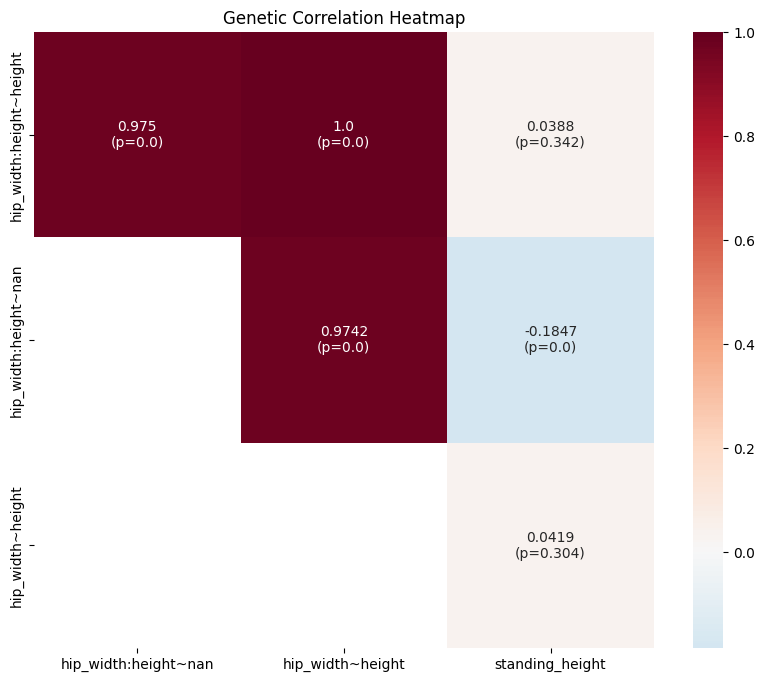

In [56]:
# Create a pivot table for heatmap
correlation_table = rg_df.pivot('pheno1', 'pheno2', 'cor')

# Create a pivot table for p-values
p_value_table = rg_df.pivot('pheno1', 'pheno2', 'p_value')

# Create a new DataFrame to hold the display values
display_table = correlation_table.astype(str) + "\n(p=" + p_value_table.round(3).astype(str) + ")"

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_table, annot=display_table, fmt='', cmap="RdBu_r", center=0)
plt.title("Genetic Correlation Heatmap")
plt.xlabel("")
plt.ylabel("")
plt.show()

## Genetic correlation for obstetrical phenotypes and pelvic shape

#### Female

In [30]:
!mkdir -p key_results/genetic_correlation/rg_20230909

In [34]:
df = pd.DataFrame(columns=['pheno_pelvic', 'pheno_pelvic_h2g', 'pheno_pelvic_h2g_se', 'pheno_pelvic_lambda',
                           'pheno_outcome', 'pheno_outcome_h2g', 'pheno_outcome_h2g_se', 'pheno_outcome_lambda',
                           'cor', 'se', 'z', 'p_value'])

path = "UKB_Imaging_Genetics/LDSC_OUTPUT/rg_pheno_outcome_20230909/female/"

for file in os.listdir(path):
    if file.endswith(".log"):
        file_modified = file.replace("_-_", "_")
        # get phenotype name
        pheno1 = file_modified.split('-')[0]
        pheno2 = file_modified.split('-')[1]
        pheno1 = pheno1.split('.')[0]
        pheno2 = pheno2.split('_rg.log')[0]

        with open(os.path.join(path, file), "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            # get h2g
            if line.startswith("Heritability of phenotype 1") and i + 2 < len(lines):
                h2g_1 = lines[i + 2].split(" ")[4].strip()
                h2g_1 = float(h2g_1)

                h2g_1_se = lines[i + 2].split(" ")[5].strip()
                h2g_1_se = h2g_1_se[1:-1]
                h2g_1_se = float(h2g_1_se)

                pheno1_lambda = lines[i + 3].split(" ")[2].strip()
                pheno1_lambda = float(pheno1_lambda)
            
            if line.startswith("Heritability of phenotype 2/2") and i + 2 < len(lines):
                h2g_2 = lines[i + 2].split(" ")[4].strip()
                h2g_2 = float(h2g_2)
                
                h2g_2_se = lines[i + 2].split(" ")[5].strip()
                h2g_2_se = h2g_2_se[1:-1]
                h2g_2_se = float(h2g_2_se)

                pheno2_lambda = lines[i + 3].split(" ")[2].strip()
                pheno2_lambda = float(pheno1_lambda)

            # get rg
            if line.startswith("Genetic Correlation:"):
                # print(line)
                rg = line.split(" ")[2].strip()
                rg = float(rg)
                # print(rg)
                se = line.split(" ")[3].strip()
                se = se[1:-1]
                se = float(se)
            if line.startswith("Z-score:"):
                z = line.split(" ")[1].strip()
                z = float(z)
            if line.startswith("P:"):
                p_value = line.split(" ")[1].strip()
                p_value = float(p_value)
                neglog10p = -np.log10(p_value)
            if line.startswith("ERROR"):
                rg = "NA"
                se = "NA"
                z = "NA"
                p_value = "NA"
                neglog10p = "NA"
                break

        df = df.append({'pheno_pelvic': pheno1, 'pheno_pelvic_h2g': h2g_1, 'pheno_pelvic_h2g_se': h2g_1_se, 'pheno_pelvic_lambda': pheno1_lambda,
                        'pheno_outcome': pheno2, 'pheno_outcome_h2g': h2g_2, 'pheno_outcome_h2g_se': h2g_2_se, 'pheno_outcome_lambda': pheno2_lambda,
                        'cor': rg, 'se': se, 'z': z, 'p_value': p_value, 'neglog10p': neglog10p}, 
                        ignore_index=True)

df.sort_values(by = ['pheno_pelvic', 'pheno_outcome'], inplace=True)
df.to_csv("key_results/genetic_correlation/rg_20230909/rg_hip_pelvic_vs_outcome_female.csv", index=False)

In [35]:
df[df['pheno_outcome'] == "finngen_R9_O15_LABOUR_PELVIC_ABNORM"]

,pheno_pelvic,pheno_pelvic_h2g,pheno_pelvic_h2g_se,pheno_pelvic_lambda,pheno_outcome,pheno_outcome_h2g,pheno_outcome_h2g_se,pheno_outcome_lambda,cor,se,z,p_value,neglog10p
465,BW_devide_oblique_pelvic_inlet_length,0.1310,0.0376,1.0466,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.0466,0.559,0.1561,3.581,0.0003,3.522879
1627,BW_devide_pelvic_inlet_area,0.1462,0.0375,1.0466,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.0466,0.7444,0.1598,4.657,0.000003,5.493752
847,BW_devide_pelvic_inlet_width,0.1176,0.0375,1.0466,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.0466,0.4526,0.175,2.5859,0.0097,2.013228
851,acetabular_diameter,0.3373,0.0436,1.0957,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.0957,0.0743,0.0934,0.7958,0.4262,0.370387
709,acetabular_inclination,0.2538,0.0438,1.0957,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.0957,-0.3268,0.1065,-3.069,0.0021,2.677781
825,arm_devide_torso,0.4144,0.0456,1.0957,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.0957,0.008,0.0812,0.098,0.922,0.035269
1582,arm_divide_leg,0.4272,0.0445,1.0957,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.0957,0.0939,0.088,1.0672,0.2859,0.543786
1428,bi_acetabular_width,0.4971,0.0517,1.1459,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.1459,-0.5607,0.0829,-6.7649,0.0,10.874942
1421,ear_left2ear_right,0.3461,0.0406,1.0957,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.0957,-0.0679,0.0861,-0.7891,0.4301,0.366431
925,head_area_divide_pelvic_inlet_area,0.3165,0.0378,1.0957,finngen_R9_O15_LABOUR_PELVIC_ABNORM,0.0217,0.0034,1.0957,0.356,0.0864,4.1179,0.000038,4.41755


#### Male

In [56]:
df = pd.DataFrame(columns=['pheno_pelvic', 'pheno_pelvic_h2g', 'pheno_pelvic_h2g_se', 'pheno_pelvic_lambda',
                           'pheno_outcome', 'pheno_outcome_h2g', 'pheno_outcome_h2g_se', 'pheno_outcome_lambda',
                           'cor', 'se', 'z', 'p_value'])

path = "UKB_Imaging_Genetics/LDSC_OUTPUT/rg_pheno_outcome_20230909/male/"

for file in os.listdir(path):
    if file.endswith(".log"):
        file_modified = file.replace("_-_", "_")
        # get phenotype name
        pheno1 = file_modified.split('-')[0]
        pheno2 = file_modified.split('-')[1]
        pheno1 = pheno1.split('.')[0]
        pheno2 = pheno2.split('_rg.log')[0]

        with open(os.path.join(path, file), "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            # get h2g
            if line.startswith("Heritability of phenotype 1") and i + 2 < len(lines):
                h2g_1 = lines[i + 2].split(" ")[4].strip()
                h2g_1 = float(h2g_1)

                h2g_1_se = lines[i + 2].split(" ")[5].strip()
                h2g_1_se = h2g_1_se[1:-1]
                h2g_1_se = float(h2g_1_se)

                pheno1_lambda = lines[i + 3].split(" ")[2].strip()
                pheno1_lambda = float(pheno1_lambda)
            
            if line.startswith("Heritability of phenotype 2/2") and i + 2 < len(lines):
                h2g_2 = lines[i + 2].split(" ")[4].strip()
                h2g_2 = float(h2g_2)
                
                h2g_2_se = lines[i + 2].split(" ")[5].strip()
                h2g_2_se = h2g_2_se[1:-1]
                h2g_2_se = float(h2g_2_se)

                pheno2_lambda = lines[i + 3].split(" ")[2].strip()
                pheno2_lambda = float(pheno1_lambda)

            # get rg
            if line.startswith("Genetic Correlation:"):
                # print(line)
                rg = line.split(" ")[2].strip()
                rg = float(rg)
                # print(rg)
                se = line.split(" ")[3].strip()
                se = se[1:-1]
                se = float(se)
            if line.startswith("Z-score:"):
                z = line.split(" ")[1].strip()
                z = float(z)
            if line.startswith("P:"):
                p_value = line.split(" ")[1].strip()
                p_value = float(p_value)
                neglog10p = -np.log10(p_value)
            if line.startswith("ERROR"):
                rg = "NA"
                se = "NA"
                z = "NA"
                p_value = "NA"
                neglog10p = "NA"
                break

        df = df.append({'pheno_pelvic': pheno1, 'pheno_pelvic_h2g': h2g_1, 'pheno_pelvic_h2g_se': h2g_1_se, 'pheno_pelvic_lambda': pheno1_lambda,
                        'pheno_outcome': pheno2, 'pheno_outcome_h2g': h2g_2, 'pheno_outcome_h2g_se': h2g_2_se, 'pheno_outcome_lambda': pheno2_lambda,
                        'cor': rg, 'se': se, 'z': z, 'p_value': p_value, 'neglog10p': neglog10p}, 
                        ignore_index=True)

df.sort_values(by = ['pheno_pelvic', 'pheno_outcome'], inplace=True)
df.to_csv("key_results/genetic_correlation/rg_20230909/rg_hip_pelvic_vs_outcome_male.csv", index=False)

#### Both

In [57]:
df = pd.DataFrame(columns=['pheno_pelvic', 'pheno_pelvic_h2g', 'pheno_pelvic_h2g_se', 'pheno_pelvic_lambda',
                           'pheno_outcome', 'pheno_outcome_h2g', 'pheno_outcome_h2g_se', 'pheno_outcome_lambda',
                           'cor', 'se', 'z', 'p_value'])

path = "UKB_Imaging_Genetics/LDSC_OUTPUT/rg_pheno_outcome_20230909/both/"

for file in os.listdir(path):
    if file.endswith(".log"):
        file_modified = file.replace("_-_", "_")
        # get phenotype name
        pheno1 = file_modified.split('-')[0]
        pheno2 = file_modified.split('-')[1]
        pheno1 = pheno1.split('.')[0]
        pheno2 = pheno2.split('_rg.log')[0]

        with open(os.path.join(path, file), "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            # get h2g
            if line.startswith("Heritability of phenotype 1") and i + 2 < len(lines):
                h2g_1 = lines[i + 2].split(" ")[4].strip()
                h2g_1 = float(h2g_1)

                h2g_1_se = lines[i + 2].split(" ")[5].strip()
                h2g_1_se = h2g_1_se[1:-1]
                h2g_1_se = float(h2g_1_se)

                pheno1_lambda = lines[i + 3].split(" ")[2].strip()
                pheno1_lambda = float(pheno1_lambda)
            
            if line.startswith("Heritability of phenotype 2/2") and i + 2 < len(lines):
                h2g_2 = lines[i + 2].split(" ")[4].strip()
                h2g_2 = float(h2g_2)
                
                h2g_2_se = lines[i + 2].split(" ")[5].strip()
                h2g_2_se = h2g_2_se[1:-1]
                h2g_2_se = float(h2g_2_se)

                pheno2_lambda = lines[i + 3].split(" ")[2].strip()
                pheno2_lambda = float(pheno1_lambda)

            # get rg
            if line.startswith("Genetic Correlation:"):
                # print(line)
                rg = line.split(" ")[2].strip()
                rg = float(rg)
                # print(rg)
                se = line.split(" ")[3].strip()
                se = se[1:-1]
                se = float(se)
            if line.startswith("Z-score:"):
                z = line.split(" ")[1].strip()
                z = float(z)
            if line.startswith("P:"):
                p_value = line.split(" ")[1].strip()
                p_value = float(p_value)
                neglog10p = -np.log10(p_value)
            if line.startswith("ERROR"):
                rg = "NA"
                se = "NA"
                z = "NA"
                p_value = "NA"
                neglog10p = "NA"
                break

        df = df.append({'pheno_pelvic': pheno1, 'pheno_pelvic_h2g': h2g_1, 'pheno_pelvic_h2g_se': h2g_1_se, 'pheno_pelvic_lambda': pheno1_lambda,
                        'pheno_outcome': pheno2, 'pheno_outcome_h2g': h2g_2, 'pheno_outcome_h2g_se': h2g_2_se, 'pheno_outcome_lambda': pheno2_lambda,
                        'cor': rg, 'se': se, 'z': z, 'p_value': p_value, 'neglog10p': neglog10p}, 
                        ignore_index=True)

df.sort_values(by = ['pheno_pelvic', 'pheno_outcome'], inplace=True)
df.to_csv("key_results/genetic_correlation/rg_20230909/rg_hip_pelvic_vs_outcome_both.csv", index=False)

In [58]:
df

,pheno_pelvic,pheno_pelvic_h2g,pheno_pelvic_h2g_se,pheno_pelvic_lambda,pheno_outcome,pheno_outcome_h2g,pheno_outcome_h2g_se,pheno_outcome_lambda,cor,se,z,p_value,neglog10p
1089,acetabular_diameter,0.2930,0.0311,1.1459,EGG_Maternal_GWAS_META_gestational_duration,0.0357,0.0046,1.1459,0.0111,0.0703,0.158,0.8745,0.05824
745,acetabular_diameter,0.2921,0.0308,1.1459,EGG_Maternal_GWAS_META_postterm_delivery,0.0148,0.0033,1.1459,0.1404,0.1018,1.3785,0.168,0.774691
606,acetabular_diameter,0.2921,0.0312,1.1459,EGG_Maternal_GWAS_META_preterm_delivery,0.0109,0.0020,1.1459,0.0271,0.0876,0.3097,0.7568,0.121019
1376,acetabular_diameter,0.2931,0.0309,1.1459,Fetal_BW_European_meta.NG2019,0.0988,0.0058,1.1459,0.1145,0.0369,3.1049,0.0019,2.721246
552,acetabular_diameter,0.2931,0.0309,1.1459,Fetal_BW_transethnic_meta.NG2019,0.0941,0.0055,1.1459,0.1218,0.0358,3.402,0.0007,3.154902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632,trochanter_left2trochanter_right,0.3528,0.0379,1.2005,neale_Number_of_stillbirths,0.0077,0.0081,1.2005,-0.0249,0.1774,-0.1402,0.8885,0.051343
81,trochanter_left2trochanter_right,0.3528,0.0379,1.2005,neale_Oestradiol_pmol_L,0.0235,0.0092,1.2005,0.1536,0.108,1.4233,0.1546,0.810791
343,trochanter_left2trochanter_right,0.3528,0.0379,1.2005,neale_Years_since_last_breast_cancer_screening...,0.0049,0.0044,1.2005,-0.1141,0.1741,-0.6556,0.5121,0.290645
564,trochanter_left2trochanter_right,0.3528,0.0379,1.2005,neale_Years_since_last_cervical_smear_test,0.0151,0.0028,1.2005,-0.1245,0.0881,-1.4132,0.1576,0.802444


### Combine male and female together to see if any difference

In [59]:
female_df = pd.read_csv("key_results/genetic_correlation/rg_20230909/rg_hip_pelvic_vs_outcome_female.csv")
male_df = pd.read_csv("key_results/genetic_correlation/rg_20230909/rg_hip_pelvic_vs_outcome_male.csv")
female_df = female_df[['pheno_pelvic', 'pheno_outcome', 'cor', 'se', 'z', 'p_value']]
male_df = male_df[['pheno_pelvic', 'pheno_outcome', 'cor', 'se', 'z', 'p_value']]
female_df.rename(columns = {'cor': 'female_cor', 'se': 'female_se', 'z': 'female_z', 'p_value': 'female_p'}, inplace = True)
male_df.rename(columns = {'cor': 'male_cor', 'se': 'male_se', 'z': 'male_z', 'p_value': 'male_p'}, inplace = True)

# Merge
mf_df = female_df.merge(male_df, on = ['pheno_pelvic', 'pheno_outcome'], how = 'inner')

In [60]:
mf_df

,pheno_pelvic,pheno_outcome,female_cor,female_se,female_z,female_p,male_cor,male_se,male_z,male_p
0,acetabular_diameter,EGG_Maternal_GWAS_META_gestational_duration,0.1059,0.0772,1.3715,0.1702,-0.0216,0.0946,-0.2281,0.8195
1,acetabular_diameter,EGG_Maternal_GWAS_META_postterm_delivery,0.1092,0.1221,0.8947,0.3710,0.1926,0.1221,1.5778,0.1146
2,acetabular_diameter,EGG_Maternal_GWAS_META_preterm_delivery,-0.0014,0.1097,-0.0131,0.9895,0.0372,0.1062,0.3502,0.7262
3,acetabular_diameter,Fetal_BW_European_meta.NG2019,0.1096,0.0429,2.5537,0.0107,0.0912,0.0451,2.0224,0.0431
4,acetabular_diameter,Fetal_BW_transethnic_meta.NG2019,0.1177,0.0427,2.7569,0.0058,0.0987,0.0432,2.2851,0.0223
...,...,...,...,...,...,...,...,...,...,...
1738,trochanter_left2trochanter_right,neale_Number_of_stillbirths,-0.1920,0.2417,-0.7943,0.4270,0.2431,0.2720,0.8937,0.3715
1739,trochanter_left2trochanter_right,neale_Oestradiol_pmol_L,0.2034,0.1444,1.4082,0.1591,0.1240,0.1402,0.8844,0.3765
1740,trochanter_left2trochanter_right,neale_Years_since_last_breast_cancer_screening...,0.0313,0.2276,0.1376,0.8906,-0.3138,0.2433,-1.2898,0.1971
1741,trochanter_left2trochanter_right,neale_Years_since_last_cervical_smear_test,-0.2476,0.1090,-2.2725,0.0231,-0.0308,0.1079,-0.2851,0.7756


In [61]:
mf_df.to_csv("key_results/genetic_correlation/rg_20230909/rg_hip_pelvic_vs_outcome_male_and_female.csv", index=False)

## rg for Handedness

In [4]:
!mkdir -p key_results/genetic_correlation/rg_20230830

In [9]:
# both rg
rg_df = pd.DataFrame(columns=['pheno1', 'pheno1_h2g', 'pheno1_h2g_se', 'pheno1_lambda',
                                   'pheno2', 'pheno2_h2g', 'pheno2_h2g_se', 'pheno2_lambda',
                                   'cor', 'se', 'z', 'p_value'])
path = "UKB_Imaging_Genetics/LDSC_OUTPUT/rg_hip_handedness_20230830"
for file in os.listdir(path):
    if file.endswith(".log"):
        # get phenotype name
        pheno1, pheno2 = file.split('-')
        pheno1 = pheno1.split('.')[1]
        pheno2 = pheno2.split('.')
        if len(pheno2) == 2:
            pheno2 = pheno2[0]
        else:
            pheno2 = pheno2[1]

        with open(os.path.join(path, file), "r") as f:
            lines = f.readlines()cd

        for i, line in enumerate(lines):
            # get h2g
            if line.startswith("Heritability of phenotype 1") and i + 2 < len(lines):
                h2g_1 = lines[i + 2].split(" ")[4].strip()
                h2g_1 = float(h2g_1)

                h2g_1_se = lines[i + 2].split(" ")[5].strip()
                h2g_1_se = h2g_1_se[1:-1]
                h2g_1_se = float(h2g_1_se)

                pheno1_lambda = lines[i + 3].split(" ")[2].strip()
                pheno1_lambda = float(pheno1_lambda)
            
            if line.startswith("Heritability of phenotype 2/2") and i + 2 < len(lines):
                h2g_2 = lines[i + 2].split(" ")[4].strip()
                h2g_2 = float(h2g_2)
                
                h2g_2_se = lines[i + 2].split(" ")[5].strip()
                h2g_2_se = h2g_2_se[1:-1]
                h2g_2_se = float(h2g_2_se)

                pheno2_lambda = lines[i + 3].split(" ")[2].strip()
                pheno2_lambda = float(pheno1_lambda)

            # get rg
            if line.startswith("Genetic Correlation:"):
                # print(line)
                rg = line.split(" ")[2].strip()
                rg = float(rg)
                # print(rg)
                se = line.split(" ")[3].strip()
                se = se[1:-1]
                se = float(se)
            if line.startswith("Z-score:"):
                z = line.split(" ")[1].strip()
                z = float(z)
            if line.startswith("P:"):
                p_value = line.split(" ")[1].strip()
                p_value = float(p_value)
                neglog10p = -np.log10(p_value)

        rg_df = rg_df.append({'pheno1': pheno1, 'pheno1_h2g': h2g_1, 'pheno1_h2g_se': h2g_1_se, 'pheno1_lambda': pheno1_lambda,
                                        'pheno2': pheno2, 'pheno2_h2g': h2g_2, 'pheno2_h2g_se': h2g_2_se, 'pheno2_lambda': pheno2_lambda,
                                        'cor': rg, 'se': se, 'z': z, 'p_value': p_value, 'neglog10p': neglog10p}, 
                                        ignore_index=True)

rg_df.sort_values(by = ['pheno1', 'pheno2'], inplace=True)
rg_df.to_csv("key_results/genetic_correlation/rg_20230830/rg_hip_handedness.csv", index=False)


/var/folders/7f/jzt97g754236ldjj13l5pgd00000gn/T/ipykernel_1794/1928971526.py:59: RuntimeWarning: divide by zero encountered in log10
  neglog10p = -np.log10(p_value)


In [10]:
rg_df

,pheno1,pheno1_h2g,pheno1_h2g_se,pheno1_lambda,pheno2,pheno2_h2g,pheno2_h2g_se,pheno2_lambda,cor,se,z,p_value,neglog10p
10,acetabular_diameter_ratio,0.0121,0.0143,1.0046,acetabular_diameter_ratio,0.0121,0.0143,1.0046,1.0000,0.000027,36445.8037,0.0000,inf
17,acetabular_diameter_ratio,0.0121,0.0143,1.0046,acetabular_inclination_ratio,0.0128,0.0146,1.0046,-0.7196,1.066800,-0.6746,0.5000,0.301030
7,acetabular_diameter_ratio,0.0131,0.0149,1.0046,equally_handed_rg,0.0039,0.0013,1.0046,0.1713,0.455500,0.3761,0.7068,0.150703
12,acetabular_diameter_ratio,0.0121,0.0143,1.0046,iliac_isthmus_breadth_ratio,0.0277,0.0157,1.0046,0.2180,0.516200,0.4224,0.6727,0.172179
11,acetabular_diameter_ratio,0.0131,0.0149,1.0046,left_handed_rg,0.0104,0.0016,1.0046,-0.3954,0.345700,-1.1438,0.2527,0.597395
6,acetabular_diameter_ratio,0.0131,0.0149,1.0046,right_handed_rg,0.0096,0.0015,1.0046,0.3415,0.335400,1.0182,0.3086,0.510604
15,acetabular_inclination_ratio,0.0128,0.0146,1.0135,acetabular_diameter_ratio,0.0121,0.0143,1.0135,-0.7196,1.066800,-0.6746,0.5000,0.301030
8,acetabular_inclination_ratio,0.0128,0.0146,1.0135,acetabular_inclination_ratio,0.0128,0.0146,1.0135,1.0001,0.000200,5373.2587,0.0000,inf
14,acetabular_inclination_ratio,0.0155,0.0157,1.0105,equally_handed_rg,0.0039,0.0013,1.0105,0.4163,0.463600,0.8980,0.3692,0.432738
1,acetabular_inclination_ratio,0.0128,0.0146,1.0135,iliac_isthmus_breadth_ratio,0.0277,0.0157,1.0135,-0.5396,0.459700,-1.1738,0.2405,0.618885


# SLDSC

## for ATAC-seq from science advance paper

In [1]:
path = "UKB_Imaging_Genetics/LDSC_OUTPUT/SLDSC_OUTPUT/part_h2g_20230920_sa_atacseq"

In [4]:
both_res_files = []
male_res_files = [] 
female_res_files = []

for f in os.listdir(path):
    if f.endswith('.results'):
        if "both" in f:
            both_res_files.append(f)
        elif "female" in f:
            female_res_files.append(f)
        elif "male" in f:
            male_res_files.append(f)

print("Both: ", len(both_res_files))
print("Female: ", len(female_res_files))
print("Male: ", len(male_res_files))

Both:  504
Female:  504
Male:  504


In [5]:
def assign_group(i):
    if "Human" in i and "Brain-Filtered" in i:
        group = "Human_Brain_Filtered"
    elif "Human" in i and "Gain" in i:
        group = "Human_Gain"
    elif "Human" in i and "Mouse" in i and "Shared" in i:
        group = "Human_Mouse_Shared"
    elif "Human" in i and "Mouse" in i and "Intersect" in i:
        group = "Human_Mouse_Intersect"
    elif "Mouse" in i and "Brain-Filter" in i:
        group = "Mouse_Brain_Filtered"
    elif "Mouse" in i and "Gain" in i:
        group = "Mouse_Gain"
    elif "Mouse" in i:
        group = "Mouse"
    elif "Human" in i:
        group = "Human"
    return group

#### For both male and female

In [9]:
all_res_df = None

for f in both_res_files:
    anno, pheno = f.split('iPSYCH-PGC_ASD_baseline_')[1].split('_both.results')[0].split('_sorted_control_')
    df = pd.read_csv(os.path.join(path, f), sep='\t')
    df = df[df['Category'] == 'L2_1']
    df['Annotation'] = anno
    df['Phenotype'] = pheno

    if all_res_df is None:
        all_res_df = df
    else:
        all_res_df = pd.concat([all_res_df, df], axis=0)

all_res_df['Group'] = all_res_df['Annotation'].apply(lambda x: assign_group(x))
all_res_df['neglog10p'] = -np.log10(all_res_df['Enrichment_p'])
all_res_df.drop(columns=['Category'], inplace=True)

all_res_df.to_csv('key_results/SLDSC_results_from_sa_paper_both.csv', index=False)

#### For female

In [10]:
all_res_df = None

for f in female_res_files:
    anno, pheno = f.split('iPSYCH-PGC_ASD_baseline_')[1].split('_female.results')[0].split('_sorted_control_')
    df = pd.read_csv(os.path.join(path, f), sep='\t')
    df = df[df['Category'] == 'L2_1']
    df['Annotation'] = anno
    df['Phenotype'] = pheno

    if all_res_df is None:
        all_res_df = df
    else:
        all_res_df = pd.concat([all_res_df, df], axis=0)

all_res_df['Group'] = all_res_df['Annotation'].apply(lambda x: assign_group(x))
all_res_df['neglog10p'] = -np.log10(all_res_df['Enrichment_p'])
all_res_df.drop(columns=['Category'], inplace=True)

all_res_df.to_csv('key_results/SLDSC_results_from_sa_paper_female.csv', index=False)

#### For male

In [11]:
all_res_df = None

for f in male_res_files:
    anno, pheno = f.split('iPSYCH-PGC_ASD_baseline_')[1].split('_male.results')[0].split('_sorted_control_')
    df = pd.read_csv(os.path.join(path, f), sep='\t')
    df = df[df['Category'] == 'L2_1']
    df['Annotation'] = anno
    df['Phenotype'] = pheno

    if all_res_df is None:
        all_res_df = df
    else:
        all_res_df = pd.concat([all_res_df, df], axis=0)

all_res_df['Group'] = all_res_df['Annotation'].apply(lambda x: assign_group(x))
all_res_df['neglog10p'] = -np.log10(all_res_df['Enrichment_p'])
all_res_df.drop(columns=['Category'], inplace=True)

all_res_df.to_csv('key_results/SLDSC_results_from_sa_paper_male.csv', index=False)

In [12]:
all_res_df

,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score,Annotation,Phenotype,Group,neglog10p
97,0.010033,0.198410,0.050714,19.775556,5.054636,0.000040,1.087595e-06,2.862098e-07,3.799992,HumanIlium_Brain-Filtered_Peaks,subpubic_angle,Human_Brain_Filtered,4.398777
97,0.007442,0.080376,0.031066,10.800572,4.174452,0.016550,6.848862e-07,3.267313e-07,2.096175,Human_Gain_Acet_Peaks,shoulder_divide_inlet_width,Human_Gain,1.781209
97,0.002668,0.020758,0.025913,7.779889,9.712026,0.485627,2.134762e-07,6.790052e-07,0.314396,Mouse_Gain_Acet_Peaks,iliac_flare_angle,Mouse_Gain,0.313697
97,0.010033,0.240290,0.080939,23.949710,8.067230,0.001199,9.515813e-07,3.290763e-07,2.891673,HumanIlium_Brain-Filtered_Peaks,arm_devide_torso,Human_Brain_Filtered,2.921199
97,0.011133,0.189178,0.057512,16.991920,5.165734,0.000410,7.051124e-07,2.451274e-07,2.876514,HumanPubis_Brain-Filtered_Peaks,oblique_pelvic_inlet_length,Human_Brain_Filtered,3.386805
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.007123,-0.020490,0.037547,-2.876489,5.271019,0.460099,-2.726903e-07,3.673025e-07,-0.742413,Mouse_Acetabulum_IDR_Peaks,iliac_flare_ratio,Mouse,0.337149
97,0.000952,0.071641,0.022684,75.253736,23.827674,0.000413,4.421636e-06,1.317957e-06,3.354917,Human_Mouse_ATAC-seq_Intersect,subpubic_angle,Human_Mouse_Intersect,3.384051
97,0.017054,0.132455,0.077305,7.766840,4.532978,0.108582,3.334493e-07,3.167105e-07,1.052852,Human_Acetabulum_IDR_Peaks,pelvic_inlet_area,Human,0.964242
97,0.007123,0.015331,0.040320,2.152174,5.660377,0.838820,7.316187e-08,3.542477e-07,0.206527,Mouse_Acetabulum_IDR_Peaks,head_divide_inlet_width,Mouse,0.076331


## for evolution annotations

In [73]:
path = "UKB_Imaging_Genetics/LDSC_OUTPUT/SLDSC_OUTPUT/part_h2g_20230920_evolution"

In [74]:
both_res_files = []
male_res_files = [] 
female_res_files = []

for f in os.listdir(path):
    if f.endswith('.results'):
        if "both" in f:
            both_res_files.append(f)
        elif "female" in f:
            female_res_files.append(f)
        elif "male" in f:
            male_res_files.append(f)

print("Both: ", len(both_res_files))
print("Female: ", len(female_res_files))
print("Male: ", len(male_res_files))

Both:  210
Female:  210
Male:  210


#### both

In [77]:
all_res_df = None

for f in both_res_files:
    anno, pheno = f.split('iPSYCH-PGC_ASD_baseline_')[1].split('_both.results')[0].split('_sorted_control_')
    df = pd.read_csv(os.path.join(path, f), sep='\t')
    df = df[df['Category'] == 'L2_1']
    df['Annotation'] = anno
    df['Phenotype'] = pheno

    if all_res_df is None:
        all_res_df = df
    else:
        all_res_df = pd.concat([all_res_df, df], axis=0)

all_res_df['neglog10p'] = -np.log10(all_res_df['Enrichment_p'])
all_res_df.drop(columns=['Category'], inplace=True)

all_res_df.to_csv('key_results/SLDSC_results_evo_anno_both.csv', index=False)

#### female

In [78]:
all_res_df = None

for f in female_res_files:
    anno, pheno = f.split('iPSYCH-PGC_ASD_baseline_')[1].split('_female.results')[0].split('_sorted_control_')
    df = pd.read_csv(os.path.join(path, f), sep='\t')
    df = df[df['Category'] == 'L2_1']
    df['Annotation'] = anno
    df['Phenotype'] = pheno

    if all_res_df is None:
        all_res_df = df
    else:
        all_res_df = pd.concat([all_res_df, df], axis=0)

all_res_df['neglog10p'] = -np.log10(all_res_df['Enrichment_p'])
all_res_df.drop(columns=['Category'], inplace=True)

all_res_df.to_csv('key_results/SLDSC_results_evo_anno_female.csv', index=False)

#### male

In [79]:
all_res_df = None

for f in male_res_files:
    anno, pheno = f.split('iPSYCH-PGC_ASD_baseline_')[1].split('_male.results')[0].split('_sorted_control_')
    df = pd.read_csv(os.path.join(path, f), sep='\t')
    df = df[df['Category'] == 'L2_1']
    df['Annotation'] = anno
    df['Phenotype'] = pheno

    if all_res_df is None:
        all_res_df = df
    else:
        all_res_df = pd.concat([all_res_df, df], axis=0)

all_res_df['neglog10p'] = -np.log10(all_res_df['Enrichment_p'])
all_res_df.drop(columns=['Category'], inplace=True)

all_res_df.to_csv('key_results/SLDSC_results_evo_anno_male.csv', index=False)

In [84]:
all_res_df['Annotation'].value_counts()

GSE63648_7pcw_ac_me2_Hu_gain                     21
promoters_human_macaque_prefontal_cortex_hg19    21
depleted_neanderthal_denisovan_vernot            21
GSE63648_12Opcw_ac_me2_Hu_gain                   21
nchaes_merged_hg19                               21
GSE63648_8_5pcw_ac_me2_Hu_gain                   21
selsweeps_233putativeregions_peyregne            21
GSE63648_12Fpcw_ac_me2_Hu_gain                   21
enhancers_human_macaque_prefontal_cortex_hg19    21
depleted_neanderthal_vernot                      21
Name: Annotation, dtype: int64

In [83]:
all_res_df.sort_values(by=['Enrichment_p']).head(20)

,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score,Annotation,Phenotype,neglog10p
97,0.008458,0.109611,0.031814,12.959795,3.761476,0.000358,6.722678e-07,2.152973e-07,3.122509,GSE63648_7pcw_ac_me2_Hu_gain,shoulder_width,3.446298
97,0.000780,-0.013063,0.004136,-16.753403,5.304319,0.000912,-1.497267e-06,4.409633e-07,-3.395446,promoters_human_macaque_prefontal_cortex_hg19,pelvic_inlet_width,3.040035
97,0.015396,0.006282,0.002497,0.407994,0.162164,0.000942,-4.638725e-08,1.906406e-08,-2.433231,depleted_neanderthal_denisovan_vernot,pelvic_height,3.025892
97,0.008458,0.068061,0.019651,8.047131,2.323383,0.001408,5.469099e-07,2.492603e-07,2.194132,GSE63648_7pcw_ac_me2_Hu_gain,pelvic_height,2.851522
97,0.008458,0.098975,0.031577,11.702258,3.733490,0.001501,5.600452e-07,2.070194e-07,2.705279,GSE63648_7pcw_ac_me2_Hu_gain,subpubic_angle,2.823637
97,0.004394,0.049179,0.016593,11.192451,3.776333,0.007490,8.152548e-07,4.113818e-07,1.981747,GSE63648_12Opcw_ac_me2_Hu_gain,pelvic_height,2.125509
97,0.015396,0.028858,0.005411,1.874369,0.351464,0.007921,6.717541e-08,2.269610e-08,2.959777,depleted_neanderthal_denisovan_vernot,iliac_flare_angle,2.101231
97,0.008458,0.071640,0.025119,8.470336,2.969943,0.007970,3.885626e-07,2.102545e-07,1.848058,GSE63648_7pcw_ac_me2_Hu_gain,iliac_flare_angle,2.098520
97,0.008458,0.070785,0.024150,8.369290,2.855395,0.009083,4.705241e-07,2.405948e-07,1.955670,GSE63648_7pcw_ac_me2_Hu_gain,shoulder_divide_inlet_width,2.041788
97,0.008458,0.096298,0.036353,11.385788,4.298129,0.010322,4.497949e-07,2.188284e-07,2.055468,GSE63648_7pcw_ac_me2_Hu_gain,shoulder_area_divide_pelvic_inlet_area,1.986225


---

In [ ]:
sns.scatterplot(data=all_res_df, x="Annotation", y="neglog10p", hue="Phenotype", palette="deep")
